In [1]:
'''
Mach Zehnder Interferometer Mesh Optimization with Quantum Dot Phase Shifters
Version #: 28
Written by: Adam Robert James McCaw
Queen's Nanophotonics Lab, Queen's University
Date of Last Edit: Oct 11, 2023
'''

#Import libraries
from qiskit import quantum_info
from qiskit.visualization import array_to_latex
import numpy as np
import nlopt
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as scp
from numba import jit, njit
from numba.experimental import jitclass
import numba
from numba import types
import random
from itertools import combinations
from itertools import product as iter_prod
from scipy.stats import norm
from scipy.stats import beta
from scipy.optimize import curve_fit

#These four libraries are only necessary if running simulations on the 2-photon unheralded CZ or CNOT
#The quotonic library was written by Jacob Ewaniuk and uses Cython, so it requires a C++ compiler install to use
#Comment these out if not needed
from quotonic.aa import multiPhotonUnitary as mpu
from quotonic.fock import basis
from Unheralded_CNOT import find_Unheralded_CNOT as find_CNOT
from Unheralded_CZ import find_Unheralded_CZ as find_CZ

[[-5.77350269e-01+0.j  8.16496581e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 8.16496581e-01+0.j  5.77350269e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -5.77350269e-01+0.j
   5.77350269e-01+0.j  5.77350269e-01+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  5.77350269e-01+0.j
   5.77350269e-01+0.j  8.25542809e-18+0.j  5.77350269e-01+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  5.77350269e-01+0.j
   8.25542809e-18+0.j  5.77350269e-01+0.j -5.77350269e-01+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   5.77350269e-01+0.j -5.77350269e-01+0.j -5.77350269e-01+0.j]]
21


In [2]:
#NO PYTHON MODE METHODS FOR NUMBA
#This section includes all functions required to use nlopt's nopython compilation for massive speed-up
#These functions were all labelled static as they were going to be included in the class as static methods
#But the simpler implementation was to exclude them from the class.
#However, I left them named static since unlike our class functions since they don't use the self parameter
#They are also all copies of existing methods inside the class
#Since they don't use self, all required attributes of the class need to be passed
#This is required since nlopt does not currently support the self parameter 

#Function for sampling a new detuning from the spectral diffusion distribution
#Implements numba's nopython mode with njit
#Inputs (both should be relative to Gamma) -> Initial Detuning (float), sigma for spectral diffusion distribution (float)
#Outputs -> a newly sampled detuning (float)
@njit()
def spectral_Diffusion_Sampler_Static(detuning, spectral_Diffusion):

    random_Shift = np.random.normal(loc=0,scale=spectral_Diffusion) #shift in detuning from spectral diffusion
    new_Detuning = detuning - random_Shift #Minus because of how the specral diffusion curve shifts the peak

    return new_Detuning

#Heaviside function definition to determine if we are using Beta_L or Beta_R
#Implements numba's nopython mode with njit
#Inputs -> two locations along the waveguide: a (float), b (float)
#Outputs -> Heaviside Function Output (int)
@njit()
def Heaviside_Function_Static(a,b):
    if(a>b):
        return 1
    else:
        return 0

#Function that determines QD transmission coefficient (t)
#Implements numba's nopython mode with njit
#Generally we use Gamma = 1 for simulations, but as long as QD params are relative to Gamma this is not required it is just simpler
#Inputs -> location we are considering in waveguide: r (float), location of emitter: r_A (float), detuning for phase shifter (float), spontaneous rate of emission: Gamma (float), 
#mathematical parameter including dephasing: gamma_2 (float), coupling for light scattered left: beta_L (float), coupling for light scattered right: beta_R (float)
#Outputs -> transmission coefficient t (complex)
@njit()
def QD_transmission_Coefficient_Static(r,r_A, detuning, gamma, gamma_2, rabi_RP, beta_L, beta_R):
    
    #One of these will be 0 and one will be 1, selecting the appropriate beta
    heaviside_L = Heaviside_Function_Static(r_A,r)
    heaviside_R = Heaviside_Function_Static(r,r_A)

    #Split calculation into multiple lines for legibility but not necessary
    denominator = gamma_2**2+detuning**2+4*(gamma_2/gamma)*(rabi_RP)**2
    selector = heaviside_L*gamma*beta_L+heaviside_R*gamma*beta_R
    t = complex(1 - selector*gamma_2/denominator - 1j*selector*detuning/denominator)

    return t

#Function that determines QD Observable Transmission (T)
#Implements numba's nopython mode with njit
#Inputs -> location we are considering in waveguide: r (float), location of emitter: r_A (float), detuning for phase shifter (float), spontaneous rate of emission: Gamma (float), 
#mathematical parameter including dephasing: gamma_2 (float), coupling for light scattered left: beta_L (float), coupling for light scattered right: beta_R (float), Rabi frequency (should be 0 for this as we are in low power regime): rabi_RP (float)
#Outputs -> Observable T (float)
@njit()
def QD_Transmission_Static(r,r_A, detuning, gamma, gamma_2, beta_L, beta_R, rabi_RP):
    heaviside_L = Heaviside_Function_Static(r_A,r)
    heaviside_R = Heaviside_Function_Static(r,r_A)

    selector = (heaviside_L*gamma*beta_L+heaviside_R*gamma*beta_R)
    denom_1 = gamma_2**2+detuning**2+4*(gamma_2/gamma)*(rabi_RP)**2
    denom_2 = denom_1*gamma
    numerator_1=2*selector*gamma_2
    numerator_2=2*gamma_2*selector**2

    T = 1 - numerator_1/denom_1+numerator_2/denom_2
    return T


#Function that calculates the phase shift (in radians) from the detuning and QD params
#Note here we assume you are considering light scattering right (beta_R) and thus r and r_A are filled in in advance
#This could be edited if you want to be able to look at beta_L, but the choice is arbitrary so this should not be necessary
#Inputs -> detuning for phase shifter (float), spontaneous rate of emission: Gamma (float), gamma 2 parameter from derivation: gamma_2 (float), Rabi frequency (should be 0 for this as we are in low power regime): rabi_RP (float)
#coupling for light scattered left: beta_L (float), coupling for light scattered right: beta_R (float)
#Outputs -> QD phase shift (rad) (float)
@njit()
def phase_From_Detuning_Static(detuning, gamma, gamma_2, rabi_RP, beta_L, beta_R):
    t = QD_transmission_Coefficient_Static(0.1, 0, detuning, gamma, gamma_2, rabi_RP, beta_L, beta_R)
    phase_Rad = np.angle(t)
    return phase_Rad


#Function that solves the detuning from the phase shift based on QD params
#Inputs -> location we are considering in waveguide: location_R (boolean), phase shift: phase (float), coupling for light scattered left: beta_L (float), coupling for light scattered right: beta_R (float),
#spontaneous rate of emission: Gamma (float), gamma 2 parameter from derivation: gamma_2 (float), Rabi frequency (should be 0 for this as we are in low power regime): rabi_RP (float)
#Outputs -> Detuning from phase: detuning_Result (float)
@njit()
def detuning_Equation_Solve_Static(location_R, phase, beta_L, beta_R, gamma, gamma_2, rabi_RP):
    if(location_R == True):
        beta_Loc = beta_R #the beta at our location
    else:
        beta_Loc = beta_L

    #ensure phase is real
    phase = np.real(phase)

    #formula has undefined solution around 0 and pi phase shifts so deal with those cases manually here
    if(phase <= 0.000001 and phase >= -0.000001):
        det_1 = 10e15
        det_2 = 10e15
    
    elif(phase <= 3.1416 and phase >= 3.1415):
        det_1 = -10e-15
        det_2 = -10e-15

    elif(phase >= -3.1416 and phase <= -3.1415):
        det_1 = 10e-15
        det_2 = 10e-15

    #analytical solution to detuning from phase
    else:
        term_1 = gamma*beta_Loc*gamma_2
        term_2 = ((gamma**2)*beta_Loc**2)/(4*np.tan(phase)**2)
        term_3 = gamma_2**2
        term_4 = (4*(rabi_RP**2)*gamma_2)/gamma


        #term 4 should always be 0 in low power regime
        sqrt_Term = term_1 + term_2 - term_3 - term_4

       
        phase_Plus = 0
        #If the following is the case, we can't analytically solve.
        if(sqrt_Term < 0):
            if(phase>0): #try to lower the phase by 2pi and see if that's in range
                phase -= 2*np.pi
                phase_Plus = -1
            elif(phase<0): #try to increase the phase by 2pi and see if that's in range
                phase += 2*np.pi
                phase_Plus = 1
        
            term_2 = ((gamma**2)*beta_Loc**2)/(4*np.tan(phase)**2)
            sqrt_Term = term_1 + term_2 - term_3 - term_4
        
        #If still less than zero then we can't get to it, in the non-static version we run an optimizer for this. However that used scipy and this case should not occur unless imperfections are VERY high
        #For completeness an optmization should be run here, but it was uneccessary for my simulations
        if(sqrt_Term < 0): 
            print("This phase is not possible with your current parameters setting detuning = max for 0 phase")
            det_1 = 10e15
            det_2 = 10e15

        else:
            
            #2 solutions to the quadratic. One will be the correct solution and one will be nonsense. This is determined by whether you have a positive or negative phase indicating whether you have positive or negative detuning or not
            det_1 = -(gamma*beta_Loc)/(2*np.tan(phase)) + np.sqrt(sqrt_Term) 
            det_2 = -(gamma*beta_Loc)/(2*np.tan(phase)) - np.sqrt(sqrt_Term) 

    #To determine which detuning is correct, we compare the phase from these detuning solutions to the given phase shift and pick the result accordingly
    if(np.abs(phase_From_Detuning_Static(det_1, gamma, gamma_2, rabi_RP, beta_L, beta_R)-phase) < np.abs(phase_From_Detuning_Static(det_2, gamma, gamma_2, rabi_RP, beta_L, beta_R)-phase)):
        detuning_Result = det_1
    else:
        detuning_Result = det_2
    
    return detuning_Result


#Function that samples if a phase shifter is giving the incoherent 0 phase shift from detuning or the desired phase shift
#Incoherence probability is calculated based on T - |t|^2
#Inputs -> detuning for phase shift: det (float), spontaneous rate of emission: Gamma (float), gamma 2 parameter from derivation: gamma_2 (float),
#coupling for light scattered left: beta_L (float), coupling for light scattered right: beta_R (float), Rabi frequency (should be 0 for this as we are in low power regime): rabi_RP (float)
#Outputs -> phase on or off: phase_Off (boolean)
@njit()
def sample_Dephasing_Static(det, gamma, gamma_2, beta_L, beta_R, rabi_RP):

    #max included here to ensure rounding errors don't create a negative probability
    incoherence_Prob = max(min((QD_Transmission_Static(0.1,0, det, gamma, gamma_2, beta_L, beta_R, rabi_RP)-np.power(np.abs(QD_transmission_Coefficient_Static(0.1, 0, det, gamma, gamma_2, rabi_RP, beta_L, beta_R)),2))/(QD_Transmission_Static(0.1,0, det, gamma, gamma_2, beta_L, beta_R, rabi_RP)),1),0)
    phase_Off = np.random.random() < incoherence_Prob #get random number between 0 and 1 to sample if phase is off based on incoherence probability

    return phase_Off


#Function that sets the QD parameters from the distribution based on which phase shifter is being used
#This function ensures that the same parameters are used for each phase shifter throughout optimization, but also ensures that the QD params for different phase shifter are different, as set up by sampling from a distribution in the class function
#Inputs -> index indicating which MZI is being considered: index (int), Parameter indicating whether we are setting MZI or DPrime phase shift params: MZI_Not_DPrime (boolean), 
# lists for all QD params: gamma_List, gamma_L_List, gamma_R_List, gamma_Loss_List, gamma_2_List, beta_L_List, beta_R_List, directionality_List (numpy arrays), boolean of whether we are looking at theta or phi in the MZI: Theta_Not_Phi (boolean)
#Outputs -> values for all QD params: gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist (floats)
@njit()
def set_Saved_QD_Params_Static(index, MZI_Not_DPrime, gamma_List, gamma_L_List, gamma_R_List, gamma_Loss_List, gamma_2_List, beta_L_List, beta_R_List, directionality_List, Theta_Not_Phi = True):

    if(MZI_Not_DPrime == True):
        if(Theta_Not_Phi == True):
            gamma_L_Dist = gamma_L_List[index,0]
            gamma_R_Dist = gamma_R_List[index,0]
            gamma_Loss_Dist = gamma_Loss_List[index,0]
            gamma_Dist = gamma_List[index,0]
            gamma_2_Dist = gamma_2_List[index,0]
            beta_L_Dist = beta_L_List[index,0]
            beta_R_Dist = beta_R_List[index,0]
            direc_Dist = directionality_List[index,0]
        else:
            gamma_L_Dist = gamma_L_List[index,1]
            gamma_R_Dist = gamma_R_List[index,1]
            gamma_Loss_Dist =  gamma_Loss_List[index,1]
            gamma_Dist = gamma_List[index,1]
            gamma_2_Dist = gamma_2_List[index,1]
            beta_L_Dist = beta_L_List[index,1]
            beta_R_Dist = beta_R_List[index,1]
            direc_Dist = directionality_List[index,1]
    
    else: #We are setting DPrime params -> we never use this in this version of the method, this could be removed
            gamma_L_Dist = 0.0
            gamma_R_Dist = 1.0
            gamma_Loss_Dist = 0.0
            gamma_Dist = 1.0
            gamma_2_Dist = 0.5
            beta_L_Dist = 0.0
            beta_R_Dist = 1.0
            direc_Dist = 1.0

    return gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist

#Function that determined MZI matrix with imperfections based on phase shifts and reflectivities
#This function assumes a 2 QDs for phi, one in each arm that are set to the negative phase shift of each other
#This function was not used in the results for the thesis as we only considered the 1 QD case
#Beam splitter loss (loss per beam splitter) is included as a parameter here but is not used with our model. This could be added to the function
#Reflectivities are labelled as t's but should be changed to r's to avoid confusion. 
#Inputs -> two theta MZI phase shift in rad: two_Theta (float), phi MZI phase shift in rad: phi (float), beam splitter loss (unused): BS_Loss (float), balanced loss per MZI: WG_Loss (float), 
#reflectivities for beam splitter 1 and 2 in MZI: t1, t2 (floats), list of QD losses (one for each QD): gammas (list)
#Outputs -> 2x2 Imperfect MZI matrix (numpy array)
@njit()
def T_mn_Loss_Error_Quantum_2PhiQD_Static(two_Theta, phi, BS_Loss, WG_Loss, t1, t2, gammas):
    #BS_Loss no longer is used
    ps_phi= np.diag(np.array([np.exp(1j * phi)*np.sqrt(1-gammas[0]), np.exp(-1j * phi)*np.sqrt(1-gammas[1])], dtype= np.complex128))
    ps_twotheta = np.diag(np.array([np.exp(1j * two_Theta)*np.sqrt(1-gammas[2]), 1], dtype = np.complex128))
    dc_1 = np.array(
        [[np.sqrt(t1), 1j * np.sqrt(1-t1)], [1j * np.sqrt(1-t1), np.sqrt(t1)]], dtype= np.complex128
    )
    dc_2 = np.array(
        [[np.sqrt(t2), 1j * np.sqrt(1-t2)], [1j * np.sqrt(1-t2), np.sqrt(t2)]], dtype= np.complex128
    )

    loss_Matrix = np.diag(np.ones(2,dtype = np.complex128))*np.sqrt(1-WG_Loss)

    T_mn = dc_2.dot(ps_twotheta).dot(dc_1).dot(ps_phi).dot(loss_Matrix)
    return T_mn

#Function that determined MZI matrix with imperfections based on phase shifts and reflectivities
#This function assumes a 1 QD for phi in the upper arm
#This function is the one used for all thesis results
#Beam splitter loss (loss per beam splitter) is included as a parameter here but is not used with our model. This could be added to the function
#Reflectivities are labelled as t's but should be changed to r's to avoid confusion. 
#Inputs -> two theta MZI phase shift in rad: two_Theta (float), phi MZI phase shift in rad: phi (float), beam splitter loss (unused): BS_Loss (float), balanced loss per MZI: WG_Loss (float), 
#reflectivities for beam splitter 1 and 2 in MZI: t1, t2 (floats), list of QD losses (one for each QD): gammas (list)
#Outputs -> 2x2 Imperfect MZI matrix (numpy array)
@njit() 
def T_mn_Loss_Error_Quantum_1PhiQD_Static(two_Theta, phi, BS_Loss, WG_Loss, t1, t2, gammas):
    #BS_Loss is not used here

    #phase shifters
    ps_phi = np.diag(np.array([np.exp(1j * phi)*np.sqrt(1-gammas[0]), 1], dtype= np.complex128))
    ps_twotheta = np.diag(np.array([np.exp(1j * two_Theta)*np.sqrt(1-gammas[2]), 1], dtype= np.complex128))

    #directional couplers
    dc_1 = np.array(
        [[np.sqrt(t1), 1j * np.sqrt(1-t1)], [1j * np.sqrt(1-t1), np.sqrt(t1)]], dtype= np.complex128
    )
    dc_2 = np.array(
        [[np.sqrt(t2), 1j * np.sqrt(1-t2)], [1j * np.sqrt(1-t2), np.sqrt(t2)]], dtype= np.complex128
    )

    #nanophotonic loss
    loss_Matrix = np.diag(np.ones(2,dtype = np.complex128))*np.sqrt(1-WG_Loss)

    T_mn = dc_2.dot(ps_twotheta).dot(dc_1).dot(ps_phi).dot(loss_Matrix)
    return T_mn

#Function that determines the optimized Unitaries from the MZIs and DPrimes
#Since this method is always run with a Monte-Carlo simulation, it will output a set of U_Founds
#Note that although the functionality to use Numba is only included for simulations with Monte-Carlo Simulations, we can still run this for cases that do not require Monte-Carlos using samples = 2 and take the first entry as the result as they will be identitical
#Inputs -> number of modes in circuit: N (int), list of MZIs: MZIs_Optimized_List (numpy array), list of possible DPrimes: DPrime_Optimized_List (numpy array), case parameter (irrelevant here, can be removed for this version, but is necessary in class version)
#Outputs -> list of U's where each entry is for a different Monte-Carlo Sample: list_Of_U_Founds (numpy array)
@njit()
def rebuild_Unitary_DPrime_SD_Static(N, MZIs_Optimized_List, DPrime_Optimized_List, case = 2):
    #case = 0 --> Ideal - not included in this version of the method
    #case = 1 --> Imperfect - not included in this version of the method
    #case = 2 --> Optimized

    if(case == 2):
        MZIs_To_Use = MZIs_Optimized_List
        D_Primes = DPrime_Optimized_List 
    else:
        raise Exception("Not a valid case for rebuilding the unitary")
    

    list_Of_U_Founds = np.zeros((len(MZIs_To_Use), N, N), dtype = np.complex128)
    for i in range(len(MZIs_To_Use)):
        U_Found = D_Primes[i]
        for j in range(len(MZIs_To_Use[i])):
            U_Found = np.dot(U_Found,MZIs_To_Use[i,j])
        list_Of_U_Founds[i] = U_Found

    return list_Of_U_Founds

#Function that determines the infidelity between some desired unitary and an imperfect transfer matrix
#Inputs -> Number of modes in the circuit: N (int), desired unitary: U_Target (numpy NxN array), imperfect unitary: U_Imperfect (numpy NxN array)
#Outputs -> matrix infidelity for the circuit (float)
@njit()
def inFidelity_Calc_Arbitrary_Static(N, U_Target, U_Imperfect):

    #Follows fidelity formula from Clements et al. which excludes balanced losses
    Numerator = np.trace(np.dot(np.transpose(np.conjugate(U_Target)),U_Imperfect))
    Denominator = np.sqrt(N*np.trace(np.dot(np.transpose(np.conjugate(U_Imperfect)),U_Imperfect)))
    fidelity = np.power(np.abs(Numerator/Denominator),2)
    return 1-fidelity

#Function that determines the cost (infidelity) for the phase shift optimization
#This function assumes we have dephasing and spectral diffusion and thus performs a Monte-Carlo simulation
#This function needs to be run quickly, as it is the runtime bottleneck, and is thus the reason numba nopython mode is implemented
#Any function that this calls is defined above with njit to allow nopython mode to be used
#Inputs -> current thetas and phis for the MZIs: params (numpy array), target unitary for the circuit: U_Target (numpy NxN matrix), number of modes in circuit: N (int), number of monte carlo samples in the simulation: monte_Carlo_Samples (int),
#lists of all QD parameters as determined from sampling in the class during determination of the imperfect result pre-optimization: gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List (numpy arrays),
#Rabi frequency (should be 0 in low power regime): rabi_RP (float), sigma_SD for spectral diffusion sampling: spectral_Diffusion (float), ideal case MZI solutions: MZIs_Ideal_DPrime (numpy array), sampled reflectivity lists for beam splitter errors as determined during imperfect case: t1_List, t2_List (numpy arrays),
#Beam splitter losses which is 0 and is unused in this model. Edits would need to be made to the MZI functions to include this: BS_Loss_Distribution_List (numpy array), list of losses per MZI in the circuit as sampled during imperfect case: WG_Loss_Distribution_List (numpy array), 
#Number of QDs in each MZI for phi (1 or 2): phi_QD_Num (int), Mode info for each MZI (ie. the m and n indices for each T_mn in the circuit in order): MZIs_Mode_Info (dictionary), list of Optimized MZIs from previous iteration (doesn't need to be passed could be removed): MZIs_Optimized_List (numpy array), 
#list of optimized Dprimes from earlier optimization in the class: DPrime_Optimized_List (numpy array), list of costs from previous optimization iterations: cost_List (numpy array), list of number of iterations: iterations_List (numpy array), current optimization iteration: iterations_Of_Cost (int)
#Outputs -> Average infidelity as the cost: cost (float), list of optimized infidelities where each entry is a Monte-Carlo sample: optimized_Infidelity_List (numpy array), list of optimized transfer matrices where each entry is a Monte-Carlo sample: optimized_U_Founds (numpy array)
#current list of costs that includes the current iteration: cost_List_New (numpy array), current list of iterations that includes the current one: iterations_List_New (numpy array), current iteration number after running the current iteration: iterations_Of_Cost (int), 
#phis and thetas from the previous iteration in case they have better results: prev_Thetas_Optimized, prev_Phis_Optimized (numpy arrays)
@njit()
def Cost_Opt_Global_All_Imperfections_Static(params, U_Target, N, monte_Carlo_Samples, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, rabi_RP, spectral_Diffusion, MZIs_Ideal_DPrime, t1_List, t2_List, BS_Loss_Distribution_List, WG_Loss_Distribution_List, phi_QD_Num, MZIs_Mode_Info, MZIs_Optimized_List, DPrime_Optimized_List, cost_List, iterations_List, iterations_Of_Cost):
    
    #Use this split index to determine which part of params is thetas vs phis and separate them
    #They need to be passed in one array per nlopt requirements so this gets around this
    split_Index = int(N*(N-1)/2)
    count = 0

    #define previous thetas and phis before updating the parameters in this iteration
    prev_Thetas_Optimized = params[:split_Index]
    prev_Phis_Optimized = params[split_Index:]
    thetas = params[:split_Index]
    phis = params[split_Index:]

    #define numpy arrays for infidelities and optimized MZIs
    #complex numbers need to all be the same size to work in numba so we use np.complex128 for this
    optimized_Infidelity_List = np.ones(monte_Carlo_Samples)
    MZIs_Optimized_List = np.zeros((monte_Carlo_Samples, len(MZIs_Ideal_DPrime), N, N), dtype = np.complex128)

    #Loop for each monte carlo sample
    for num in range(monte_Carlo_Samples):
        new_Thetas_List = np.zeros(len(thetas))
        new_Phis_List = np.zeros(len(phis))
        theta_Detunings = np.zeros(len(thetas))
        phi_Detunings = np.zeros(len(phis))
        MZIs_Optimized_DPrime = np.zeros((len(MZIs_Ideal_DPrime), N, N), dtype = np.complex128)

        #for all thetas and phis we need to set the correct QD params, determine the detuning from these phases, sample from spectral diffusion to determine a new deturning, and sample if the phase shifter is giving 0 phase shift ("off") from incoherent dephasing interactions
        #this results in a new phase that we determine by finding phase from detuning
        for i in range(len(thetas)):

            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(i, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = True)
            new_Detuning_Theta = spectral_Diffusion_Sampler_Static(detuning_Equation_Solve_Static(True, thetas[i], beta_L_Dist, beta_R_Dist, gamma_Dist, gamma_2_Dist, rabi_RP), spectral_Diffusion)
            phase_Off = sample_Dephasing_Static(new_Detuning_Theta, gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP)
            if not phase_Off: #if its true we already have phase = 0 there
                new_Thetas_List[i] = phase_From_Detuning_Static(new_Detuning_Theta, gamma_Dist, gamma_2_Dist, rabi_RP, beta_L_Dist, beta_R_Dist)

            theta_Detunings[i] = new_Detuning_Theta

            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(i, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = False)
            new_Detuning_Phi = spectral_Diffusion_Sampler_Static(detuning_Equation_Solve_Static(True, phis[i], beta_L_Dist, beta_R_Dist, gamma_Dist, gamma_2_Dist, rabi_RP), spectral_Diffusion)
            phase_Off = sample_Dephasing_Static(new_Detuning_Phi, gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP)
            if not phase_Off:
                new_Phis_List[i] = phase_From_Detuning_Static(new_Detuning_Phi, gamma_Dist, gamma_2_Dist, rabi_RP, beta_L_Dist, beta_R_Dist)

            phi_Detunings[i] = new_Detuning_Phi

        #Define list of gammas (QD losses). We set it to 3 gammas per MZI in case we have 2 phi QD case, but one of these entries is not used in the 1QD case
        gammas = np.zeros((len(MZIs_Ideal_DPrime), 3))

        #span across all MZIs
        for count in range(len(MZIs_Ideal_DPrime)):
            
            #set MZI beam splitter and loss parameters
            t1 = t1_List[count]
            t2 = t2_List[count]
            BS_Loss_Distribution = BS_Loss_Distribution_List[count]
            WG_Loss_Distribution = WG_Loss_Distribution_List[count]

            #set QD params for the specific theta we are looking at and then determine QD loss based on 1 - T
            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(count, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = True)
            loss_Theta = min(1-QD_Transmission_Static(0.1,0, theta_Detunings[count], gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP),1)

            #repeat for phi
            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(count, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = False)
            loss_Phi = min(1-QD_Transmission_Static(0.1,0, phi_Detunings[count], gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP),1)

            #add losses into the gammas array
            gammas[i] = np.array([loss_Phi, loss_Phi, loss_Theta])

            #determine the new MZI 
            if(phi_QD_Num == 2):
                T_mn_Optimized_DPrime = T_mn_Loss_Error_Quantum_2PhiQD_Static(new_Thetas_List[count], new_Phis_List[count], BS_Loss_Distribution, WG_Loss_Distribution, t1, t2, gammas[count])
            elif(phi_QD_Num == 1):
                T_mn_Optimized_DPrime = T_mn_Loss_Error_Quantum_1PhiQD_Static(new_Thetas_List[count], new_Phis_List[count], BS_Loss_Distribution, WG_Loss_Distribution, t1, t2, gammas[count])
            else:
                raise Exception("Only 1 or 2 QDs are allowed for phi")
        
            Identity = np.diag(np.ones(N,dtype = np.complex128))
            T_Applied_Optimized = Identity

            #determine which modes m and n our current MZI corresponds to
            Mode_1 = MZIs_Mode_Info[count,0]
            Mode_2 = MZIs_Mode_Info[count,1]

            #Define the MZI as an NxN T_mn with this mode information
            T_Applied_Optimized[Mode_1, Mode_1] = T_mn_Optimized_DPrime[0,0]
            T_Applied_Optimized[Mode_1, Mode_2] = T_mn_Optimized_DPrime[0,1]
            T_Applied_Optimized[Mode_2, Mode_1]  = T_mn_Optimized_DPrime[1,0]
            T_Applied_Optimized[Mode_2, Mode_2]  = T_mn_Optimized_DPrime[1,1]

            #Add this new MZI to our current list of optimized MZIs
            MZIs_Optimized_DPrime[count] = T_Applied_Optimized

        #Add the list of optimized MZIs for our current monte_carlo_sample to the overall list
        MZIs_Optimized_List[num] = MZIs_Optimized_DPrime

    #Determine the imperfect transfer matrices from the current MZIs
    optimized_U_Founds = rebuild_Unitary_DPrime_SD_Static(N, MZIs_Optimized_List, DPrime_Optimized_List)

    #for each imperfect transfer matrix (corresponding to each Monte-Carlo sample), find the infidelity
    for option in range(len(optimized_U_Founds)):
        optimized_Infidelity_List[option] = inFidelity_Calc_Arbitrary_Static(N, U_Target, optimized_U_Founds[option])

    #take the mean across all samples to determine our cost
    cost = np.mean(optimized_Infidelity_List)

    #update the cost and iteration list for the optimization
    cost_List_New = np.ones(len(cost_List)+1)
    cost_List_New[:-1] = cost_List
    cost_List_New[-1] = cost
    iterations_List_New = np.ones(len(iterations_List)+1)
    iterations_List_New[:-1] = iterations_List
    iterations_List_New[-1] = iterations_Of_Cost
    iterations_Of_Cost +=1

    return cost, optimized_Infidelity_List, optimized_U_Founds, cost_List_New, iterations_List_New, iterations_Of_Cost, prev_Thetas_Optimized, prev_Phis_Optimized

#Function that determines cost based on output state infidelity if we choose to run the optimization on this instead of matrix infidelity
#Inputs -> Same as above cost function for matrix infidelity with the addition of parameters for input and output pairs:
#list of expected output states: expected_Output_States (numpy array), list of input states: vector_inputs (numpy array), list of indices for computational output states if we have multiple photons and are in fock basis for the matrix: index_List (numpy array)
#Outputs -> Same as above cost function for matrix infidelity
@jit()
def Cost_Opt_Global_All_Imperfections_Static_Output(params, U_Target, N, monte_Carlo_Samples, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, rabi_RP, spectral_Diffusion, MZIs_Ideal_DPrime, t1_List, t2_List, BS_Loss_Distribution_List, WG_Loss_Distribution_List, phi_QD_Num, MZIs_Mode_Info, MZIs_Optimized_List, DPrime_Optimized_List, cost_List, iterations_List, iterations_Of_Cost, expected_Output_States, vector_inputs, index_List):
    
    #Use this split index to determine which part of params is thetas vs phis and separate them
    #They need to be passed in one array per nlopt requirements so this gets around this
    split_Index = int(N*(N-1)/2)
    count = 0
    prev_Thetas_Optimized = params[:split_Index]
    prev_Phis_Optimized = params[split_Index:]
    thetas = params[:split_Index]
    phis = params[split_Index:]

    #initialize infidelity and MZI lists
    optimized_Infidelity_List = np.ones(monte_Carlo_Samples)
    MZIs_Optimized_List = np.zeros((monte_Carlo_Samples, len(MZIs_Ideal_DPrime), N, N), dtype = np.complex128)
    for num in range(monte_Carlo_Samples):
        new_Thetas_List = np.zeros(len(thetas))
        new_Phis_List = np.zeros(len(phis))
        theta_Detunings = np.zeros(len(thetas))
        phi_Detunings = np.zeros(len(phis))
        MZIs_Optimized_DPrime = np.zeros((len(MZIs_Ideal_DPrime), N, N), dtype = np.complex128)

        #for all thetas and phis we need to set the correct QD params, determine the detuning from these phases, sample from spectral diffusion to determine a new deturning, and sample if the phase shifter is giving 0 phase shift ("off") from incoherent dephasing interactions
        #this results in a new phase that we determine by finding phase from detuning
        for i in range(len(thetas)):

            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(i, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = True)
            new_Detuning_Theta = spectral_Diffusion_Sampler_Static(detuning_Equation_Solve_Static(True, thetas[i], beta_L_Dist, beta_R_Dist, gamma_Dist, gamma_2_Dist, rabi_RP), spectral_Diffusion)
            phase_Off = sample_Dephasing_Static(new_Detuning_Theta, gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP)
            if not phase_Off: #if its true we already have phase = 0 there
                new_Thetas_List[i] = phase_From_Detuning_Static(new_Detuning_Theta, gamma_Dist, gamma_2_Dist, rabi_RP, beta_L_Dist, beta_R_Dist)

            theta_Detunings[i] = new_Detuning_Theta

            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(i, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = False)
            new_Detuning_Phi = spectral_Diffusion_Sampler_Static(detuning_Equation_Solve_Static(True, phis[i], beta_L_Dist, beta_R_Dist, gamma_Dist, gamma_2_Dist, rabi_RP), spectral_Diffusion)
            phase_Off = sample_Dephasing_Static(new_Detuning_Phi, gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP)
            if not phase_Off:
                new_Phis_List[i] = phase_From_Detuning_Static(new_Detuning_Phi, gamma_Dist, gamma_2_Dist, rabi_RP, beta_L_Dist, beta_R_Dist)

            phi_Detunings[i] = new_Detuning_Phi

        #Define list of gammas (QD losses). We set it to 3 gammas per MZI in case we have 2 phi QD case, but one of these entries is not used in the 1QD case
        gammas = np.zeros((len(MZIs_Ideal_DPrime), 3))

        #span across all MZIs
        for count in range(len(MZIs_Ideal_DPrime)):

            #set MZI beam splitter and loss parameters
            t1 = t1_List[count]
            t2 = t2_List[count]
            BS_Loss_Distribution = BS_Loss_Distribution_List[count]
            WG_Loss_Distribution = WG_Loss_Distribution_List[count]

            #set QD params for the specific theta we are looking at and then determine QD loss based on 1 - T
            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(count, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = True)
            loss_Theta = min(1-QD_Transmission_Static(0.1,0, theta_Detunings[count], gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP),1)

            #repeat for phi
            gamma_Dist, gamma_L_Dist, gamma_R_Dist, gamma_Loss_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, direc_Dist = set_Saved_QD_Params_Static(count, True, gamma_Dist_List, gamma_L_Dist_List, gamma_R_Dist_List, gamma_Loss_Dist_List, gamma_2_Dist_List, beta_L_Dist_List, beta_R_Dist_List, directionality_Dist_List, Theta_Not_Phi = False)
            loss_Phi = min(1-QD_Transmission_Static(0.1,0, phi_Detunings[count], gamma_Dist, gamma_2_Dist, beta_L_Dist, beta_R_Dist, rabi_RP),1)

            #add losses into the gammas array
            gammas[i] = np.array([loss_Phi, loss_Phi, loss_Theta])

            #determine the new MZI
            if(phi_QD_Num == 2):
                T_mn_Optimized_DPrime = T_mn_Loss_Error_Quantum_2PhiQD_Static(new_Thetas_List[count], new_Phis_List[count], BS_Loss_Distribution, WG_Loss_Distribution, t1, t2, gammas[count])
            elif(phi_QD_Num == 1):
                T_mn_Optimized_DPrime = T_mn_Loss_Error_Quantum_1PhiQD_Static(new_Thetas_List[count], new_Phis_List[count], BS_Loss_Distribution, WG_Loss_Distribution, t1, t2, gammas[count])
            else:
                raise Exception("Only 1 or 2 QDs are allowed for phi")
        
            Identity = np.diag(np.ones(N,dtype = np.complex128))
            T_Applied_Optimized = Identity

            #determine which modes m and n our current MZI corresponds to
            Mode_1 = MZIs_Mode_Info[count,0]
            Mode_2 = MZIs_Mode_Info[count,1]

            #Define the MZI as an NxN T_mn with this mode information
            T_Applied_Optimized[Mode_1, Mode_1] = T_mn_Optimized_DPrime[0,0]
            T_Applied_Optimized[Mode_1, Mode_2] = T_mn_Optimized_DPrime[0,1]
            T_Applied_Optimized[Mode_2, Mode_1]  = T_mn_Optimized_DPrime[1,0]
            T_Applied_Optimized[Mode_2, Mode_2]  = T_mn_Optimized_DPrime[1,1]

            #Add this new MZI to our current list of optimized MZIs
            MZIs_Optimized_DPrime[count] = T_Applied_Optimized

        #Determine the imperfect transfer matrices from the current MZIs
        MZIs_Optimized_List[num] = MZIs_Optimized_DPrime

    #Determine the imperfect transfer matrices from the current MZIs
    optimized_U_Founds = rebuild_Unitary_DPrime_SD_Static(N, MZIs_Optimized_List, DPrime_Optimized_List)

    #For each imperfect transfer matrix (corresponding to each Monte-Carlo sample), find the infidelity
    for option in range(len(optimized_U_Founds)):
        
        #Use the imperfect fock matrix by calculating the matrix 
        fock_Matrix = mpu(2, optimized_U_Founds[option])

        #Use the output infidelity calculation function to find the average post-selected output state infidelity
        optimized_Infidelity_List[option] = output_Infidelity_Calc_Projection_Average(expected_Output_States, fock_Matrix, vector_inputs, index_List)

    #set the cost 
    cost = np.mean(optimized_Infidelity_List)

    #update the cost and iteration list for the optimization
    cost_List_New = np.ones(len(cost_List)+1)
    cost_List_New[:-1] = cost_List
    cost_List_New[-1] = cost
    iterations_List_New = np.ones(len(iterations_List)+1)
    iterations_List_New[:-1] = iterations_List
    iterations_List_New[-1] = iterations_Of_Cost
    iterations_Of_Cost +=1

    return cost, optimized_Infidelity_List, optimized_U_Founds, cost_List_New, iterations_List_New, iterations_Of_Cost, prev_Thetas_Optimized, prev_Phis_Optimized


#Function that calculates average post-selected output state infidelity for a set of input-output pairs
#This function uses jit instead of njit since it calls output_Infidelity_Calc_Projection which can't implement njit
#Inputs -> list of expected output states: expected_Output_States (numpy array), imperfect/optimized transfer matrix for the system expanded into the Fock basis: Real_Matrix (2D numpy array), list of input states: vector_inputs (numpy array), indices for the computational basis states in the fock basis: index_List (numpy array)
#Outputs -> mean infidelity from post-selected output states (float)
@jit()
def output_Infidelity_Calc_Projection_Average(expected_Output_States, Real_Matrix, vector_inputs, index_List):
    infidelity_List = np.zeros(len(expected_Output_States))

    for i in range(len(expected_Output_States)):
        infidelity_List[i] = output_Infidelity_Calc_Projection(expected_Output_States[i], Real_Matrix, vector_inputs[i], index_List)

    return np.mean(infidelity_List)


#Function that calculates the post-selected output state infidelity for a specific input-output pair
#This function uses jit instead of njit since it uses numpy matrices and the hermitian function (.H) which are not supported in nopython mode for numba yet. This could be converted to code that would compile in nopython using arrays and conjugate transposes, but this function is not the bottleneck for runtime, so it is uneccessary
#Currently this will only work for a 4 entry computational basis as that was what I implemented, and could be expanded to be more general in the future
#Inputs -> list of expected output states: expected_Output_States (numpy array), imperfect/optimized transfer matrix for the system expanded into the Fock basis: Real_Matrix (2D numpy array), list of input states: vector_inputs (numpy array), indices for the computational basis states in the fock basis: index_List (numpy array)
#Outputs -> mean infidelity from post-selected output states (float)
@jit()
def output_Infidelity_Calc_Projection(expected_Output_State, Real_Matrix, vector_input, index_List):

    #define the inputs, outputs and transfer matrix as matrices and use transpose to ensure they can be matrix multiplied correctly
    expected_Output_State = np.matrix(expected_Output_State).transpose()
    Real_Matrix = np.matrix(Real_Matrix)
    vector_input = np.matrix(vector_input).transpose()

    #determine the output state we get from the imperfect/optimized transfer matrix
    real_Output_State = np.dot(Real_Matrix, vector_input)

    #take only the entries of this state that correspond to the computational basis.
    #This line is what limits it from being a larger computational basis, and if this is edited to be more general we could implement it for any function
    post_Selected_Output_State = np.matrix([real_Output_State[index_List[0],0],real_Output_State[index_List[1],0],real_Output_State[index_List[2],0],real_Output_State[index_List[3],0]]).transpose()

    #Renormalize post-selected expected output state
    normalization_Constant = np.abs(np.dot(expected_Output_State.H, expected_Output_State))[0,0]
    expected_Output_State = expected_Output_State*(1/np.sqrt(normalization_Constant))

    #Renormalize post-selected imperfect/optimized output state
    normalization_Constant_2 = np.abs(np.dot(post_Selected_Output_State.H, post_Selected_Output_State))[0,0]
    post_Selected_Output_State = post_Selected_Output_State*(1/np.sqrt(normalization_Constant_2))
    
    #determine fidelity from projection between expected output state and actual output state
    Fidelity = np.power(np.abs(np.dot(expected_Output_State.H, post_Selected_Output_State)),2)[0,0]

    #return the infidelity (1 - F)
    return  1 - Fidelity



###################################################
#MZM Optimizer Class
#Everything runs through this class

class MZM_Optimizer:
    
    #Class constructor
    #pass all the attributed required for an optimization. Most attributes have default values
    #all errors and losses are passed as their central value. Every time one is used it will be done from a normal distribution about those parameters
    def __init__(self: object, quantum: bool = True, U_Target: np.ndarray = np.identity(2, complex), N: int = 2, phi_QD_Num: int = 1, BS_Loss: float = 0, WG_Loss: float = 0, BS_Error: float = 0, phase_Error: float = 0, gamma_L: float = 0, gamma_R: float = 1, gamma_Loss: float = 0, gamma_Deph: float = 0, rabi_RP: float = 0, alpha_Cutoff: float = 0.999, spectral_Diffusion: float = 0, monte_Carlo_Samples: int = 50, detuning_Edge: float = (10**15), opt_Tolerance: float = 1e-9, expected_Outputs = None, vector_inputs = None, index_List = None, output_State_Fid = False):
        
        #Circuit parameters
        self.quantum: bool = quantum #This attribute does nothing, but was originally included if we decided to implement a non-quantum version. However, this can simply be implemented by using the QD code with perfect QD params besides loss
        self.U_Target: np.ndarray = U_Target
        self.N: int = N

        #Nanophotonic Error Parameters
        #BS loss is not used in this model anymore as we use WG loss for loss per MZI. Small changes would need to be made to the code to allow this to be used again
        self.BS_Loss: float = BS_Loss
        self.BS_Error: float = BS_Error
        self.WG_Loss: float = WG_Loss

        #This phase error parameter is also unused, as we assume we can adjust for phase errors with detuning and also implement spectral diffusion and dephasing as our phase errors
        self.phase_Error: float = phase_Error

        #QD Params
        self.gamma_L: float = gamma_L
        self.gamma_R: float = gamma_R
        self.gamma_Loss: float = gamma_Loss
        self.gamma: float = gamma_L + gamma_R + gamma_Loss
        self.gamma_Deph: float = gamma_Deph
        self.gamma_2: float = self.gamma/2 + self.gamma_Deph
        self.beta_L: float = gamma_L/self.gamma
        self.beta_R: float = gamma_R/self.gamma
        self.beta_Total: float = self.beta_L + self.beta_R
        self.directionality: float = (self.beta_R - self.beta_L)/(self.beta_L + self.beta_R)
        self.transmission_Coefficient: float = 0
        self.BS_Loss_Distribution: float = self.BS_Loss
        self.WG_Loss_Distribution: float = self.WG_Loss
        self.gamma_L_Distribution: float = self.gamma_L
        self.gamma_R_Distribution: float = self.gamma_R
        self.gamma_Loss_Distribution: float = self.gamma_Loss
        self.gamma_Deph_Distribution: float = self.gamma_Deph
        self.beta_L_Distribution: float = self.beta_L
        self.beta_R_Distribution: float = self.beta_R
        self.directionality_Distribution: float = self.directionality

        #Maybe delete. Not sure these are used anymore
        self.QD_Loss_Thetas: list = []
        self.QD_Loss_Thetas_Optimized: list = []
        self.QD_Loss_Phis: list = []
        self.QD_Loss_Phis_Optimized: list = []
        self.QD_Losses_Per_MZI: list = []
        self.QD_Losses_Per_MZI_Optimized: list = []

        self.ideal_U_Found_DPrime: list = []
        self.DPrime_Optimized: np.ndarray = np.identity(self.N, complex)
        self.fail: bool = False

        self.detuning_Limit: float = (10**4)*self.gamma
        self.detuning_Edge: float = detuning_Edge
        self.alpha_Cutoff: float = alpha_Cutoff
        self.spectral_Diffusion: float = spectral_Diffusion
        self.monte_Carlo_Samples: int = monte_Carlo_Samples
        self.opt_Tolerance = opt_Tolerance
        self.rabi_RP: float = rabi_RP
        self.expected_Outputs  = expected_Outputs
        self.vector_Inputs = vector_inputs
        self.index_List = index_List
        self.output_State_Fid = output_State_Fid
        
        if(phi_QD_Num == 1 or phi_QD_Num == 2):
            self.phi_QD_Num: int = phi_QD_Num
        else:
            raise Exception("Phi QD Number can only be 1 or 2")
        
        #These parameters are not passed but are either found or used in the optimization
        self.DPrime: list = []
        self.D_Prime_Phases: list = []
        self.MZIs_Ideal: list = []
        self.MZIs_Imperfect: list = []
        self.MZIs_Optimized: list = []
        self.MZIs_Ideal_DPrime: list = []
        self.MZIs_Imperfect_Deph: list = []
        self.MZIs_Optimized_Deph: list = []
        self.MZI_Alphas_Imperfect_Deph: list = []
        self.MZI_Alphas_Optimized_Deph: list = []
        self.index_1: int = 0
        self.index_2: int = 0
        self.DPrime_Fail: bool = False
        self.t1: list = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
        self.t2: list = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
        
        self.D: list = []
        self.U_To_Null: np.ndarray = U_Target
        self.ideal_U_Found: np.ndarray = []
        self.imperfect_U_Found: np.ndarray = []
        self.optimized_U_Found: np.ndarray = []
        self.imperfect_U_Founds_Deph: np.ndarray = []
        self.optimized_U_Founds_Deph: np.ndarray = []
        self.ideal_Thetas: np.ndarray = []
        self.ideal_Phis: np.ndarray = []
        self.ideal_Thetas_DPrime: np.ndarray = []
        self.ideal_Phis_DPrime: np.ndarray = []
        self.detuning_Ideal_Thetas: np.ndarray = []
        self.detuning_Ideal_Phis: np.ndarray = []
        self.optimized_Thetas: np.ndarray = []
        self.optimized_Phis: np.ndarray = []
        self.imperfect_Thetas: np.ndarray = []
        self.imperfect_Phis: np.ndarray = []
        self.even_Array: list = []
        self.even_Array_Flipped: list = []
        self.odd_Array: list = []
        self.odd_Array_Flipped: list = []
        self.max_Attempts: int = 5
        self.prev_Theta: float = 0
        self.prev_Phi: float = 0
        self.prev_Detuning_Theta: float = 0
        self.prev_Detuning_Phi: float = 0
        self.det_Cost_Phase: float = 0
        self.D_Count: int = 0
        
        self.ideal_Infidelity: float = -1 #initialize to a value that doesn't make sense to ensure we have no errors
        self.imperfect_Infidelity: float = -1 #initialize to a value that doesn't make sense to ensure we have no errors
        self.optimized_Infidelity: float = -1 #initialize to a value that doesn't make sense to ensure we have no errors
        self.ideal_InFidelity: float = -1 #infidelity for a case with no loss or error and no dephasing
        self.imperfect_Infidelity_Deph: float = -1
        self.optimized_Infidelity_Deph: float = -1
        self.T_mn_Imperfect: np.ndarray = []
        self.T_mn_Optimized: np.ndarray = []
        self.alphas_Imperfect: np.ndarray = []
        self.T_mns_Imperfect_Deph: np.ndarray = []
        self.alphas_Optimized: np.ndarray = []
        self.T_mns_Optimized_Deph: np.ndarray = []
        self.T_Applieds_Imperfect_Deph: np.ndarray = []
        self.T_Applieds_Optimized_Deph: np.ndarray = []

    #All functions within the class include the self object as this is required unless they are static functions
    ##IDEAL MZIs
    #All these MZI functions take in 2*theta and phi and output a 2x2 MZI
    #
    
    #Clement's form with two phi QDs
    def T_mn_Ideal_Quantum_2PhiQD(self: object, two_theta: float, phi: float):
        T_mn = np.zeros((2,2), complex)

        T_mn[0,0] = np.exp(1j*2*phi)*np.cos(two_theta)
        T_mn[0,1] = -np.sin(two_theta)
        T_mn[1,0] = np.exp(1j*2*phi)*np.sin(two_theta)
        T_mn[1,1] = np.cos(two_theta)
        
        return T_mn
    
    #Clement's form with one phi QD
    def T_mn_Ideal_Quantum_1PhiQD(self: object, two_theta: float, phi: float):
        T_mn = np.zeros((2,2), complex)

        T_mn[0,0] = np.exp(1j*phi)*np.cos(two_theta)
        T_mn[0,1] = -np.sin(two_theta)
        T_mn[1,0] = np.exp(1j*phi)*np.sin(two_theta)
        T_mn[1,1] = np.cos(two_theta)
        
        return T_mn
    
    #Hardware form with two phi QDs
    #This is called "hardware" since the matrix is built from assuming two standard directional coupler matrices for the 50:50 beam splitters and thus maps directly to hardware
    def T_mn_Ideal_Quantum_2PhiQD_Hardware(self: object, two_Theta: float, phi: float):
      
        ps_phi: np.ndarray = np.diag(np.array([np.exp(1j * phi), np.exp(-1j * phi)], dtype=complex))
        ps_twotheta: np.ndarray = np.diag(np.array([np.exp(1j * two_Theta), 1], dtype=complex))
        dc_1: np.ndarray = np.array(
            [[np.sqrt(0.5), 1j * np.sqrt(0.5)], [1j * np.sqrt(0.5), np.sqrt(0.5)]], dtype=complex
        )
        dc_2: np.ndarray = np.array(
            [[np.sqrt(0.5), 1j * np.sqrt(0.5)], [1j * np.sqrt(0.5), np.sqrt(0.5)]], dtype=complex
        )

        T_mn : np.ndarray = dc_2.dot(ps_twotheta).dot(dc_1).dot(ps_phi)
        return T_mn
    
    #Hardware form with one phi QD
    #This is the case we use for all the paper and thesis results
    #This is called "hardware" since the matrix is built from assuming two standard directional coupler matrices for the 50:50 beam splitters and thus maps directly to hardware
    def T_mn_Ideal_Quantum_1PhiQD_Hardware(self: object, two_Theta: float, phi: float):
        
        ps_phi: np.ndarray = np.diag(np.array([np.exp(1j * phi), 1], dtype=complex))
        ps_twotheta: np.ndarray = np.diag(np.array([np.exp(1j * two_Theta), 1], dtype=complex))
        dc_1: np.ndarray = np.array(
            [[np.sqrt(0.5), 1j * np.sqrt(0.5)], [1j * np.sqrt(0.5), np.sqrt(0.5)]], dtype=complex
        )
        dc_2: np.ndarray = np.array(
            [[np.sqrt(0.5), 1j * np.sqrt(0.5)], [1j * np.sqrt(0.5), np.sqrt(0.5)]], dtype=complex
        )

        T_mn : np.ndarray = dc_2.dot(ps_twotheta).dot(dc_1).dot(ps_phi)

        return T_mn
    
    ##2X2 MZI FUNCTIONS WITH IMPERFECTIONS
    #Here we only include the hardware versions as this is the one we use throughout the work. You can write a similar function with the Clements matrix, but we prefer this version as it maps well to hardware
    #The inputs for these are the phases (2*theta and phi) and imperfections: nanophotonic loss (WG_Loss), beam splitter errors (t's), and QD losses (gammas)
    #See Adam McCaw's thesis for the origin of these equations

    #Imperfect 2x2 Hardware MZI with 2 Phi QDs
    def T_mn_Loss_Error_Quantum_2PhiQD(self: types.Object, two_Theta: types.float64, phi: types.float64, BS_Loss: types.float64, WG_Loss: types.float64, t1: types.float64, t2: types.float64, gammas: types.List):
        #BS_Loss no longer is used
        ps_phi: types.np.ndarray = np.diag(np.array([np.exp(1j * phi)*np.sqrt(1-gammas[0]), np.exp(-1j * phi)*np.sqrt(1-gammas[1])], dtype=complex))
        ps_twotheta: types.np.ndarray = np.diag(np.array([np.exp(1j * two_Theta)*np.sqrt(1-gammas[2]), 1], dtype=complex))
        dc_1: types.np.ndarray = np.array(
            [[np.sqrt(t1), 1j * np.sqrt(1-t1)], [1j * np.sqrt(1-t1), np.sqrt(t1)]], dtype=complex
        )
        dc_2: types.np.ndarray = np.array(
            [[np.sqrt(t2), 1j * np.sqrt(1-t2)], [1j * np.sqrt(1-t2), np.sqrt(t2)]], dtype=complex
        )

        loss_Matrix: types.np.ndarray = np.identity(2,complex)*np.sqrt(1-WG_Loss)

        T_mn: types.np.ndarray = dc_2.dot(ps_twotheta).dot(dc_1).dot(ps_phi).dot(loss_Matrix)
        return T_mn
    
    #Imperfect 2x2 Hardware MZI with 1 Phi QD
    def T_mn_Loss_Error_Quantum_1PhiQD(self: types.Object, two_Theta: types.float64, phi: types.float64, BS_Loss: types.float64, WG_Loss: types.float64, t1: types.float64, t2: types.float64, gammas: types.List):
        #BS_Loss no longer is used
        ps_phi: types.np.ndarray = np.diag(np.array([np.exp(1j * phi)*np.sqrt(1-gammas[0]), 1], dtype=complex))
        ps_twotheta: types.np.ndarray = np.diag(np.array([np.exp(1j * two_Theta)*np.sqrt(1-gammas[2]), 1], dtype=complex))
        dc_1: types.np.ndarray = np.array(
            [[np.sqrt(t1), 1j * np.sqrt(1-t1)], [1j * np.sqrt(1-t1), np.sqrt(t1)]], dtype=complex
        )
        dc_2: types.np.ndarray = np.array(
            [[np.sqrt(t2), 1j * np.sqrt(1-t2)], [1j * np.sqrt(1-t2), np.sqrt(t2)]], dtype=complex
        )

        loss_Matrix: types.np.ndarray = np.identity(2,complex)*np.sqrt(1-WG_Loss)

        T_mn: types.np.ndarray = dc_2.dot(ps_twotheta).dot(dc_1).dot(ps_phi).dot(loss_Matrix)
        return T_mn
  
    #Function for sampling a new detuning from the spectral diffusion distribution
    #Inputs -> self, detuning (float)
    #Outputs -> a newly sampled detuning: new_Detuning (float), and new phase (rad): new_Phase_Rad (float)
    def spectral_Diffusion_Sampler(self, detuning):
        random_Shift = np.random.normal(loc=0,scale=self.spectral_Diffusion)
        new_Detuning = detuning - random_Shift #Minus because of how the specral diffusion curve shifts the peak
        t = self.QD_transmission_Coefficient(0.1, 0, new_Detuning)
        new_Phase_Deg, new_Phase_Rad = self.QD_Phase_Shift()
        return new_Detuning, new_Phase_Rad

    
    #Function that samples if a phase shifter is giving the incoherent 0 phase shift from detuning or the desired phase shift
    #Incoherence probability is calculated based on T - |t|^2
    #Inputs -> self, detuning: det (float)
    #Outputs -> None
    def sample_Dephasing(self, det):

        incoherence_Prob = max(min((self.QD_Transmission(0.1,0, detuning = det)-np.power(np.abs(self.QD_transmission_Coefficient(r=0.1,r_A=0, detuning = det)),2))/(self.QD_Transmission(0.1,0, detuning = det)),1),0)
        On_Or_Off = [True, False]

        #set the phase off True or false based on random choice with the incoherence probability
        self.phase_Off = np.random.choice(On_Or_Off, p = [incoherence_Prob, 1 - incoherence_Prob])

        return


    #Function for a beta distribution probability distribution
    #Inputs -> location on x-axis: x (float), beta fit parameters: a, b, loc (floats)
    #Outputs -> probability density function value for given x for the beta distribution
    def Beta_Fit(self, x, a, b, loc, scale):
        return beta.pdf(x, a, b, loc=loc, scale=scale)
 

    #Function that solves the detuning from the phase shift based on QD params
    #Inputs -> self, location we are considering in waveguide: location_R (boolean), phase shift: phase (float)
    #Outputs -> Detuning from phase: detuning_Result (float)
    def detuning_Equation_Solve(self, location_R, phase):
        if(location_R == True):
            beta_Loc = self.beta_R_Distribution #the beta at our location
        else:
            beta_Loc = self.beta_L_Distribution
        #if(self.directionality == 0):
        
        #ensure phase is real
        phase = np.real(phase)

        #formula has undefined solution around 0 and pi phase shifts so deal with those cases manually here
        if(phase <= 0.000001 and phase >= -0.000001):
            det_1 = 10e15
            det_2 = 10e15
        
        elif(phase <= 3.1416 and phase >= 3.1415):
            det_1 = -10e-15
            det_2 = -10e-15

        elif(phase >= -3.1416 and phase <= -3.1415):
            det_1 = 10e-15
            det_2 = 10e-15
    
        #analytical solution to detuning from phase
        else:
            term_1 = self.gamma_Distribution*beta_Loc*self.gamma_2_Distribution
            term_2 = ((self.gamma_Distribution**2)*beta_Loc**2)/(4*np.tan(phase)**2)
            term_3 = self.gamma_2_Distribution**2
            term_4 = (4*(self.rabi_RP**2)*self.gamma_2_Distribution)/self.gamma_Distribution


            #term 4 should always be 0 in low power regime
            sqrt_Term = term_1 + term_2 - term_3 - term_4


            phase_Plus = 0
            #If the following is the case, we can't analytically solve.
            if(sqrt_Term < 0):
                if(phase>0): #try to lower the phase by 2pi and see if that's in range
                    phase -= 2*np.pi
                    phase_Plus = -1
                elif(phase<0): #try to increase the phase by 2pi and see if that's in range
                    phase += 2*np.pi
                    phase_Plus = 1
            
                term_2 = ((self.gamma_Distribution**2)*beta_Loc**2)/(4*np.tan(phase)**2)
                sqrt_Term = term_1 + term_2 - term_3 - term_4
            
            #If the following is still the case, we still can't analytically solve. So we use an optimizer get as close as we can.
            if(sqrt_Term < 0):
                #revert changes to the phase before
                if(phase_Plus < 0): 
                    phase += 2*np.pi
                if(phase_Plus > 0):
                    phase -= 2*np.pi
                det_0 = 0
                self.det_Cost_Phase = phase
                #Use the scipy minimize function with rms error between desired phase and current phase
                result = scp.optimize.minimize(self.detuning_Cost_Finder, det_0)

                #set detuning result to the result of the optimizer
                det_1 = result.x[0]
                det_2 = result.x[0]


            else:
                
                #2 solutions to the quadratic. One will be the correct solution and one will be nonsense. This is determined by whether you have a positive or negative phase indicating whether you have positive or negative detuning or not
                det_1 = -(self.gamma_Distribution*beta_Loc)/(2*np.tan(phase)) + np.sqrt(sqrt_Term) 
                det_2 = -(self.gamma_Distribution*beta_Loc)/(2*np.tan(phase)) - np.sqrt(sqrt_Term) 

        #To determine which detuning is correct, we compare the phase from these detuning solutions to the given phase shift and pick the result accordingly
        if(np.abs(self.phase_From_Detuning(det_1)-phase) < np.abs(self.phase_From_Detuning(det_2)-phase)):
            detuning_Result = det_1
        else:
            detuning_Result = det_2
        
        
        return detuning_Result
    
    #Function to determine rms difference between our current QD phase for some detuning and the desired phase that we can't get to
    #Used for optimizer in detuning_Equation Solve
    #Inputs -> self, detuning (float)
    #Outputs -> rms cost between phase for given detuning and desired phase (float)
    def detuning_Cost_Finder(self, detuning):

        t = self.QD_transmission_Coefficient(0.1, 0, detuning)
        phase_Deg, phase_Rad = self.QD_Phase_Shift()
        rms_Cost = np.sqrt(np.power(self.det_Cost_Phase-phase_Rad,2))

        return rms_Cost

    #Function to determine detuning from ideal phase shift for the current MZI index
    #Inputs -> self, location in waveguide: r (float), location of emitter: r_A (float)
    #Outputs -> None
    def detuning_From_Phase_Ideal(self, r, r_A):

        #Determine whether we are in the beta_R coupling region or beta_L
        if(r>r_A):
            location_R = True
        else:
            location_R = False
        
        #Find theta detuning for current ideal MZI (at the current self.count)
        phase_Desired = self.ideal_Thetas[self.count]
        self.set_Saved_QD_Params(self.count, True, True)
        detuning_Solved = self.detuning_Equation_Solve(location_R, phase_Desired)
        self.detuning_Ideal_Thetas.append(detuning_Solved)

        #Find phi detuning for current ideal MZI (at the current self.count)
        phase_Desired = self.ideal_Phis[self.count]
        self.set_Saved_QD_Params(self.count, True, False)
        detuning_Solved = self.detuning_Equation_Solve(location_R, phase_Desired)
        self.detuning_Ideal_Phis.append(detuning_Solved)
        
        return

    #Function to determine detuning from ideal phase shift in the DPrime matrix
    #Inputs -> self, location in waveguide: r (float), location of emitter: r_A (float)
    #Outputs -> None
    def detuning_From_Phase_Ideal_DPrime_Phases(self, r, r_A):
        #Determine whether we are in the beta_R coupling region or beta_L
        if(r>r_A):
            location_R = True
        else:
            location_R = False
        
        #Find detuning for current phase
        phase_Desired = self.D_Prime_Phase_Desired
        detuning_Solved = self.detuning_Equation_Solve(location_R, phase_Desired)
        self.optimized_DPrime_Phase_Detuning = detuning_Solved
        
        return 
    
    #Function that finds detuning for all DPrime phases
    #Essentially does the same as above function, except goes through the whole DPrime
    #This function is used more often than the above, but the above is also used in a couple versions of the simulation
    #Inputs -> self, location in waveguide: r (float), location of emitter: r_A (float)
    #Outputs -> None
    def solve_Detuning_Ideal_DPrime(self, r, r_A):
        if(r>r_A):
            location_R = True
        else:
            location_R = False
        
        self.DPrime_Ideal_Detunings = []
        for n in range(self.N):
            #Sample from distributions about the central value for QD parameters and use these to determine our QD params for each phase
            self.gamma_L_Distribution = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) #+/- 5% from center
            self.gamma_R_Distribution = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            #Append these parameters to a list to ensure that during optimization we continue to use the same sampled values for each phase shift
            self.gamma_L_Distribution_DPrime_List.append(self.gamma_L_Distribution)
            self.gamma_R_Distribution_DPrime_List.append(self.gamma_R_Distribution)
            self.gamma_Loss_Distribution_DPrime_List.append(self.gamma_Loss_Distribution)
            self.gamma_Distribution_DPrime_List.append(self.gamma_Distribution)
            self.gamma_2_Distribution_DPrime_List.append(self.gamma_2_Distribution)
            self.beta_L_Distribution_DPrime_List.append(self.beta_L_Distribution)
            self.beta_R_Distribution_DPrime_List.append(self.beta_R_Distribution)
            self.directionality_Distribution_DPrime_List.append(self.directionality_Distribution)
            
            #Use DPrime to determine the phase we want
            phase_Desired = -1j*np.log(self.DPrime[n,n])

            #Solve for the detuning and add it to the list
            detuning_Solved = self.detuning_Equation_Solve(location_R, phase_Desired)
            self.DPrime_Ideal_Detunings.append(detuning_Solved)
        
        return
    
    #Function that determines phase from detuning
    #Inputs -> self, detuning (float)
    #Outputs -> phase shift in radians: phase_Rad (float)
    def phase_From_Detuning(self, detuning):
        t = self.QD_transmission_Coefficient(0.1, 0, detuning)
        phase_Deg, phase_Rad = self.QD_Phase_Shift()
        return phase_Rad
    
    #Heaviside function
    def Heaviside_Function(self,a,b):
    
        if(a>b):
            return 1
        else:
            return 0

        
    #Function that determines QD transmission coefficient (t)
    #This formula only holds when rabi_LP = 0
    #Inputs -> self, location we are considering in waveguide: r (float), location of emitter: r_A (float), detuning for phase shifter: detuning (float)
    #Outputs -> transmission coefficient t (complex)
    def QD_transmission_Coefficient(self, r,r_A, detuning):
        heaviside_L = self.Heaviside_Function(r_A,r)
        heaviside_R = self.Heaviside_Function(r,r_A)

        denominator = self.gamma_2_Distribution**2+detuning**2+4*(self.gamma_2_Distribution/self.gamma_Distribution)*(self.rabi_RP)**2
        selector = (heaviside_L*self.gamma_Distribution*self.beta_L_Distribution+heaviside_R*self.gamma_Distribution*self.beta_R_Distribution)

        t = complex(1 - selector*self.gamma_2_Distribution/denominator - 1j*selector*detuning/denominator)
        self.transmission_Coefficient = t

        return t


    #Function that determines QD Observable Transmission (T)
    #This formula only holds when rabi_LP = 0
    #Inputs -> location we are considering in waveguide: r (float), location of emitter: r_A (float), detuning for phase shifter (float)
    #Outputs -> Observable T (float)
    def QD_Transmission(self, r,r_A, detuning):
        heaviside_L = self.Heaviside_Function(r_A,r)
        heaviside_R = self.Heaviside_Function(r,r_A)

        selector = (heaviside_L*self.gamma_Distribution*self.beta_L_Distribution+heaviside_R*self.gamma_Distribution*self.beta_R_Distribution)
        denom_1 = self.gamma_2_Distribution**2+detuning**2+4*(self.gamma_2_Distribution/self.gamma_Distribution)*(self.rabi_RP)**2
        denom_2 = denom_1*self.gamma_Distribution
        numerator_1=2*selector*self.gamma_2_Distribution
        numerator_2=2*self.gamma_2_Distribution*selector**2

        T = 1 - numerator_1/denom_1+numerator_2/denom_2
        self.Transmission = T
        return T
    
    #Function that finds phase shift for the current QD parameters in self
    #Inputs -> self
    #Outputs -> phase shift in degrees and in rad: degree_Shift, radian_Shift (floats)
    def QD_Phase_Shift(self):

        degree_Shift = np.angle(self.transmission_Coefficient,deg=True)
        radian_Shift = np.angle(self.transmission_Coefficient)

        return degree_Shift, radian_Shift
    
    #Function that finds a list of all combinations of an array with some set length
    #Inputs -> self, list: arr (list), length of set: r (int)
    #Outputs -> list of combinations (list)
    def rSubset(self, arr, r):

        # return list of all subsets of the array length r
        return list(combinations(arr, r))

    #Function that sets the QD parameters to the sampled values for each phase shifter from the imperfect case calculation
    #Inputs -> self, MZI index in circuit: index (int), boolean determining if we are considering the MZIs or DPrime: MZI_Not_DPrime (boolean), boolean determining if we are looking at theta or phi for phases: Theta_Not_Phi (boolean)
    #Outputs -> None
    def set_Saved_QD_Params(self, index, MZI_Not_DPrime, Theta_Not_Phi = True):

        #If we are looking at an MZI
        if(MZI_Not_DPrime == True):

            #if we are looking at theta
            if(Theta_Not_Phi == True):
                self.gamma_L_Distribution = self.gamma_L_Distribution_List[index][0]
                self.gamma_R_Distribution = self.gamma_R_Distribution_List[index][0]
                self.gamma_Loss_Distribution =  self.gamma_Loss_Distribution_List[index][0]
                self.gamma_Distribution = self.gamma_Distribution_List[index][0]
                self.gamma_2_Distribution = self.gamma_2_Distribution_List[index][0]
                self.beta_L_Distribution = self.beta_L_Distribution_List[index][0]
                self.beta_R_Distribution = self.beta_R_Distribution_List[index][0]
                self.directionality_Distribution = self.directionality_Distribution_List[index][0]

            #If we are looking at phi
            else:
                self.gamma_L_Distribution = self.gamma_L_Distribution_List[index][1]
                self.gamma_R_Distribution = self.gamma_R_Distribution_List[index][1]
                self.gamma_Loss_Distribution =  self.gamma_Loss_Distribution_List[index][1]
                self.gamma_Distribution = self.gamma_Distribution_List[index][1]
                self.gamma_2_Distribution = self.gamma_2_Distribution_List[index][1]
                self.beta_L_Distribution = self.beta_L_Distribution_List[index][1]
                self.beta_R_Distribution = self.beta_R_Distribution_List[index][1]
                self.directionality_Distribution = self.directionality_Distribution_List[index][1]
        
        #If we are looking at a DPrime phase
        else:
            self.gamma_L_Distribution = self.gamma_L_Distribution_DPrime_List[index]
            self.gamma_R_Distribution = self.gamma_R_Distribution_DPrime_List[index]
            self.gamma_Loss_Distribution =  self.gamma_Loss_Distribution_DPrime_List[index]
            self.gamma_Distribution = self.gamma_Distribution_DPrime_List[index]
            self.gamma_2_Distribution = self.gamma_2_Distribution_DPrime_List[index]
            self.beta_L_Distribution = self.beta_L_Distribution_DPrime_List[index]
            self.beta_R_Distribution = self.beta_R_Distribution_DPrime_List[index]
            self.directionality_Distribution = self.directionality_Distribution_DPrime_List[index]
        return

    #Function to determine DPrime possibilities for the complete probabilistic dephasing model
    #Inputs -> self, detunings for the DPrime phases: detunings (float), losses for each QD phase shifter in DPrime: gammas (list)
    #Outputs -> probability list for each possible DPrime: alphas (list), list of possible DPrimes (array)
    def find_Deph_Unitary_DPrime_Phases(self, detunings, gammas):

        phases_From_Detuning = []
        self.DPrime_Phases_Incoherence_Probs = []
        self.DPrime_Phases_Coherence_Probs = []
        index_Array = []

        #Set the QD parameters accordingly
        for n in range(self.N):
            self.gamma_L_Distribution = self.gamma_L_Distribution_DPrime_List[n]
            self.gamma_R_Distribution = self.gamma_R_Distribution_DPrime_List[n]
            self.gamma_Loss_Distribution =  self.gamma_Loss_Distribution_DPrime_List[n]
            self.gamma_Distribution = self.gamma_Distribution_DPrime_List[n]
            self.gamma_2_Distribution = self.gamma_2_Distribution_DPrime_List[n]
            self.beta_L_Distribution = self.beta_L_Distribution_DPrime_List[n]
            self.beta_R_Distribution = self.beta_R_Distribution_DPrime_List[n]
            self.directionality_Distribution = self.directionality_Distribution_DPrime_List[n]

            #Determine incoherence and coherence probabilities for each phase shift in DPrime
            self.DPrime_Phases_Incoherence_Probs.append(np.abs(self.QD_Transmission(0.1,0, detuning = detunings[n])-np.power(np.abs(self.QD_transmission_Coefficient(r=0.1,r_A=0, detuning = detunings[n])),2)/(np.abs(self.QD_Transmission(0.1,0, detuning = detunings[n])))))
            self.DPrime_Phases_Coherence_Probs.append(1-self.DPrime_Phases_Incoherence_Probs[n])
            index_Array.append(n)
            phases_From_Detuning.append(self.phase_From_Detuning(detunings[n]))
        
        #Find the Alphas and D_Primes for all options
        alphas = []
        D_Prime_Possibilities = []
        self.DPrime_Phases_Selection_Array = []
        for i in range(1, len(index_Array)):
            #use the rSubbset function to determine possible combinations
            #The selection array indicates which indices could be off and we span from all options from 1 off to all but 1 off 
            self.DPrime_Phases_Selection_Array.append(self.rSubset(index_Array, i))
        
        #loop from 0 to n phases off
        for n in range(self.N+1):

            #if none are off, easy calculation with coherent probabilities
            if(n == 0):
                alphas.append(np.prod(self.DPrime_Phases_Coherence_Probs))
                D_Prime = np.identity(self.N, complex)
                for index in range(self.N):
                    D_Prime[index, index] = np.exp(1j*phases_From_Detuning[index])*np.sqrt(1-gammas[index])
                D_Prime_Possibilities.append(D_Prime)

            #if all are off, easy calculation with incoherent probabilities
            elif(n == self.N):
                alphas.append(np.prod(self.DPrime_Phases_Incoherence_Probs))
                D_Prime_Possibilities.append(np.identity(self.N, complex))
            
            #if some are off we use the selection array
            else:
                #pick the part of the array that corresponds to options with n phases off
                Inner_Index_Array = self.DPrime_Phases_Selection_Array[n-1]
                
                #for each possible set of incoherent options:
                for i in range(len(Inner_Index_Array)):
                    incoherence_Indices = []
                    for j in range(len(Inner_Index_Array[i])):
                        incoherence_Indices.append(Inner_Index_Array[i][j])

                    #set initial probabbility for alpha as 1
                    alpha_Current = 1
                    D_Prime = np.identity(self.N, complex)

                    #determine overall probability for current case by repeatedly multiplying the probabilities
                    for index in range(self.N):

                        if(index in incoherence_Indices):
                            alpha_Current *= self.DPrime_Phases_Incoherence_Probs[index]
                            #Don't need to change the DPrime phase here, since it will just be an entry of 1 which it already is
                        else:
                            alpha_Current *= self.DPrime_Phases_Coherence_Probs[index]
                            D_Prime[index, index] = np.exp(1j*phases_From_Detuning[index])*np.sqrt(1-gammas[index])
                    
                    alphas.append(alpha_Current)
                    D_Prime_Possibilities.append(D_Prime)

        #Can use this to check if probabilities add up to 1 but it isn't used other than for this check
        sum_Probs = np.sum(np.array(alphas))

        return alphas, D_Prime_Possibilities
    
    #Function to determine MZI transfer matrix possibilities for the complete probabilistic dephasing model
    #Inputs -> self, detunings for the DPrime phases: detunings (float), losses for each QD phase shifter in DPrime: gammas (list)
    #Outputs -> probability list for each possible DPrime: alphas (list), list of possible DPrimes (array)
    def find_Deph_Unitaries_T_mn(self, detunings, gammas):

        #Set QD params for the current MZI's theta
        self.set_Saved_QD_Params(self.count, True, True)
        phase_Theta = self.phase_From_Detuning(detunings[0])
        #Find incoherence probability
        self.theta_Incoherence_Prob = (self.QD_Transmission(0.1,0,detuning = detunings[0])-np.power(np.abs(self.QD_transmission_Coefficient(r=0.1,r_A=0, detuning = detunings[0])),2))/self.QD_Transmission(0.1,0,detuning = detunings[0])

        #Set QD params for the current MZI's phi
        self.set_Saved_QD_Params(self.count, True, True)
        phase_Phi = self.phase_From_Detuning(detunings[1])
        #Find incoherence probability
        self.phi_Incoherence_Prob = (self.QD_Transmission(0.1,0, detuning = detunings[1])-np.power(np.abs(self.QD_transmission_Coefficient(r=0.1,r_A=0, detuning = detunings[1])),2))/self.QD_Transmission(0.1,0, detuning = detunings[1])
        
        #Set the coherence probabilities
        self.theta_Coherence_Prob = 1-self.theta_Incoherence_Prob
        self.phi_Coherence_Prob = 1-self.phi_Incoherence_Prob
        
        T_mn_Possibilities = []
        
        #if we have two phi QDs, then we have 8 options for on/off phases for each MZI
        if(self.phi_QD_Num == 2):

            #Determine probability of each of these cases occuring
            incoherent_Probabilities = np.zeros(8)
            incoherent_Probabilities[0] = self.theta_Coherence_Prob*self.phi_Coherence_Prob**2 #All phases are on
            incoherent_Probabilities[1] = self.theta_Coherence_Prob*self.phi_Coherence_Prob*self.phi_Incoherence_Prob #Only Phi up off
            incoherent_Probabilities[2] = self.theta_Coherence_Prob*self.phi_Coherence_Prob*self.phi_Incoherence_Prob #Only Phi down off
            incoherent_Probabilities[3] = self.theta_Incoherence_Prob*self.phi_Coherence_Prob**2 #Only theta off
            incoherent_Probabilities[4] = self.theta_Coherence_Prob*self.phi_Incoherence_Prob**2 #Phi up off and phi down off
            incoherent_Probabilities[5] = self.theta_Incoherence_Prob*self.phi_Coherence_Prob*self.phi_Incoherence_Prob #Phi up off and theta off
            incoherent_Probabilities[6] = self.theta_Incoherence_Prob*self.phi_Coherence_Prob*self.phi_Incoherence_Prob #Phi down off and theta off
            incoherent_Probabilities[7] = self.theta_Incoherence_Prob*self.phi_Incoherence_Prob**2 #All phases off
            
            #Determine the 8 MZI options
            #all on
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_2PhiQD(phase_Theta, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            
            #One off
            #first 2 have same result when only one phi is off (use 1QD version to do this)
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(phase_Theta, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(phase_Theta, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            #third one is when theta is off
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_2PhiQD(0, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            
            #Two Off (use 1 QD version when one phi is off)
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_2PhiQD(phase_Theta, 0, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(0, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(0, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            
            #All off
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_2PhiQD(0, 0, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            
        #If we have one phi QD, we have 4 options for on/off phases for each MZI
        elif(self.phi_QD_Num == 1):
            
            #Determine probability of each of these cases occuring
            incoherent_Probabilities = np.zeros(4)
            incoherent_Probabilities[0] = self.theta_Coherence_Prob*self.phi_Coherence_Prob #All phases are on
            incoherent_Probabilities[1] = self.theta_Coherence_Prob*self.phi_Incoherence_Prob #Only Phi off
            incoherent_Probabilities[2] = self.theta_Incoherence_Prob*self.phi_Coherence_Prob #Only Theta  off
            incoherent_Probabilities[3] = self.theta_Incoherence_Prob*self.phi_Incoherence_Prob #Both off
            
            #Determine the 4 MZI options
            T_mn_Possibilities = []
            
            #All on
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(phase_Theta, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            
            #One off 2 Options
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(phase_Theta, 0, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(0, phase_Phi, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
            
            #Both off
            T_mn_Possibilities.append(self.T_mn_Loss_Error_Quantum_1PhiQD(0, 0, self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas))
        else:
            raise Exception("Only 1 or 2 QDs are allowed for phi")
        
        #This next section allows you to make some approximations that improve runtime
        #This section will exclude phases that are approximately 0, or close enough, as defined by the detuning_Edge which can be passed to the constructor.
        phases_Excluded = 0
        if(np.abs(detunings[0]) >= self.detuning_Edge):
            alphas = incoherent_Probabilities[:-2]
            T_mn_Possibilities = T_mn_Possibilities[:-2]
            phases_Excluded+=1
        elif(np.abs(detunings[1]) >= self.detuning_Edge):
            alphas = [incoherent_Probabilities[0]]
            alphas.append(incoherent_Probabilities[2])
            T_mn_Possibilities_Placeholder = [T_mn_Possibilities[0]]
            T_mn_Possibilities_Placeholder.append(T_mn_Possibilities[2])
            T_mn_Possibilities = T_mn_Possibilities_Placeholder
            phases_Excluded+=1
        elif(np.abs(detunings[0]) >= self.detuning_Edge and np.abs(detunings[1]) >= self.detuning_Edge):
            alphas = [incoherent_Probabilities[0]]
            T_mn_Possibilities = [T_mn_Possibilities[0]]
            phases_Excluded+=2
        else:
            #Can edit this below line (ie [:-1]) if the incoherence probability is low and the all phases off case is irrelevant. This will save some runtime
            alphas = incoherent_Probabilities[:]
        
        
        return alphas, T_mn_Possibilities, phases_Excluded
    
    #Function that determines the cost (infidelity) for the probabilistic complete dephasing case
    #This is the version that optimizes on each 2x2 not the global optimization (which does not consistently work)
    #Inputs -> parameters (phases) for optimizer: params (list)
    #Outputs -> cost for optimizer (infidelity): cost (float)
    def Cost_Opt_Quantum_Imperfect_Deph(self, params):

        #Set previous theta and phi detunings
        self.prev_Detuning_Theta = params[0]
        self.prev_Detuning_Phi = params[1]

        #determine losses for theta and phi. Before each loss determination, the QD parameters should be changed to the same as the sampled parameters for these specific phases in the MZI
        #We don't do this here, but since this is old unused code I won't fix it, but it should be fixed if this function is going to be used
        loss_Theta = min(1-self.QD_Transmission(0.1,0,params[0]),1)
        loss_Phi = min(1-self.QD_Transmission(0.1,0,params[1]),1)
        gammas_Current = [loss_Phi, loss_Phi, loss_Theta]
        
        #Use the find unitaries function to determine the possible MZIs and their associated probabilities
        alphas, T_mns_Optimized, excluded_Phase_Count = self.find_Deph_Unitaries_T_mn(params, gammas_Current)
        
        #Find the ideal MZI to compare to 
        if (self.phi_QD_Num == 2):
            T_mn_Ideal = self.T_mn_Ideal_Quantum_2PhiQD(self.ideal_Thetas_DPrime[self.count], self.ideal_Phis_DPrime[self.count])
        elif (self.phi_QD_Num == 1):
            T_mn_Ideal = self.T_mn_Ideal_Quantum_1PhiQD(self.ideal_Thetas_DPrime[self.count], self.ideal_Phis_DPrime[self.count])
        else:
            raise Exception("Only 1 or 2 QDs are allowed for phi")
    
        T_mn_Ideal = np.matrix(T_mn_Ideal)

        #Set initial fidelity to 0
        Fidelity = 0
        for i in range(len(alphas)):
            #For each option, determine fidelity from Clements formula
            T_mn_Optimized = np.matrix(T_mns_Optimized[i])
            Numerator = np.trace(np.matmul(T_mn_Ideal.H,T_mn_Optimized))
            Denominator = np.sqrt(self.N*np.trace(np.matmul(T_mn_Optimized.H,T_mn_Optimized)))

            #Multiply that fidelity by the probability of this case and add this to the total fidleity. This way, the overall fidelity is accurate to the possible MZIs 
            Fidelity += alphas[i]*np.power(np.abs(Numerator/Denominator),2)
            
        cost = 1 - Fidelity
        
        #Add to cost and iteration lists so we can analyze the optimization
        self.iterations_List.append(self.iterations_Of_Cost)
        self.iterations_Of_Cost += 1
        self.cost_List.append(cost)


        return cost

    #Cost Wrapper function for 2x2 Dephasing Probabilistic Model Cost function
    #These cost wrappers are required for NLOpt optimization as they have to be of a certain form
    def Cost_Wrapper_Opt_Quantum_Imperfect_Deph(self, params, grad=[]):
        #We use a gradient free algorithm so grad is never used in this code
        if grad.size > 0:
            raise RuntimeError("Use gradient free algorithm.")

        cost = self.Cost_Opt_Quantum_Imperfect_Deph(params)

        return cost
    
    #Function used for sorting the combination indices when rebuilding the dephasing transfer matrix in the probabilistic case
    def my_Sorting_Function(self, e):
        return sum(e)


    #Function to determine all possible transfer matrices in the dephasing probabilistic case
    #Inputs -> self, imperfect or optimized case (0 for imperfect, 1 for optimized): case (int)
    #Outputs -> probability of each possible NxN transfer matrix: resulting_Alphas (list), all possible NxN transfer matrices (array) 
    def rebuild_Unitary_Dephasing_DPrime(self, case = 0):
        #Set a threshold where we deem the probability is high enough that we can exclude all other cases
        #This will slightly help runtime
        alpha_Threshold = self.alpha_Cutoff

        #If the case is imperfect, set the DPrimes, and MZIs to use for recombination accordingly
        if(case == 0): #imperfect
            DPrimes_To_Use = self.DPrimes_Imperfect_Deph
            DPrime_Alphas_To_Use = self.alphas_DPrime_Phases_Imperfect
            MZIs_Array_To_Use = self.MZIs_Imperfect_Deph
            alphas_To_Use = self.alphas_DPrime_MZIs_Imperfect_Deph

        #If the case is optimized, set the DPrimes, and MZIs to use for recombination accordingly    
        else:
            DPrimes_To_Use = self.DPrimes_Optimized_Deph
            DPrime_Alphas_To_Use = self.alphas_DPrime_Phases_Optimized
            MZIs_Array_To_Use = self.MZIs_Optimized_Deph
            alphas_To_Use = self.alphas_DPrime_MZIs_Optimized_Deph

        #Define the lists for our results
        resulting_Alphas = []
        resulting_U_Founds = []
        self.alpha_Sums_Array = []


        combination_Index_Array = []
        inner_Index_Array = []

        #Make an index array for DPrime alphas
        for i in range(len(DPrime_Alphas_To_Use)):
            inner_Index_Array.append(i)
        
        #Append this to the combination index array so now the first entry of this index array includes all possible DPrime options
        combination_Index_Array.append(inner_Index_Array)

        #For each MZI, we then add those options to the index array
        for mzi in range(len(alphas_To_Use)):
            inner_Index_Array = []
            for options in range(len(alphas_To_Use[mzi])):
                inner_Index_Array.append(options)

            combination_Index_Array.append(inner_Index_Array)

        #Now we use iter_prod to determine all possible combinations of on and off phase shifters
        all_Combination_Indices = list(iter_prod(*combination_Index_Array))

        #Sort from earliest alphas onwards
        #Can sort as desired or not sort at all. We sort this way since for a good phase shifter, the earlier alphas will have more phases on and will be larger
        all_Combination_Indices.sort(key=self.my_Sorting_Function)
        alpha_Sum = 0

        #For every combination in the list, recombine the matrix into an NxN transfer matrix with DPrime and the MZIs
        for combo in range(len(all_Combination_Indices)):
            current_U_Found = DPrimes_To_Use[all_Combination_Indices[combo][0]]
            current_Alpha = DPrime_Alphas_To_Use[all_Combination_Indices[combo][0]]
            for mzi in range(len(alphas_To_Use)):
                current_U_Found = np.dot(current_U_Found, MZIs_Array_To_Use[mzi][all_Combination_Indices[combo][mzi+1]])
                current_Alpha = current_Alpha*alphas_To_Use[mzi][all_Combination_Indices[combo][mzi+1]]
        
            #Add to the lists and update the sum for the probability.
            resulting_U_Founds.append(current_U_Found)
            resulting_Alphas.append(current_Alpha)
            alpha_Sum += current_Alpha
            self.alpha_Sums_Array.append(alpha_Sum)

            #Limit the required alphas by cutting this recombination off if we hit the threshold
            if(alpha_Sum >= alpha_Threshold):
                break

        #Need to convert to a numpy array for processing in the main function
        resulting_U_Founds = np.array(resulting_U_Founds)

        return resulting_Alphas, resulting_U_Founds


    #If you are recombining the unitary with the original diagonal matrix D instead of DPrime this function can be used
    #However we never do this as this doesn't map to hardware so this function is not used
    def rebuild_Unitary_D(self, case = 0):
        #case = 0 --> Ideal
        #case = 1 --> Imperfect
        #case = 2 --> Optimized
        #case = 3 --> Imperfect Dephasing
        #case = 4 --> Optimized Dephasing
        MZIs_To_Use = []
        U_Found = self.D
        if(case == 0):
            MZIs_To_Use = self.MZIs_Ideal

        elif(case == 1):
            MZIs_To_Use = self.MZIs_Imperfect
        elif(case == 2):
            MZIs_To_Use = self.MZIs_Optimized
        elif(case == 3):
            resulting_Alphas, U_Founds = self.rebuild_Unitary_Dephasing_D(case = 0)
            return resulting_Alphas, U_Founds
        elif(case == 4):
            resulting_Alphas, U_Founds = self.rebuild_Unitary_Dephasing_D(case = 1)
            return resulting_Alphas, U_Founds
        else:
            raise Exception("Not a valid case for rebuilding the unitary")
        
        #Index arrays for MZIs
        odd_Array_Flipped = np.flip(self.odd_Array)
        even_Array_Flipped = np.flip(self.even_Array)
        for i in range(len(odd_Array_Flipped)):
            print("U Found:")
            print(U_Found)
            U_Found = np.matmul(U_Found,MZIs_To_Use[odd_Array_Flipped[i]])
        for j in range(len(even_Array_Flipped)):
            print("U Found:")
            print(U_Found)
            U_Found = np.matmul(MZIs_To_Use[even_Array_Flipped[j]],U_Found)
    
        return U_Found
    
    #Function that builds the imperfect unitary matrix with DPrime and MZIs
    #Covers all different cases
    def rebuild_Unitary_DPrime(self, case = 0):
        #case = 0 --> Ideal
        #case = 1 --> Imperfect
        #case = 2 --> Optimized
        #case = 3 --> Imperfect Dephasing
        #case = 4 --> Optimized Dephasing
        MZIs_To_Use = []
        U_Found = self.DPrime

        #Ideal Case
        if(case == 0):
            MZIs_To_Use = self.MZIs_Ideal
        #Imperfect Case
        elif(case == 1):
            MZIs_To_Use = self.MZIs_Imperfect_DPrime
            U_Found = self.DPrime_Imperfect 
        #Optimized case
        elif(case == 2):
            MZIs_To_Use = self.MZIs_Optimized_DPrime
            U_Found = self.DPrime_Optimized
        #Imperfect case with dephasing
        elif(case == 3):
            resulting_Alphas, U_Founds = self.rebuild_Unitary_Dephasing_DPrime(case = 0)
            return resulting_Alphas, U_Founds
        #Optimized case with dephasing
        elif(case == 4):
            resulting_Alphas, U_Founds = self.rebuild_Unitary_Dephasing_DPrime(case = 1)
            return resulting_Alphas, U_Founds
        else:
            raise Exception("Not a valid case for rebuilding the unitary")

        #Rebuild the unitary
        for i in range(len(MZIs_To_Use)):
            U_Found = np.matmul(U_Found,MZIs_To_Use[i])
            #U_FOUND_IDEAL_TEST = np.matmul(U_FOUND_IDEAL_TEST,self.MZIs_Ideal_DPrime[i])
            
        return U_Found

    #Function that builds the imperfect unitary matrices with DPrimes and MZIs from the Monte Carlo Simulation (Spectral Diffusion included)
    def rebuild_Unitary_DPrime_SD(self, case = 1):
        #case = 0 --> Ideal (Not included here)
        #case = 1 --> Imperfect
        #case = 2 --> Optimized
        MZIs_To_Use = []
        U_Found = self.DPrime

        if(case == 1):
            MZIs_To_Use = self.MZIs_Imperfect_List
            D_Primes = self.DPrime_Imperfect_List 
        elif(case == 2):
            MZIs_To_Use = self.MZIs_Optimized_List
            D_Primes = self.DPrime_Optimized_List 
        else:
            raise Exception("Not a valid case for rebuilding the unitary")
        
        #Go through all Monte Carlo Samples
        list_Of_U_Founds = []
        for i in range(len(MZIs_To_Use)):

            #For each sample set U found to DPrime and loop through MZIs to get resulting unitary
            U_Found = D_Primes[i]
            for j in range(len(MZIs_To_Use[i])):
                U_Found = np.matmul(U_Found,MZIs_To_Use[i][j])
            list_Of_U_Founds.append(U_Found)

        return list_Of_U_Founds
    
    #Function that determines matrix infidelity between target and imperfect hardware unitary
    #Inputs -> self, imperfect hardware unitary: U_Found (numpy array)
    #Outputs -> matrix infidelity (float)
    def inFidelity_Calc(self, U_Found):
        self.U_Target = np.matrix(self.U_Target)
        U_Found = np.matrix(U_Found)
        Numerator = np.trace(np.matmul(self.U_Target.H,U_Found))
        Denominator = np.sqrt(self.N*np.trace(np.matmul(U_Found.H,U_Found)))
        fidelity = np.power(np.abs(Numerator/Denominator),2)

        return 1-fidelity
    
    #Function that determines matrix infidelity between target (U_1) and imperfect hardware unitary (U_2)
    #This function can be used if you want to use a unitary that is not U_Target as the target unitary
    #Inputs -> self, ideal unitary: U_1 (numpy array), imperfect hardware : U_2 (numpy array)
    #Outputs -> matrix infidelity (float)
    def inFidelity_Calc_Arbitrary(self, U_1, U_2):
        U_1 = np.matrix(U_1)
        U_2 = np.matrix(U_2)

        Numerator = np.trace(np.matmul(U_1.H,U_2))
        Denominator = np.sqrt(self.N*np.trace(np.matmul(U_2.H,U_2)))
        fidelity = np.power(np.abs(Numerator/Denominator),2)
        
        return 1-fidelity
    

    #Function that calculates matrix infidelity for all possible transfer matrices for dephasing probabilistic case
    #Inputs -> self, probablities of each possible transfer matrix: alphas (numpy array), list of possible transfer matrices (numpy array)
    #Outputs -> infidelity for dephaing case
    def inFidelity_Calc_Deph(self, alphas, U_Found_Possibilities):
        self.U_Target = np.matrix(self.U_Target)
        Fidelity = 0
        for i in range(len(alphas)):
            U_Found = np.matrix(U_Found_Possibilities[i])
            Numerator = np.trace(np.matmul(self.U_Target.H,U_Found))
            Denominator = np.sqrt(self.N*np.trace(np.matmul(U_Found.H,U_Found)))

            #Determine weighted fidelity with all options and their associated probabilities
            Fidelity += alphas[i]*np.power(np.abs(Numerator/Denominator),2)
        
        return 1-Fidelity

    #Cost fuction for DPrime phases that uses MSE between ideal phase and phase we have
    #Inputs -> self, phase shift: phase (float)
    #Outputs -> Mean squared error cost: cost (float)
    def optimizer_DPrime_Phases_Scipy(self, phase):
        detuning = self.detuning_Equation_Solve(True, phase)
        loss = min(1-self.QD_Transmission(0.1, 0, detuning),1)
        DPrime_Entry_Opt = np.exp(1j*phase)*np.sqrt(1-loss)
        cost = np.abs(np.power(self.DPrime[self.DPrime_Phase_Index, self.DPrime_Phase_Index]-DPrime_Entry_Opt,2))
        return cost


    #Arctan function that covers the cases when we have matrices with 0 entries and thus would have to take the arctan with 0 entries
    #The solution to these cases were derived in the theory and have been proven to work for the CNOT and CZ
    #Inputs -> self, numerator for arctan: y (float), denominator for arctan: x (float), tolerance to whether an entry is essentially 0 or not: tolerance (float), radians or degrees: to_degree (boolean)
    #Outputs -> arctan result in either rad or degrees (float) 
    def atan2f(self, y, x, tolerance=1e-6, to_degree=False):
        zero_y = np.abs(y) <= tolerance
        zero_x = np.abs(x) <= tolerance
        if zero_x and zero_y:
            rad = 0
        elif zero_x and (not zero_y):
            rad = np.pi/2 if y > tolerance else -np.pi/2
        elif (not zero_x) and zero_y:
            rad = 0 if x > tolerance else np.pi
        else:
            rad = np.arctan(np.abs(y/x))
            #print("Getting through zeros theta")
        if to_degree:
            return np.rad2deg(rad)
        else:
            return rad

    #Angle function that covers the cases when we have matrices with 0 entries and thus would have to take the angle with 0 entries
    #The solution to these cases were derived in the theory and have been proven to work for the CNOT and CZ
    #Inputs -> self, numerator for angle: comp_src (float), denominator for angle: comp_dst (float), tolerance to whether an entry is essentially 0 or not: tolerance (float), radians or degrees: to_degree (boolean)
    #Outputs -> phase from angle in either rad or degrees (float) 
    def angle_diff(self, comp_src, comp_dst, offset=0, tolerance=1e-6, wrap=False, to_degree=False):
        zero_src = np.abs(comp_src) <= tolerance
        zero_dst = np.abs(comp_dst) <= tolerance
        if zero_src and zero_dst:
            rad = 0
        elif zero_src and (not zero_dst):
            rad = np.angle(comp_dst)
        elif (not zero_src) and zero_dst:
            rad = -np.angle(comp_src)
        else:
            rad = np.angle(comp_src/comp_dst)
            #print("Getting through zeros phi")
        rad += offset
        if wrap:
            rad = np.mod(rad, 2 * np.pi)

        if to_degree:
            return np.rad2deg(rad)

        else:
            return rad
    

    #Function that analytically solves for the ideal phases using Clement's decomposition and recombination
    #This function is one of the main functions that gets called during every simulation to solve the ideal case and determine MZI indices
    def solve_Ideal_Quantum(self):
        self.MZIs_Ideal = []
        self.MZIs_Info_Ideal = []
        self.MZIs_Mode_Info = []
        self.MZIs_Left = []
        self.MZIs_Left_Info = []

        #Set the unitary that we want to solve for as U_Target. This U_To_Null matrix will get its entries zeroed out using the Clements
        #decomposition steps until it is a diagonal matrix D
        self.U_To_Null = self.U_Target
        self.ideal_Thetas = []
        self.ideal_Phis = []
        T_mn = []
        
        #Zero out off-diagonal sections of the unitary to determine the MZIs
        for i in range(self.N - 1):
            
            #In this case we are applying an inverse MZI to the RHS of the unitary
            if i % 2 == 0:
                for j in range(i + 1):
                    self.Mode_1 = i - j
                    self.Mode_2 = i - j + 1

                    #follow the Clements algorithm to determine the appropriate phases to null out the desired entry
                    theta = np.pi/2 - self.atan2f(self.U_To_Null[self.N - j - 1, self.Mode_1],self.U_To_Null[self.N - j - 1, self.Mode_2])
                    phi = np.pi + self.angle_diff(self.U_To_Null[self.N - j - 1, self.Mode_1], self.U_To_Null[self.N - j - 1, self.Mode_2])

                    #define two_theta as that is what we use in the MZI equation
                    two_Theta = 2*theta
                    
                    #If we have 2 phi QDs, divide phi by 2 (before translating it by pi)
                    if (self.phi_QD_Num == 2):
                        phi = np.pi + self.angle_diff(self.U_To_Null[self.N - j - 1, self.Mode_1], self.U_To_Null[self.N - j - 1, self.Mode_2])/2

                    #if phi or two theta are not in the -pi to pi range that we have for QDs, adjust by 2pi until it is
                    #Since we can actually get any phase, this isn't necessary but simplifies the phase solutions for optimization later
                    while(two_Theta > np.pi or two_Theta < -np.pi or phi > np.pi or phi < -np.pi):
                        if(two_Theta > np.pi):
                            two_Theta -= 2*np.pi
                        elif(two_Theta < -np.pi):
                            two_Theta += 2*np.pi
                        if(phi > np.pi):
                            phi -= 2*np.pi
                        elif(phi < -np.pi):
                            phi += 2*np.pi
                    
                    #Find the ideal MZI based on number of phi QDs
                    if (self.phi_QD_Num == 1):
                        T_mn = self.T_mn_Ideal_Quantum_1PhiQD_Hardware(two_Theta, phi)
                    elif (self.phi_QD_Num == 2):
                        T_mn = self.T_mn_Ideal_Quantum_2PhiQD_Hardware(two_Theta, phi)
                    else:
                        raise Exception("Cannot have more than 2 Phi QDs in each MZI")

                    #Expand the MZI to an NxN for matrix multiplication
                    T_Applied = np.identity(self.N, dtype = complex)
                    T_Applied[self.Mode_1,self.Mode_1] = T_mn[0,0]
                    T_Applied[self.Mode_1,self.Mode_2] = T_mn[0,1]
                    T_Applied[self.Mode_2,self.Mode_1] = T_mn[1,0]
                    T_Applied[self.Mode_2,self.Mode_2] = T_mn[1,1]

                    self.MZIs_Ideal.append(T_Applied) #We want the non inverted version for recombination so this is what we save

                    #save the mode info and phases. We define both of these since we need Mode_Info for the numba implementation, as nopython mode can't compile dictionaries
                    self.MZIs_Info_Ideal.append({"mn": (self.Mode_1, self.Mode_2), "two theta": two_Theta, "phi": phi})
                    self.MZIs_Mode_Info.append(np.array([self.Mode_1,self.Mode_2]))
                    T_Applied = np.linalg.inv(T_Applied) #Since this is the inverse term on RHS during decomposition

                    #Multiply the current unitary by the MZI to null out desired entry
                    self.U_To_Null = np.dot(self.U_To_Null, T_Applied)

            #In this case we are applying an MZI to the LHS of the unitary
            else:
                for j in range(i+1):
                    self.Mode_1 = self.N + j - i - 2
                    self.Mode_2 = self.N + j - i - 1

                    #follow the Clements algorithm to determine the appropriate phases to null out the desired entry
                    theta = np.pi/2 - self.atan2f(self.U_To_Null[self.Mode_2, j], self.U_To_Null[self.Mode_1, j])
                    phi = np.pi + self.angle_diff(-self.U_To_Null[self.Mode_2, j], self.U_To_Null[self.Mode_1, j])
                    two_Theta = 2*theta

                    #If we have 2 phi QDs, divide phi by 2 (before translating it by pi)
                    if (self.phi_QD_Num == 2):
                        phi = np.pi + self.angle_diff(-self.U_To_Null[self.Mode_2, j], self.U_To_Null[self.Mode_1, j])/2

                    #if phi or two theta are not in the -pi to pi range that we have for QDs, adjust by 2pi until it is
                    #Since we can actually get any phase, this isn't necessary but simplifies the phase solutions for optimization later
                    while(two_Theta > np.pi or two_Theta < -np.pi or phi > np.pi or phi < -np.pi):
                        if(two_Theta > np.pi):
                            two_Theta -= 2*np.pi
                        elif(two_Theta < -np.pi):
                            two_Theta += 2*np.pi
                        if(phi > np.pi):
                            phi -= 2*np.pi
                        elif(phi < -np.pi):
                            phi += 2*np.pi

                    #Find the ideal MZI based on number of phi QDs
                    if (self.phi_QD_Num == 1):
                        T_mn = self.T_mn_Ideal_Quantum_1PhiQD_Hardware(two_Theta, phi)
                    elif (self.phi_QD_Num == 2): 
                        T_mn = self.T_mn_Ideal_Quantum_2PhiQD_Hardware(two_Theta, phi)
                    else:
                        raise Exception("Cannot have more than 2 Phi QDs in each MZI")

                    #Expand the MZI to an NxN for matrix multiplication
                    T_Applied = np.identity(self.N, dtype = complex)
                    T_Applied[self.Mode_1,self.Mode_1] = T_mn[0,0]
                    T_Applied[self.Mode_1,self.Mode_2] = T_mn[0,1]
                    T_Applied[self.Mode_2,self.Mode_1] = T_mn[1,0]
                    T_Applied[self.Mode_2,self.Mode_2] = T_mn[1,1]

                    #Save the info for these MZIs being applied to the left, but these are not the actual final solutions that will be used for the hardware MZIs here yet
                    self.MZIs_Left.append(T_Applied)
                    self.MZIs_Left_Info.append({"mn": (self.Mode_1, self.Mode_2), "two theta": two_Theta, "phi": phi})

                    #Apply the MZI to null out the desired entry
                    self.U_To_Null = np.dot(T_Applied, self.U_To_Null)


            
        #Checking that D is diagonal, if not throw an error
        assert np.allclose(np.abs(np.diag(self.U_To_Null)), np.ones(self.N)), "Decomposition did not yield diagonal D matrix."

        #define our D matrix as the nulled out diagonal unitary
        self.D = self.U_To_Null

        #D Prime Rearrangement (we need to bring the diagonal matrix to the edge of the equation to map it to hardware)
        index = 0

        #For each MZI that was applied to the left, we need to find a new MZI such that T_old^(-1)D = D'T_new
        #Each of these T_news will be the hardware MZIs we need, and we will repeat this until we have a D' on the LHS of the recombination equation
        for MZI_Left in reversed(self.MZIs_Left):
            
            #find the inverse for each left MZI
            MZI_Left_Inv = np.linalg.inv(MZI_Left)

            #Determine its modes
            self.Mode_1, self.Mode_2 = self.MZIs_Left_Info[len(self.MZIs_Left)-1-index]["mn"]
            index += 1

            #Apply the inverse MZI to our current U to determine the phases required for the new MZI
            self.U_To_Null = np.dot(MZI_Left_Inv, self.U_To_Null)

            #Solve for new MZI phases accordingly to Clements recombination steps
            theta = np.pi/2 - np.arctan(np.abs(self.U_To_Null[self.Mode_2, self.Mode_1] / self.U_To_Null[self.Mode_2, self.Mode_2]))
            phi = np.pi + np.angle(self.U_To_Null[self.Mode_2, self.Mode_1] / self.U_To_Null[self.Mode_2, self.Mode_2])
            two_Theta = 2*theta

            #If we have 2 phi QDs, divide phi by 2 (before translating it by pi)
            if (self.phi_QD_Num == 2):
                phi = np.pi + np.angle(self.U_To_Null[self.Mode_2, self.Mode_1] / self.U_To_Null[self.Mode_2, self.Mode_2])/2

            #if phi or two theta are not in the -pi to pi range that we have for QDs, adjust by 2pi until it is
            #Since we can actually get any phase, this isn't necessary but simplifies the phase solutions for optimization later
            while(two_Theta > np.pi or two_Theta < -np.pi or phi > np.pi or phi < -np.pi):
                if(two_Theta > np.pi):
                    two_Theta -= 2*np.pi
                elif(two_Theta < -np.pi):
                    two_Theta += 2*np.pi
                if(phi > np.pi):
                    phi -= 2*np.pi
                elif(phi < -np.pi):
                    phi += 2*np.pi

            #Find the ideal new MZI based on number of phi QDs
            if (self.phi_QD_Num == 1):
                T_mn = self.T_mn_Ideal_Quantum_1PhiQD_Hardware(two_Theta, phi)
            elif (self.phi_QD_Num == 2): 
                T_mn = self.T_mn_Ideal_Quantum_2PhiQD_Hardware(two_Theta, phi)
            else:
                raise Exception("Cannot have more than 2 Phi QDs in each MZI")
            
            #Expand this MZI to NxN
            T_Applied = np.identity(self.N, dtype = complex)
            T_Applied[self.Mode_1,self.Mode_1] = T_mn[0,0]
            T_Applied[self.Mode_1,self.Mode_2] = T_mn[0,1]
            T_Applied[self.Mode_2,self.Mode_1] = T_mn[1,0]
            T_Applied[self.Mode_2,self.Mode_2] = T_mn[1,1]

            #We want the noninverted version of this for our circuit
            self.MZIs_Ideal.append(T_Applied)
            self.MZIs_Info_Ideal.append({"mn": (self.Mode_1, self.Mode_2), "two theta": two_Theta, "phi": phi})
            self.MZIs_Mode_Info.append(np.array([self.Mode_1,self.Mode_2]))

            #We apply the inverse here because we multiply by the inverse to make D diagonal again. The phi and theta are chosen for this purpose
            #Then, the actual recombination formula gets the non-inverse of this matrix to the right of this new D, so that the circuit itself is unchanged
            T_Applied = np.linalg.inv(T_Applied)
            self.U_To_Null = np.dot(self.U_To_Null, T_Applied)
            
        #Ensure our new D' matrix after this loop is still diagonal
        assert np.allclose(np.abs(np.diag(self.U_To_Null)), np.ones(self.N)), "Decomposition did not yield a diagonal D' matrix"

        #Define DPrime
        self.DPrime = self.U_To_Null

        #Revese the ideal matrix list here since its back to front right now and the way the recombination is built is starting with DPrime and multiplying to the right
        MZIs_Placeholder = []
        MZIs_Info_Placeholder = []
        MZIs_Mode_Info_Placeholder = []
        
        for i in range(len(self.MZIs_Ideal)-1, -1, -1):
            MZIs_Placeholder.append(self.MZIs_Ideal[i])
            MZIs_Info_Placeholder.append(self.MZIs_Info_Ideal[i])
            MZIs_Mode_Info_Placeholder.append(self.MZIs_Mode_Info[i])
        
        #Now we reassign the attributes in the forward order (since my recombination goes from left to right)
        self.MZIs_Ideal = MZIs_Placeholder
        self.MZIs_Info_Ideal = MZIs_Info_Placeholder
        self.MZIs_Mode_Info = MZIs_Mode_Info_Placeholder
        self.ideal_Thetas = []
        self.ideal_Phis = []
        for i in range(len(self.MZIs_Info_Ideal)):
            self.ideal_Thetas.append(self.MZIs_Info_Ideal[i]["two theta"])
            self.ideal_Phis.append(self.MZIs_Info_Ideal[i]["phi"])

        #Determine ideal U_Found which should equal U_Target and the infidelity should give 0
        #If not, this function has failed
        self.ideal_U_Found = self.rebuild_Unitary_DPrime(case = 0)
        self.ideal_Infidelity = self.inFidelity_Calc(self.ideal_U_Found)

        return

    #Function to find the cost for the global optimization in the no dephasing case
    #Inputs -> self, phase shifts for the entire circuit: params (numpy array)
    #Outputs -> cost of optimization (infidelity of circuit): cost (float)
    def Cost_Opt_Global_No_Deph(self: types.Object, params: types.np.ndarray) -> types.float64:

        #Split up the params into the thetas and phis
        split_Index: types.int64 = types.int64(self.N*(self.N-1)/2)
        self.count: types.int64 = 0
        self.MZIs_Optimized_DPrime: types.List = []
        self.prev_Thetas_Optimized: types.np.ndarray = params[:split_Index]
        self.prev_Phis_Optimized: types.np.ndarray = params[split_Index:]
        thetas: types.np.ndarray = params[:split_Index]
        phis: types.np.ndarray = params[split_Index:]

        self.theta_Detunings = []
        self.phi_Detunings = []
        self.gammas = []

        self.count: types.int64 = 0

        #go through all MZIs in the circuit
        for self.count in range(len(self.MZIs_Ideal_DPrime)):
            
            #Define the nanophotonic imperfections as sampled during imperfect case
            self.t1: types.float64 = self.t1_List[self.count]
            self.t2: types.float64 = self.t2_List[self.count]
            self.BS_Loss_Distribution: types.float64 = self.BS_Loss_Distribution_List[self.count]
            self.WG_Loss_Distribution: types.float64 = self.WG_Loss_Distribution_List[self.count]

            #Set QD params for the theta from the current MZI and determine loss
            self.set_Saved_QD_Params(self.count, True, True)
            self.theta_Detunings.append(self.detuning_Equation_Solve(True, thetas[self.count]))
            loss_Theta: types.float64 = min(1-self.QD_Transmission(0.1,0,self.theta_Detunings[self.count]),1)

            #Set QD params for the phi from the current MZI and determine loss
            self.set_Saved_QD_Params(self.count, True, False)
            self.phi_Detunings.append(self.detuning_Equation_Solve(True, phis[self.count]))
            loss_Phi: types.float64 = min(1-self.QD_Transmission(0.1,0,self.phi_Detunings[self.count]),1)

            #list of QD losses
            self.gammas.append([loss_Phi, loss_Phi, loss_Theta])

            #Find imperfect MZIs
            if(self.phi_QD_Num == 2):
                self.T_mn_Optimized_DPrime: types.np.ndarray = self.T_mn_Loss_Error_Quantum_2PhiQD(thetas[self.count], phis[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.gammas[self.count])
            elif(self.phi_QD_Num == 1):
                self.T_mn_Optimized_DPrime: types.np.ndarray = self.T_mn_Loss_Error_Quantum_1PhiQD(thetas[self.count], phis[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.gammas[self.count])
            else:
                raise Exception("Only 1 or 2 QDs are allowed for phi")

            Identity: types.np.ndarray = np.identity(self.N, complex)
            T_Applied_Optimized: types.np.ndarray = Identity

            #define modes for current MZI
            self.Mode_1: types.int64 = self.MZIs_Info_Ideal[self.count]["mn"][0]
            self.Mode_2: types.int64 = self.MZIs_Info_Ideal[self.count]["mn"][1]
            
            #Make MZI NxN
            T_Applied_Optimized[self.Mode_1, self.Mode_1] = self.T_mn_Optimized_DPrime[0,0]
            T_Applied_Optimized[self.Mode_1, self.Mode_2] = self.T_mn_Optimized_DPrime[0,1]
            T_Applied_Optimized[self.Mode_2, self.Mode_1]  = self.T_mn_Optimized_DPrime[1,0]
            T_Applied_Optimized[self.Mode_2, self.Mode_2]  = self.T_mn_Optimized_DPrime[1,1]

            #append this MZI to the list of optimized MZIs (which will get reset by this function every time until it converges)
            self.MZIs_Optimized_DPrime.append(T_Applied_Optimized)

        #find the optimized transfer matrix and cost from this transfer matrix
        self.optimized_U_Found: types.np.ndarray = self.rebuild_Unitary_DPrime(case = 2)
        cost: types.float64 = self.inFidelity_Calc_Arbitrary(self.U_Target, self.optimized_U_Found)

        #handle rounding error when cost = 0
        if(cost < 0 and cost > -0.00001):
            cost = 0

        #Define optimized infidelity
        self.optimized_Infidelity: types.float64 = cost

        #Add to cost and iteration lists
        self.cost_List.append(cost)
        self.iterations_List.append(self.iterations_Of_Cost)
        self.iterations_Of_Cost += 1


        return cost


    #Cost wrapper function for above cost function
    #This format is required for NLOpt
    def Cost_Wrapper_Opt_Global_No_Deph(self, params, grad = []):
        if grad.size > 0:
            raise RuntimeError("Use gradient free algorithm.")

        cost = self.Cost_Opt_Global_No_Deph(params)

        return cost

    #Function that performs the global optimization loop for the no dephasing case
    def global_Optimization_No_Deph(self):

        #guess the initial phases for the optimization as the thetas and phis from the ideal/imperfect case
        phase_Guesses: types.np.ndarray = np.concatenate([np.array(self.imperfect_Thetas_DPrime), np.array(self.imperfect_Phis_DPrime)])

        #Define the optimizer as the BOBYQA optimizer from the nlopt library
        opt = nlopt.opt(nlopt.LN_BOBYQA, (self.N)*(self.N-1)) #2 Phases for each MZI

        #Define lower and upper bounds as -pi and pi. We can extend this range, but found that the best optimization comes in this constrained range anyways
        low_Bound = -np.pi*np.ones((self.N)*(self.N-1))
        up_Bound = np.pi*np.ones((self.N)*(self.N-1))
        opt.set_lower_bounds(low_Bound)
        opt.set_upper_bounds(up_Bound)

        #Define the cost wrapper as the objective function to minimize
        opt.set_min_objective(self.Cost_Wrapper_Opt_Global_No_Deph)

        #absolute tolerance set to 1e-9 and max of 5000 iterations to ensure it does not run forever
        opt.set_ftol_abs(1e-9)
        opt.set_maxeval(5000)
        
        success = 0
        attempts = 0
        self.cost_List: types.List = []
        self.iterations_List: types.List  = []
        self.iterations_Of_Cost: types.int64 = 0

        #Make a while loop that determines if the optimizer has succeeded or not. If we reach the maximum attempts stop the while loop
        while(success == 0 and attempts < self.max_Attempts):

            #Set an initial cost by running the cost function with the initial phase guesses
            old_Cost = self.Cost_Opt_Global_No_Deph(phase_Guesses)

            #Try to run the optimizer, if it converges end the while loop
            try:

                optimal_Phases = opt.optimize(phase_Guesses)
                success = 1

            #if the optimizer runs into an error, run the following
            except Exception as e:
                
                #Threw in this exception to show the bounds error that can occur at times
                if(str(e)[0:6] == "bounds"):
                    #success = 1
                    print("Bounds Error is Happening")

                #Add to our attempts for the optimizer loop
                attempts+=1

                #Find what our new cost is from the phases that were run in the iteration before the optimizer failed
                new_Cost = self.Cost_Opt_Global_No_Deph(np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)]))
       
                #If this cost is essentially 0, then end the loop and take these phases. This should never happen as then the loop wouldn't fail, but its a safety mechanism
                if(new_Cost < 1e-10):
                    optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
                    success = 1

                #If the cost of the new phase guesses is better than the original guesses, change the phase guesses and run the optimizer again    
                if(old_Cost >= new_Cost):
                    phase_Guesses = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])

        #If we fail too many times, take the most recent phase guesses from the optimizer as the solution
        if(attempts == self.max_Attempts):
            optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
            print("No successes, using previous phases.")

            #If it never built the optimized Unitary we have to make sure it does here
            self.MZIs_Optimized_DPrime = []
            split_Index = int(self.N*(self.N-1)/2)
            self.count = 0
            thetas = optimal_Phases[:split_Index]
            phis = optimal_Phases[split_Index:]
            self.theta_Detunings = []
            self.phi_Detunings = []
            self.gammas = []

            #Here we run the contents of the cost function again to build the unitary and define our infidelity if the optimization failed
            for self.count in range(len(self.MZIs_Ideal_DPrime)):
        

                self.t1 = self.t1_List[self.count]
                self.t2 = self.t2_List[self.count]
                self.BS_Loss_Distribution = self.BS_Loss_Distribution_List[self.count]
                self.WG_Loss_Distribution = self.WG_Loss_Distribution_List[self.count]

                self.set_Saved_QD_Params(self.count, True, True)
                self.theta_Detunings.append(self.detuning_Equation_Solve(True, thetas[self.count]))
                loss_Theta = min(1-self.QD_Transmission(0.1,0,self.theta_Detunings[self.count]),1)

                self.set_Saved_QD_Params(self.count, True, False)
                self.phi_Detunings.append(self.detuning_Equation_Solve(True, phis[self.count]))
                loss_Phi = min(1-self.QD_Transmission(0.1,0,self.phi_Detunings[self.count]),1)

                self.gammas.append([loss_Phi, loss_Phi, loss_Theta])

                if(self.phi_QD_Num == 2):
                    self.T_mn_Optimized_DPrime = self.T_mn_Loss_Error_Quantum_2PhiQD(thetas[self.count], phis[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.gammas[self.count])
                elif(self.phi_QD_Num == 1):
                    self.T_mn_Optimized_DPrime = self.T_mn_Loss_Error_Quantum_1PhiQD(thetas[self.count], phis[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.gammas[self.count])
                else:
                    raise Exception("Only 1 or 2 QDs are allowed for phi")

                Identity = np.identity(self.N, complex)
                T_Applied_Optimized = Identity

                self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]
                T_Applied_Optimized[self.Mode_1, self.Mode_1] = self.T_mn_Optimized_DPrime[0,0]
                T_Applied_Optimized[self.Mode_1, self.Mode_2] = self.T_mn_Optimized_DPrime[0,1]
                T_Applied_Optimized[self.Mode_2, self.Mode_1]  = self.T_mn_Optimized_DPrime[1,0]
                T_Applied_Optimized[self.Mode_2, self.Mode_2]  = self.T_mn_Optimized_DPrime[1,1]

                self.MZIs_Optimized_DPrime.append(T_Applied_Optimized)

            self.optimized_U_Found = self.rebuild_Unitary_DPrime(case = 2)
            cost = self.inFidelity_Calc_Arbitrary(self.U_Target, self.optimized_U_Found)
            self.optimized_Infidelity = cost

        return
    
    #This function is a version of the optimization above that optimizes as if there is no dephasing with the global optimization method,
    #but then adds dephasing to the final solution. This was tested to determine if it could provide similar optimization while cutting runtime, but was unsuccessful
    def global_Optimization_With_Deph_Normal_Opt(self):
        phase_Guesses: types.np.ndarray = np.concatenate([np.array(self.imperfect_Thetas_DPrime), np.array(self.imperfect_Phis_DPrime)])
        opt = nlopt.opt(nlopt.LN_BOBYQA, (self.N)*(self.N-1)) #2 Phases for each MZI
        low_Bound = -np.pi*np.ones((self.N)*(self.N-1))
        up_Bound = np.pi*np.ones((self.N)*(self.N-1))
        opt.set_lower_bounds(low_Bound)
        opt.set_upper_bounds(up_Bound)
        opt.set_min_objective(self.Cost_Wrapper_Opt_Global_No_Deph)
        opt.set_ftol_abs(1e-9)
        opt.set_maxeval(5000)
        
        success = 0
        attempts = 0
        self.cost_List: types.List = []
        self.iterations_List: types.List  = []
        self.iterations_Of_Cost: types.int64 = 0
        while(success == 0 and attempts < self.max_Attempts):

            old_Cost = self.Cost_Opt_Global_No_Deph(phase_Guesses)

            try:

                optimal_Phases = opt.optimize(phase_Guesses)
                success = 1

            except Exception as e:
                
                #Threw in this exception to catch the weird bounds exceptions that sometimes happen
                if(str(e)[0:6] == "bounds"):
                    #success = 1
                    print("Bounds Error is Happening")

                attempts+=1
                new_Cost = self.Cost_Opt_Global_No_Deph(np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)]))
                #print("New cost:" + str(new_Cost))
                #print("Old Cost:" + str(old_Cost))
                if(new_Cost < 1e-10):
                    optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
                    success = 1
                if(old_Cost >= new_Cost):
                    phase_Guesses = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])

        if(attempts == self.max_Attempts):
            optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
            print("No successes, going with previous phases.")

            #If it never built the optimized Unitary we have to make sure it does here
            self.MZIs_Optimized_DPrime = []
            split_Index = int(self.N*(self.N-1)/2)
            self.count = 0
            thetas = optimal_Phases[:split_Index]
            phis = optimal_Phases[split_Index:]
            self.theta_Detunings = []
            self.phi_Detunings = []
            self.gammas = []

            for self.count in range(len(self.MZIs_Ideal_DPrime)):
        

                self.t1 = self.t1_List[self.count]
                self.t2 = self.t2_List[self.count]
                self.BS_Loss_Distribution = self.BS_Loss_Distribution_List[self.count]
                self.WG_Loss_Distribution = self.WG_Loss_Distribution_List[self.count]

                self.set_Saved_QD_Params(self.count, True, True)
                self.theta_Detunings.append(self.detuning_Equation_Solve(True, thetas[self.count]))
                loss_Theta = min(1-self.QD_Transmission(0.1,0,self.theta_Detunings[self.count]),1)

                self.set_Saved_QD_Params(self.count, True, False)
                self.phi_Detunings.append(self.detuning_Equation_Solve(True, phis[self.count]))
                loss_Phi = min(1-self.QD_Transmission(0.1,0,self.phi_Detunings[self.count]),1)

                self.gammas.append([loss_Phi, loss_Phi, loss_Theta])


        #Recombination for Dephasing
        #This is where this optimizer differs from the no dephasing case in that we build the unitary with the complete probabilistic dephasing model at the end
        for self.count in range(len(self.MZIs_Ideal_DPrime)):
            #Find all options for MZIs for each MZI
            alphas_Optimized, Tmns_Optimized, phases_Excluded_Count = self.find_Deph_Unitaries_T_mn([self.theta_Detunings[self.count], self.phi_Detunings[self.count]], self.gammas[self.count])
            self.alphas_DPrime_MZIs_Optimized_Deph.append(alphas_Optimized)
            self.T_mns_Optimized_Deph.append(Tmns_Optimized)

            self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]
            self.T_Applieds_Optimized_Deph = []

            for i in range(len(self.alphas_DPrime_MZIs_Optimized_Deph[self.count])):
                Identity = np.identity(self.N, complex)
                T_Applied_Optimized = Identity

                T_Applied_Optimized[self.Mode_1, self.Mode_1] = self.T_mns_Optimized_Deph[self.count][i][0,0]
                T_Applied_Optimized[self.Mode_1, self.Mode_2] = self.T_mns_Optimized_Deph[self.count][i][0,1]
                T_Applied_Optimized[self.Mode_2, self.Mode_1]  = self.T_mns_Optimized_Deph[self.count][i][1,0]
                T_Applied_Optimized[self.Mode_2, self.Mode_2]  = self.T_mns_Optimized_Deph[self.count][i][1,1]

                self.T_Applieds_Optimized_Deph.append(T_Applied_Optimized)
            
            self.MZIs_Optimized_Deph.append(self.T_Applieds_Optimized_Deph)

        #Rebuild the transfer matrices with all dephasing options giving many 2^N*(4)^(N(N-1)/2) options (assume you have 1 phi QD)
        self.optimized_Resulting_Alphas_Deph, self.optimized_U_Founds_Deph = self.rebuild_Unitary_DPrime(case = 4)

        #Calculate the overall infidelity from these options with their weighted infidelity
        self.optimized_Infidelity_Deph = self.inFidelity_Calc_Deph(self.optimized_Resulting_Alphas_Deph, self.optimized_U_Founds_Deph)

        return

    #Cost function for the global optimization with dephasing
    #This cost function allows us to optimize with the complete probabilistic dephasing solution
    #Inputs -> self, phase shifts for the circuit: params (numpy array)
    #Outputs -> cost (dephasing infidelity) from dephasing case optimization iteration: cost (float)
    def Cost_Opt_Global_Deph(self: types.Object, params: types.np.ndarray) -> types.float64:

        #Split up the params into the thetas and phis
        split_Index: types.int64 = types.int64(self.N*(self.N-1)/2)
        self.count: types.int64 = 0
        self.MZIs_Optimized_DPrime: types.List = []
        self.prev_Thetas_Optimized: types.np.ndarray = params[:split_Index]
        self.prev_Phis_Optimized: types.np.ndarray = params[split_Index:]
        thetas: types.np.ndarray = params[:split_Index]
        phis: types.np.ndarray = params[split_Index:]

        self.theta_Detunings = []
        self.phi_Detunings = []
        self.gammas = []
        alphas_Optimized = []
        Tmns_Optimized = []
        phases_Excluded_Count = 0
        self.MZIs_Optimized_Deph = []
        self.alphas_DPrime_MZIs_Optimized_Deph = []
        self.T_mns_Optimized_Deph = []

        self.count: types.int64 = 0

        #Go through all the MZIs
        for self.count in range(len(self.MZIs_Ideal_DPrime)):
            
            #Define nanophotonic and QD parameters for current MZI
            self.t1: types.float64 = self.t1_List[self.count]
            self.t2: types.float64 = self.t2_List[self.count]
            self.BS_Loss_Distribution: types.float64 = self.BS_Loss_Distribution_List[self.count]
            self.WG_Loss_Distribution: types.float64 = self.WG_Loss_Distribution_List[self.count]

            self.set_Saved_QD_Params(self.count, True, True)
            self.theta_Detunings.append(self.detuning_Equation_Solve(True, thetas[self.count]))
            loss_Theta: types.float64 = min(1-self.QD_Transmission(0.1,0,self.theta_Detunings[self.count]),1)

            self.set_Saved_QD_Params(self.count, True, False)
            self.phi_Detunings.append(self.detuning_Equation_Solve(True, phis[self.count]))
            loss_Phi: types.float64 = min(1-self.QD_Transmission(0.1,0,self.phi_Detunings[self.count]),1)

            self.gammas.append([loss_Phi, loss_Phi, loss_Theta])

            #Determine MZI options and probabilities from dephasing for current MZI
            alphas_Optimized, Tmns_Optimized, phases_Excluded_Count = self.find_Deph_Unitaries_T_mn([self.theta_Detunings[self.count], self.phi_Detunings[self.count]], self.gammas[self.count])
            self.alphas_DPrime_MZIs_Optimized_Deph.append(alphas_Optimized)
            self.T_mns_Optimized_Deph.append(Tmns_Optimized)

            self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]
            self.T_Applieds_Optimized_Deph = []

            #For each MZI option, make it into an NxN and add it to the list
            for i in range(len(self.alphas_DPrime_MZIs_Optimized_Deph[self.count])):
                Identity = np.identity(self.N, complex)
                T_Applied_Optimized = Identity

                T_Applied_Optimized[self.Mode_1, self.Mode_1] = self.T_mns_Optimized_Deph[self.count][i][0,0]
                T_Applied_Optimized[self.Mode_1, self.Mode_2] = self.T_mns_Optimized_Deph[self.count][i][0,1]
                T_Applied_Optimized[self.Mode_2, self.Mode_1]  = self.T_mns_Optimized_Deph[self.count][i][1,0]
                T_Applied_Optimized[self.Mode_2, self.Mode_2]  = self.T_mns_Optimized_Deph[self.count][i][1,1]

                self.T_Applieds_Optimized_Deph.append(T_Applied_Optimized)
            
            #Add the list of possible MZIs as an entry for each MZI iteration
            self.MZIs_Optimized_Deph.append(self.T_Applieds_Optimized_Deph)

        #Use all these options to determine all possible circuit transfer matrices and their associated probabilities
        self.optimized_Resulting_Alphas_Deph, self.optimized_U_Founds_Deph = self.rebuild_Unitary_DPrime(case = 4)

        #Determine the weighted infidelity of this and set it to the cost
        self.optimized_Infidelity_Deph = self.inFidelity_Calc_Deph(self.optimized_Resulting_Alphas_Deph, self.optimized_U_Founds_Deph)
        cost = self.optimized_Infidelity_Deph

        #Cover the possible perfect cost rounding error
        if(cost < 0 and cost > -0.00001):
            cost = 0

        #Add cost and iterations to cost list
        self.cost_List.append(cost)
        self.iterations_List.append(self.iterations_Of_Cost)
        self.iterations_Of_Cost += 1

        return cost
    
    #Define the cost wrapper for the above dephasing global optimization cost function as required by nlopt syntax
    def Cost_Wrapper_Opt_Global_Deph(self, params, grad = []):
        if grad.size > 0:
            raise RuntimeError("Use gradient free algorithm.")

        cost = self.Cost_Opt_Global_Deph(params)

        return cost
    
    #Function that performs the global optimization loop for the dephasing case, optimizing using a cost calculated with dephasing included
    def global_Optimization_With_Deph(self):

        #guess phases as imperfect phases
        phase_Guesses: types.np.ndarray = np.concatenate([np.array(self.imperfect_Thetas_DPrime), np.array(self.imperfect_Phis_DPrime)])

        #Define optimizer
        opt = nlopt.opt(nlopt.LN_BOBYQA, (self.N)*(self.N-1)) #2 Phases for each MZI

        #Define lower and upper bounds as -pi and pi. We can extend this range, but found that the best optimization comes in this constrained range anyways
        low_Bound = -np.pi*np.ones((self.N)*(self.N-1))
        up_Bound = np.pi*np.ones((self.N)*(self.N-1))
        opt.set_lower_bounds(low_Bound)
        opt.set_upper_bounds(up_Bound)

        #Deifne the cost function as the dephasing cost function (complete probabilistic model)
        opt.set_min_objective(self.Cost_Wrapper_Opt_Global_Deph)

        #Define absolute tolerance as 1e-9 and max evals at 5000 
        opt.set_ftol_abs(1e-9)
        opt.set_maxeval(5000)
        
        success = 0
        attempts = 0
        self.cost_List: types.List = []
        self.iterations_List: types.List  = []
        self.iterations_Of_Cost: types.int64 = 0

        #While loop for the optimization, we try up to the max_attempts number of fails before the deem the optimization a failure
        while(success == 0 and attempts < self.max_Attempts):

            #Define the initial cost as the initial guesses
            old_Cost = self.Cost_Opt_Global_Deph(phase_Guesses)

            #Try to perform the optimization and if it succeeds take that result as the optimal phases
            try:
                
                optimal_Phases = opt.optimize(phase_Guesses)
                success = 1

            #If the optimization fails to converge:
            except Exception as e:
                
                #Threw in this exception to show a bounds error that can occur but is not consistent
                if(str(e)[0:6] == "bounds"):
                    #success = 1
                    print("Bounds Error is Happening")

                #add to the optimization attempts
                attempts+=1

                #Define a "new cost" from the most recently tried phases in the optimization
                new_Cost = self.Cost_Opt_Global_Deph(np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)]))
  
                #If this cost is 0, end the optimization and take this result
                if(new_Cost < 1e-10):
                    optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
                    success = 1

                #If the new cost is less than the initial cost, set these phases as the next guesses for the next loop
                if(old_Cost >= new_Cost):
                    phase_Guesses = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])

        #If we fail too many times, take the phases as the most recently tried phases in the optimization
        if(attempts == self.max_Attempts):
            optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
            print("No successes, going with previous phases.")

            #If it never built the optimized Unitary we have to make sure it does here, this follows the cost function exactly essentially
            #We could call the cost function here instead of writing all this. I make sure to do this in the newest version of the optimizer as shown later
            self.MZIs_Optimized_DPrime = []
            split_Index = int(self.N*(self.N-1)/2)
            self.count = 0
            thetas = optimal_Phases[:split_Index]
            phis = optimal_Phases[split_Index:]

            self.theta_Detunings = []
            self.phi_Detunings = []
            self.gammas = []
            alphas_Optimized = []
            Tmns_Optimized = []
            phases_Excluded_Count = 0
            self.MZIs_Optimized_Deph = []
            self.alphas_DPrime_MZIs_Optimized_Deph = []
            self.T_mns_Optimized_Deph = []

            self.count: types.int64 = 0
            for self.count in range(len(self.MZIs_Ideal_DPrime)):
                
                self.t1: types.float64 = self.t1_List[self.count]
                self.t2: types.float64 = self.t2_List[self.count]
                self.BS_Loss_Distribution: types.float64 = self.BS_Loss_Distribution_List[self.count]
                self.WG_Loss_Distribution: types.float64 = self.WG_Loss_Distribution_List[self.count]

                self.set_Saved_QD_Params(self.count, True, True)
                self.theta_Detunings.append(self.detuning_Equation_Solve(True, thetas[self.count]))
                loss_Theta: types.float64 = min(1-self.QD_Transmission(0.1,0,self.theta_Detunings[self.count]),1)

                self.set_Saved_QD_Params(self.count, True, False)
                self.phi_Detunings.append(self.detuning_Equation_Solve(True, phis[self.count]))
                loss_Phi: types.float64 = min(1-self.QD_Transmission(0.1,0,self.phi_Detunings[self.count]),1)

                self.gammas.append([loss_Phi, loss_Phi, loss_Theta])


                alphas_Optimized, Tmns_Optimized, phases_Excluded_Count = self.find_Deph_Unitaries_T_mn([self.theta_Detunings[self.count], self.phi_Detunings[self.count]], self.gammas[self.count])
                self.alphas_DPrime_MZIs_Optimized_Deph.append(alphas_Optimized)
                self.T_mns_Optimized_Deph.append(Tmns_Optimized)

                self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]
                self.T_Applieds_Optimized_Deph = []

                for i in range(len(self.alphas_DPrime_MZIs_Optimized_Deph[self.count])):
                    Identity = np.identity(self.N, complex)
                    T_Applied_Optimized = Identity

                    T_Applied_Optimized[self.Mode_1, self.Mode_1] = self.T_mns_Optimized_Deph[self.count][i][0,0]
                    T_Applied_Optimized[self.Mode_1, self.Mode_2] = self.T_mns_Optimized_Deph[self.count][i][0,1]
                    T_Applied_Optimized[self.Mode_2, self.Mode_1]  = self.T_mns_Optimized_Deph[self.count][i][1,0]
                    T_Applied_Optimized[self.Mode_2, self.Mode_2]  = self.T_mns_Optimized_Deph[self.count][i][1,1]

                    self.T_Applieds_Optimized_Deph.append(T_Applied_Optimized)
                
                self.MZIs_Optimized_Deph.append(self.T_Applieds_Optimized_Deph)

            self.optimized_Resulting_Alphas_Deph, self.optimized_U_Founds_Deph = self.rebuild_Unitary_DPrime(case = 4)
            self.optimized_Infidelity_Deph = self.inFidelity_Calc_Deph(self.optimized_Resulting_Alphas_Deph, self.optimized_U_Founds_Deph)

        return

    #Cost function for global optimization with no dephasing including spectral diffusion
    #To include spectral diffusion we perform a Monte Carlo simulation
    def Cost_Opt_Global_No_Deph_SD(self: types.Object, params: types.np.ndarray) -> types.float64:

        #Split up phis and thetas
        split_Index: types.int64 = int(self.N*(self.N-1)/2)
        self.count: types.int64 = 0
        self.MZIs_Optimized_DPrime: types.List = []
        self.prev_Thetas_Optimized: types.np.ndarray = params[:split_Index]
        self.prev_Phis_Optimized: types.np.ndarray = params[split_Index:]
        thetas: types.np.ndarray = params[:split_Index]
        phis: types.np.ndarray = params[split_Index:]

        
        
        self.optimized_Infidelity_List = []
        self.MZIs_Optimized_List = []

        #Determine the transfer matrix for each Monte Carlo sample
        for num in range(self.monte_Carlo_Samples):
            new_Thetas_List = []
            new_Phis_List = []
            self.theta_Detunings: types.List = []
            self.phi_Detunings: types.List = []
            self.MZIs_Optimized_DPrime = []

            #Go through all the phases and sample from spectral diffusion to perform a detuning shift and consequently phase shift on each
            #We do this for all phases for each monte carlo sample
            for i in range(len(thetas)):

                self.set_Saved_QD_Params(i, True, True)
                new_Detuning_Theta, _ = self.spectral_Diffusion_Sampler(self.detuning_Equation_Solve(True,thetas[i]))
                new_Thetas_List.append(self.phase_From_Detuning(new_Detuning_Theta))
                self.theta_Detunings.append(new_Detuning_Theta)

                self.set_Saved_QD_Params(self.count, True, False)
                new_Detuning_Phi, _ = self.spectral_Diffusion_Sampler(self.detuning_Equation_Solve(True,phis[i]))
                new_Phis_List.append(self.phase_From_Detuning(new_Detuning_Phi))
                self.phi_Detunings.append(new_Detuning_Phi)


            gammas = []
            #Go through each of the MZIs
            for self.count in range(len(self.MZIs_Ideal_DPrime)):
                
                #Define nanophotonic and QD parameters
                self.t1: types.float64 = self.t1_List[self.count]
                self.t2: types.float64 = self.t2_List[self.count]
                self.BS_Loss_Distribution: types.float64 = self.BS_Loss_Distribution_List[self.count]
                self.WG_Loss_Distribution: types.float64 = self.WG_Loss_Distribution_List[self.count]

                self.set_Saved_QD_Params(self.count, True, True)
                loss_Theta: types.float64 = min(1-self.QD_Transmission(0.1,0,self.theta_Detunings[self.count]),1)

                self.set_Saved_QD_Params(self.count, True, False)
                loss_Phi: types.float64 = min(1-self.QD_Transmission(0.1,0,self.phi_Detunings[self.count]),1)
                gammas.append([loss_Phi, loss_Phi, loss_Theta])

                #Determine the MZI with the new phases
                if(self.phi_QD_Num == 2):
                    self.T_mn_Optimized_DPrime: types.np.ndarray = self.T_mn_Loss_Error_Quantum_2PhiQD(new_Thetas_List[self.count], new_Phis_List[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas[self.count])
                elif(self.phi_QD_Num == 1):
                    self.T_mn_Optimized_DPrime: types.np.ndarray = self.T_mn_Loss_Error_Quantum_1PhiQD(new_Thetas_List[self.count], new_Phis_List[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas[self.count])
                else:
                    raise Exception("Only 1 or 2 QDs are allowed for phi")

                #Expand the MZI to NxN and add it to the list of MZIs
                Identity: types.np.ndarray = np.identity(self.N, complex)
                T_Applied_Optimized: types.np.ndarray = Identity

                self.Mode_1: types.int64 = self.MZIs_Info_Ideal[self.count]["mn"][0]
                self.Mode_2: types.int64 = self.MZIs_Info_Ideal[self.count]["mn"][1]
                
                T_Applied_Optimized[self.Mode_1, self.Mode_1] = self.T_mn_Optimized_DPrime[0,0]
                T_Applied_Optimized[self.Mode_1, self.Mode_2] = self.T_mn_Optimized_DPrime[0,1]
                T_Applied_Optimized[self.Mode_2, self.Mode_1]  = self.T_mn_Optimized_DPrime[1,0]
                T_Applied_Optimized[self.Mode_2, self.Mode_2]  = self.T_mn_Optimized_DPrime[1,1]

                self.MZIs_Optimized_DPrime.append(T_Applied_Optimized)

            #Add the list of MZIs for that Monte Carlo sample to the overall list
            self.MZIs_Optimized_List.append(self.MZIs_Optimized_DPrime)

        #Find all the transfer matrices (one for each sample) by running the spectral diffusion matrix recombination function
        self.optimized_U_Founds: types.np.ndarray = self.rebuild_Unitary_DPrime_SD(case = 2)

        #Find all the infidelities for each of these
        for option in range(len(self.optimized_U_Founds)):
            self.optimized_Infidelity_List.append(self.inFidelity_Calc_Arbitrary(self.U_Target, self.optimized_U_Founds[option]))
        
        #determine the variance within the set of samples (for Monte Carlo sample number analysis)
        varSum = 0
        for i in range(len(self.optimized_Infidelity_List)):
            varSum+= np.power(np.abs(self.optimized_Infidelity_List[i]-np.mean(self.optimized_Infidelity_List)),2)

        #Take the cost as the average of these infidelities. We could consider a beta distribution here, but depending on imperfections and variance, the spread will not always fit a beta function
        cost = np.mean(self.optimized_Infidelity_List)
        self.cost_List.append(cost)

        #determine the difference between maximum and minimum entries and save this and the statistical variance for analysis
        self.max_To_Min_Variance_List.append(max(self.optimized_Infidelity_List)-min(self.optimized_Infidelity_List))
        self.stat_Variance_List.append(varSum/len(self.optimized_Infidelity_List))
        self.iterations_List.append(self.iterations_Of_Cost)
        self.iterations_Of_Cost += 1

        return cost

    #Cost wrapper function for the global optimization with spectral difusion and no dephasing
    #Follows the wrapper syntax 
    def Cost_Wrapper_Opt_Global_No_Deph_SD(self, params, grad = []):
        if grad.size > 0:
            raise RuntimeError("Use gradient free algorithm.")

        cost = self.Cost_Opt_Global_No_Deph_SD(params)

        return cost

    #Global optimization function for no dephasing spectral diffusion case
    def global_Optimization_No_Deph_SD(self):

        #Set initial phases to imperfect phases as good guess
        phase_Guesses: types.np.ndarray = np.concatenate([np.array(self.imperfect_Thetas_DPrime), np.array(self.imperfect_Phis_DPrime)])

        #Define optimizer
        opt = nlopt.opt(nlopt.LN_BOBYQA, (self.N)*(self.N-1)) #2 Phases for each MZI

        #Define lower and upper bounds as -pi and pi. We can extend this range, but found that the best optimization comes in this constrained range anyways
        low_Bound = -np.pi*np.ones((self.N)*(self.N-1))
        up_Bound = np.pi*np.ones((self.N)*(self.N-1))
        opt.set_lower_bounds(low_Bound)
        opt.set_upper_bounds(up_Bound)

        #Set cost function to minimize
        opt.set_min_objective(self.Cost_Wrapper_Opt_Global_No_Deph_SD)

        #Toleranc set to e-9 and max evaluations 5000
        opt.set_ftol_abs(1e-9)
        opt.set_maxeval(5000)
        
        success = 0
        attempts = 0
        self.cost_List: types.List = []
        self.max_To_Min_Variance_List: types.List = []
        self.stat_Variance_List: types.List = []
        self.iterations_List: types.List  = []
        self.iterations_Of_Cost: types.int64 = 0

        #Run the optimization in a while loop until it converges or reaches the maximum number of attempts
        while(success == 0 and attempts < self.max_Attempts):

            #Define the initial cost with the initial phases
            old_Cost = self.Cost_Opt_Global_No_Deph(phase_Guesses)

            #Try to optimize the phases and if successful end the while loop
            try:

                optimal_Phases = opt.optimize(phase_Guesses)
                success = 1

            #If the optimization does not converge, catch the exception
            except Exception as e:

                #Display the exception
                print("EXCEPTION: " + str(e))
    

                #Show if bounds error is happening as this is an unexpected error that can occur
                if(str(e)[0:6] == "bounds"):
                    print("Bounds Error")

                #Add to the number of optimization attempts and define a new cost from the most recently tried phases
                attempts+=1
                new_Cost = self.Cost_Opt_Global_No_Deph(np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)]))

                #This should not occur but in case it didn't converge but cost is 0, end the optimization
                if(new_Cost < 1e-10):
                    optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
                    success = 1
                
                #If the most recent cost is lower than the intial, change the phase guesses to those and try the optimization again
                if(old_Cost >= new_Cost):
                    phase_Guesses = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])

        #If the optimization fails the max number of times we throw an error
        #The other option is to take the initial phases, as we do in some of the other functions. This could be added to this case as well, but it is an old function that doesn't get used, so I've left it as is for now 
        if(attempts == self.max_Attempts):
            print("No successes, throw error.")
            raise Exception("No optimization solution found for SD Case")

        #Perform a beta distribution for the optimized infielity list to determine an overall infidelity
        #We do this for this SD function, but not for the main imperfections function. Sometimes a beta fit is a better model, but it depends on the imperfections and variances, so its not clear which version is more accurate
        fig, ax =plt.subplots(1,1,figsize=(8,5))
        y, bins, _ = ax.hist(self.optimized_Infidelity_List, bins=100, density=True)
        mean_0 = np.mean(self.optimized_Infidelity_List)

        confidence = 0.67 #STD
        num_Trials = 100
        a = 3
        b = 6


        params_0 = np.array([a,b,bins[0],(bins[-1]-bins[0])])
        bounds = (np.array([1.1, 1.001, 0, 0]), np.array([np.inf, np.inf, np.inf, np.inf]))
        parameters_Opt, covariance = curve_fit(self.Beta_Fit, bins[0:-1]+0.5*(bins[1]-bins[0]), y,p0=params_0, bounds=bounds, maxfev = 1000000)
        a = parameters_Opt[0]
        b = parameters_Opt[1]
        loc = parameters_Opt[2]
        scale = parameters_Opt[3]

        mean = beta.stats(a, b, loc=loc, scale=scale, moments = 'm')
        lower, upper = beta.interval(confidence, a, b, loc = loc, scale = scale)
        x = np.linspace(beta.ppf(0.001, a, b, loc=loc, scale = scale), beta.ppf(0.999, a, b, loc = loc, scale = scale), 1000)
        ax.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale),label="a = 1.5")
        ax.set_xlabel("Infidelity", fontsize = 18)
        ax.set_ylabel("Counts", fontsize = 18)
        ax.set_yticks([],fontsize = 0)
        ax.set_title("Beta Distribution for Optimized Infidelity", fontsize = 20)

        self.optimized_Infidelity = mean
        self.optimized_Infidelity_Errors = [lower, upper]


        return

    #Cost function for optimiztion with all imperfections (dephasing included as a Monte Carlo simulation here instead of as the probabilistic model)
    #This version can be used for any imperfections, even if you have none, and its numba implemented equivalent version (the one labeled "static") is used for all simulations
    #Inputs -> self, phase shifts for the circuit: params (numpy array)
    #Outputs -> infidelity as the cost: cost (float)
    def Cost_Opt_Global_All_Imperfections(self: types.Object, params: types.np.ndarray) -> types.float64:
       
        #Split up thetas and phis and define "previous" thetas and phis as current parameters in case optimizer does not converge
        split_Index: types.int64 = int(self.N*(self.N-1)/2)
        self.count: types.int64 = 0
        self.MZIs_Optimized_DPrime: types.List = []
        self.prev_Thetas_Optimized: types.np.ndarray = params[:split_Index]
        self.prev_Phis_Optimized: types.np.ndarray = params[split_Index:]
        thetas: types.np.ndarray = params[:split_Index]
        phis: types.np.ndarray = params[split_Index:]

        self.optimized_Infidelity_List = []
        self.MZIs_Optimized_List = []

        #For each Monte Carlo Sample find the MZIs and transfer matrices
        for num in range(self.monte_Carlo_Samples):
            new_Thetas_List = []
            new_Phis_List = []
            self.theta_Detunings: types.List = []
            self.phi_Detunings: types.List = []
            self.MZIs_Optimized_DPrime = []

            #For each of the phases in each MZI we set the QD params as sampled in the imperfect case, sample theta with spectral diffusion, check if dephasing causes the phase to be off, and then set this phase as the new phase
            for i in range(len(thetas)):

                #Thetas
                self.set_Saved_QD_Params(i, True, True)
                new_Detuning_Theta, _ = self.spectral_Diffusion_Sampler(self.detuning_Equation_Solve(True,thetas[i]))
                self.sample_Dephasing(new_Detuning_Theta)
                if(self.phase_Off == True):
                    new_Thetas_List.append(0)
                else:
                    new_Thetas_List.append(self.phase_From_Detuning(new_Detuning_Theta))
                    
                self.theta_Detunings.append(new_Detuning_Theta)
                
                #Phis
                self.set_Saved_QD_Params(self.count, True, False)
                new_Detuning_Phi, _ = self.spectral_Diffusion_Sampler(self.detuning_Equation_Solve(True,phis[i]))
                self.sample_Dephasing(new_Detuning_Phi)
                if(self.phase_Off == True):
                    new_Phis_List.append(0)
                else:
                    new_Phis_List.append(self.phase_From_Detuning(new_Detuning_Phi))
                
                self.phi_Detunings.append(new_Detuning_Phi)


            gammas = []

            #Now that we have our new phases for this Monte Carlo sample, loop through all the MZIs
            for self.count in range(len(self.MZIs_Ideal_DPrime)):
                
                #Set the nanophotonic and QD parameters and losses
                self.t1: types.float64 = self.t1_List[self.count]
                self.t2: types.float64 = self.t2_List[self.count]
                self.BS_Loss_Distribution: types.float64 = self.BS_Loss_Distribution_List[self.count]
                self.WG_Loss_Distribution: types.float64 = self.WG_Loss_Distribution_List[self.count]

                self.set_Saved_QD_Params(self.count, True, True)
                loss_Theta: types.float64 = min(1-self.QD_Transmission(0.1,0,self.theta_Detunings[self.count]),1)

                self.set_Saved_QD_Params(self.count, True, False)
                loss_Phi: types.float64 = min(1-self.QD_Transmission(0.1,0,self.phi_Detunings[self.count]),1)
                gammas.append([loss_Phi, loss_Phi, loss_Theta])

                #Detemerine the MZI with the new phases
                if(self.phi_QD_Num == 2):
                    self.T_mn_Optimized_DPrime: types.np.ndarray = self.T_mn_Loss_Error_Quantum_2PhiQD(new_Thetas_List[self.count], new_Phis_List[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas[self.count])
                elif(self.phi_QD_Num == 1):
                    self.T_mn_Optimized_DPrime: types.np.ndarray = self.T_mn_Loss_Error_Quantum_1PhiQD(new_Thetas_List[self.count], new_Phis_List[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, gammas[self.count])
                else:
                    raise Exception("Only 1 or 2 QDs are allowed for phi")

                #Expand the MZI to an NxN matrix
                Identity: types.np.ndarray = np.identity(self.N, complex)
                T_Applied_Optimized: types.np.ndarray = Identity

                self.Mode_1: types.int64 = self.MZIs_Info_Ideal[self.count]["mn"][0]
                self.Mode_2: types.int64 = self.MZIs_Info_Ideal[self.count]["mn"][1]
                
                T_Applied_Optimized[self.Mode_1, self.Mode_1] = self.T_mn_Optimized_DPrime[0,0]
                T_Applied_Optimized[self.Mode_1, self.Mode_2] = self.T_mn_Optimized_DPrime[0,1]
                T_Applied_Optimized[self.Mode_2, self.Mode_1]  = self.T_mn_Optimized_DPrime[1,0]
                T_Applied_Optimized[self.Mode_2, self.Mode_2]  = self.T_mn_Optimized_DPrime[1,1]

                #Add the NxN MZI to the list of MZIs for this sample
                self.MZIs_Optimized_DPrime.append(T_Applied_Optimized)

            #Add the list of MZIs for the current sample to a list that cotains all MZIs for all samples in a 2D array (really 4D since each MZI is NxN)
            self.MZIs_Optimized_List.append(self.MZIs_Optimized_DPrime)

        #Find the optimized transfer matrices for the Monte Carlo samples using the rebuild unitary function with spectral diffusion
        #We can use this rebuild function, as it rebuilds from a Monte Carlo simulation, which is what we need to do for this model with sampled dephasing
        self.optimized_U_Founds: types.np.ndarray = self.rebuild_Unitary_DPrime_SD(case = 2)

        #Determine the infidelity of each of theese
        for option in range(len(self.optimized_U_Founds)):
            self.optimized_Infidelity_List.append(self.inFidelity_Calc_Arbitrary(self.U_Target, self.optimized_U_Founds[option]))

        #Calculate the variances
        varSum = 0
        for i in range(len(self.optimized_Infidelity_List)):
            varSum+= np.power(np.abs(self.optimized_Infidelity_List[i]-np.mean(self.optimized_Infidelity_List)),2)

        #Average the innfidelity from each Monte Carlo for the cost function
        cost = np.mean(self.optimized_Infidelity_List)
        #Add to the cost list
        self.cost_List.append(cost)
        #Add to a max to min value variance list as well as a statistical variance list for Monte Carlo sample number analysis
        self.max_To_Min_Variance_List.append(max(self.optimized_Infidelity_List)-min(self.optimized_Infidelity_List))
        self.stat_Variance_List.append(varSum/len(self.optimized_Infidelity_List))

        #Add to the iterations list
        self.iterations_List.append(self.iterations_Of_Cost)
        self.iterations_Of_Cost += 1

        return cost

    #Cost wrapper for all imperfections case with global optimization (non-numba implemeentation)
    #Follows the format required for an nlopt optimization cost function
    def Cost_Wrapper_Opt_Global_All_Imperfections(self, params, grad = []):
        if grad.size > 0:
            raise RuntimeError("Use gradient free algorithm.")

        cost = self.Cost_Opt_Global_All_Imperfections(params)

        return cost
    
    #Cost wrapper for all imperfections case with global optimization (numba implemeentation)
    #Follows the format required for an nlopt optimization cost function
    def Cost_Wrapper_Opt_Global_All_Imperfections_Static(self, params, grad = []):
        if grad.size > 0:
            raise RuntimeError("Use gradient free algorithm.")

        #Here we call the "static" optimization function outside of the class. Since we use numba, we can't pass the self parameter, so we use this cost wrapper to pass all the required parameters to the function
        #We also use the returns from this function to update our object's attributes accordinly during the optimization
        cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static(params, self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost)

        return cost
    
    #Cost wrapper for all imperfections case with output state optimization(numba implementation (no non-numba equivalent was ever written for this function))
    #Follows the format required for an nlopt optimization cost function
    def Cost_Wrapper_Opt_Global_All_Imperfections_Static_Output(self, params, grad = []):
        if grad.size > 0:
            raise RuntimeError("Use gradient free algorithm.")

        #Here we call the "static" output optimization function outside of the class. Since we use numba, we can't pass the self parameter, so we use this cost wrapper to pass all the required parameters to the function
        #We also use the returns from this function to update our object's attributes accordinly during the optimization
        cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static_Output(params, self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost, self.expected_Outputs, self.vector_Inputs, self.index_List)

        return cost


    #Global optimization function with all imperfections (using numba implementation)
    #This is the optimziation function used for all simulations in results and is the most complete version of the optimizer
    def global_Optimization_All_Imperfections(self):

        #Predict the phases as the ideal thetas and phis 
        phase_Guesses: types.np.ndarray = np.concatenate([np.array(self.ideal_Thetas), np.array(self.ideal_Phis)])

        #Use NLOpt's BOBYQA algorithm
        #We use this algorithm as it is a gradient free quadratic approximation, making it still function in the presence of dephasing and spectral diffusion fluctuations unlike a gradient method
        #This algorithm is a "local" optimizer, but we call the optimization global since it optimizes all phases in the circuit. We deem this local solution sufficient, as the phase solutions
        #will most often be near the ideal phases, and it is very costly in runtime to search the entire solution space.
        #Future implementations could try an optimization algorithm that is global, hurting runtime but likely slightly improving performance. 
        opt = nlopt.opt(nlopt.LN_BOBYQA, (self.N)*(self.N-1)) #2 Phases for each MZI

        #Define lower and upper bounds as -pi and pi. We can extend this range, but found that the best optimization comes in this constrained range anyways
        low_Bound = -np.pi*np.ones((self.N)*(self.N-1))
        up_Bound = np.pi*np.ones((self.N)*(self.N-1))
        opt.set_lower_bounds(low_Bound)
        opt.set_upper_bounds(up_Bound)

        #Set our cost function as the all imperfections cost function that implements numba's no python mode.
        #Note here that we use the cost wrapper which then calls the cost function, as required by nlopt's optimization syntax
        opt.set_min_objective(self.Cost_Wrapper_Opt_Global_All_Imperfections_Static)

        #Set the absolute tolerance as the passed tolerance. This tolerance indicates that if the difference between cost between two iterations of the optimizer is below this, end the optimization
        opt.set_ftol_abs(self.opt_Tolerance)

        #Max evaluations set to 1000, as from testing it never needs this many for optimization, and if it is going to fall, a lower max evals like 1000 speeds up runtime
        #This could be adjusted if required
        opt.set_maxeval(1000)
        
        success = 0
        attempts = 0
        self.cost_List: types.List = []
        self.max_To_Min_Variance_List: types.List = []
        self.stat_Variance_List: types.List = []
        self.iterations_List: types.List  = []
        self.iterations_Of_Cost: types.int64 = 0

        #Perform optimization until it either  converges or the maximum number of attempts are reached
        while(success == 0 and attempts < self.max_Attempts):

            #Determine an initial cost with the initial phases to compare to the optimized
            old_Cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static(phase_Guesses, self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost)

            #Try to optimize the phases and if it converges end the while loop
            try:
                #Use opt.optimize to perform the nlopt optimization 
                optimal_Phases = opt.optimize(phase_Guesses)
                success = 1

            #If the optimization throws an exception, catch it here
            except Exception as e:

                #Display exception error message
                print("EXCEPTION: " + str(e))
                
                #Add to number of optimization attempts
                attempts+=1

                #Decrease tolerance if fail and if we have tried this tolerance multiple times
                #This will occur if dephasing and/or SD is high and dimensionality of the circuit is low ie N = 2 or N = 3
                if(self.opt_Tolerance < 0.01 and attempts > 1):
                    
                    #Multiply tolerance by 10
                    self.opt_Tolerance *= 10

                    #Here we reset the number of attempts since we want to make sure it has a couple tries to optimize at the new tolerance
                    attempts = 0
                    print("New tolerance: " + str(self.opt_Tolerance))

                #If the tolerance is already too lenient then run this option
                else:
                    #If we are above or equal to two attempts, end the optimization as we deem the optimization has failed
                    #This essentially means for this function, the max_Attempts doesn't matter, as we set it directly here and changing it will not have any effect
                    if(attempts >= 2):
                        attempts = self.max_Attempts

                #Determine the cost from the most recent attempted phases if the optimization failed
                new_Cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static(np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)]), self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost)
         
                #If somehow the most recent cost is 0 and the optimizer still threw an error, we end the optimization and take this solution
                if(new_Cost < 1e-10):
                    optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
                    success = 1

                #If the most recent cost is less than the initial cost, we set these phases as the next phase guesses for the next run of the optimizer
                if(old_Cost >= new_Cost):
                    phase_Guesses = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])

        #If the optimizer fails, use the most recent phases as the solution and determine this solution by running the cost function with these parameters
        if(attempts == self.max_Attempts):
            print("No successful optimization, using most recent phase solution.")
            new_Cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static(np.concatenate([np.array(self.prev_Thetas_Optimized), np.array(self.prev_Phis_Optimized)]), self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost)

        #If we have any negative infidelities, it is always due to rounding error when infidelity is 0, so we catch that here and fix them
        for i in range(len(self.optimized_Infidelity_List)):
            if(self.optimized_Infidelity_List[i] < 0):
                if(np.abs(self.optimized_Infidelity_List[i]) < 0.00001):
                    self.optimized_Infidelity_List[i] = np.abs(self.optimized_Infidelity_List[i])
                else:
                    #If for some reason we have a negative infidelity that is not 0, which is impossible with our equation, then flag this with a print statement
                    print("There is a negative infidelity problem.")
    
        #Take optimized infidelity as the average infidelity of all Monte Carlo samples
        self.optimized_Infidelity = np.mean(self.optimized_Infidelity_List)

        #Can use beta distributionn instead of the mean of the infidelities here. We use mean as it is a more general accurate model since it will not always fit a beta distribution well depending on imperfections and variances
        #We have seen similar performance with both implementations
        '''
        fig, ax =plt.subplots(1,1,figsize=(8,5))
        y, bins, _ = ax.hist(self.optimized_Infidelity_List, bins=100, density=True)
        mean_0 = np.mean(self.optimized_Infidelity_List)

        confidence = 0.67 #STD
        num_Trials = 100
        a = 3
        b = 6

        params_0 = np.array([a,b,bins[0],(bins[-1]-bins[0])])
        bounds = (np.array([1.1, 1.001, 0, 0]), np.array([np.inf, np.inf, np.inf, np.inf]))
        parameters_Opt, covariance = curve_fit(self.Beta_Fit, bins[0:-1]+0.5*(bins[1]-bins[0]), y,p0=params_0, bounds=bounds, maxfev = 1000000)
        a = parameters_Opt[0]
        b = parameters_Opt[1]
        loc = parameters_Opt[2]
        scale = parameters_Opt[3]

        mean = beta.stats(a, b, loc=loc, scale=scale, moments = 'm')
        lower, upper = beta.interval(confidence, a, b, loc = loc, scale = scale)
        x = np.linspace(beta.ppf(0.001, a, b, loc=loc, scale = scale), beta.ppf(0.999, a, b, loc = loc, scale = scale), 1000)
        ax.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale),label="a = 1.5")
        ax.set_xlabel("Infidelity", fontsize = 18)
        ax.set_ylabel("Counts", fontsize = 18)
        ax.set_yticks([],fontsize = 0)
        ax.set_title("Beta Distribution for Optimized Infidelity", fontsize = 20)

        self.optimized_Infidelity = mean
        self.optimized_Infidelity_Errors = [lower, upper]
        '''
        
        return

    #Global optimization function in output state infidelity with all imperfections (using numba implementation)
    #This is the optimziation function used for all output state simulations in the results
    #This could be implemented inside of the above optimization function with an option to use output states or matrix infidelity. This would cut on lines of code but has not been implemented yet
    def global_Optimization_All_Imperfections_Output(self):

        #Predict the phases as the ideal thetas and phis 
        phase_Guesses: types.np.ndarray = np.concatenate([np.array(self.ideal_Thetas), np.array(self.ideal_Phis)])

        #Use NLOpt's BOBYQA algorithm
        #We use this algorithm as it is a gradient free quadratic approximation, making it still function in the presence of dephasing and spectral diffusion fluctuations unlike a gradient method
        #This algorithm is a "local" optimizer, but we call the optimization global since it optimizes all phases in the circuit. We deem this local solution sufficient, as the phase solutions
        #will most often be near the ideal phases, and it is very costly in runtime to search the entire solution space.
        #Future implementations could try an optimization algorithm that is global, hurting runtime but likely slightly improving performance.
        opt = nlopt.opt(nlopt.LN_BOBYQA, (self.N)*(self.N-1)) #2 Phases for each MZI

        #Define lower and upper bounds as -pi and pi. We can extend this range, but found that the best optimization comes in this constrained range anyways
        low_Bound = -np.pi*np.ones((self.N)*(self.N-1))
        up_Bound = np.pi*np.ones((self.N)*(self.N-1))
        opt.set_lower_bounds(low_Bound)
        opt.set_upper_bounds(up_Bound)

        #Set our cost function as the all imperfections output state cost function that implements numba's no python mode.
        #Note here that we use the cost wrapper which then calls the cost function, as required by nlopt's optimization syntax
        opt.set_min_objective(self.Cost_Wrapper_Opt_Global_All_Imperfections_Static_Output)

        #Set the absolute tolerance as the passed tolerance. This tolerance indicates that if the difference between cost between two iterations of the optimizer is below this, end the optimization
        opt.set_ftol_abs(self.opt_Tolerance)

        #Max evaluations set to 1000, as from testing it never needs this many for optimization, and if it is going to fall, a lower max evals like 1000 speeds up runtime
        #This could be adjusted if required
        opt.set_maxeval(1000)
        
        success = 0
        attempts = 0
        self.cost_List: types.List = []
        self.max_To_Min_Variance_List: types.List = []
        self.stat_Variance_List: types.List = []
        self.iterations_List: types.List  = []
        self.iterations_Of_Cost: types.int64 = 0

        #Perform optimization until it either  converges or the maximum number of attempts are reached
        while(success == 0 and attempts < self.max_Attempts):

            #Determine an initial cost with the initial phases to compare to the optimized (uses the output state numba nopython mode cost function)
            old_Cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static_Output(phase_Guesses, self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost, self.expected_Outputs, self.vector_Inputs, self.index_List)

            #Try to optimize the phases and if it converges end the while loop
            try:
                #Use opt.optimize to perform the nlopt optimization
                optimal_Phases = opt.optimize(phase_Guesses)
                success = 1

            #If the optimization throws an exception, catch it here
            except Exception as e:

                #Print error message
                print("EXCEPTION: " + str(e))

                #Add to number of optimization attempts
                attempts+=1

                #Decrease tolerance if fail and if we have tried this tolerance multiple times
                #This will occur if dephasing and/or SD is high and dimensionality of the circuit is low ie N = 2 or N = 3
                if(self.opt_Tolerance < 0.01 and attempts > 1):
                    
                    #Multiply tolerance by 10
                    self.opt_Tolerance *= 10

                    #Here we reset the number of attempts since we want to make sure it has a couple tries to optimize at the new tolerance
                    attempts = 0
                    print("New tolerance: " + str(self.opt_Tolerance))

                #If the tolerance is already too lenient then run this option
                else:
                    #If we are above or equal to two attempts, end the optimization as we deem the optimization has failed
                    #This essentially means for this function, the max_Attempts doesn't matter, as we set it directly here and changing it will not have any effect
                    if(attempts >= 2):
                        attempts = self.max_Attempts

                #Determine the cost from the most recent attempted phases if the optimization failed
                new_Cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static_Output(np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)]), self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost, self.expected_Outputs, self.vector_Inputs, self.index_List)
 
                #If somehow the most recent cost is 0 and the optimizer still threw an error, we end the optimization and take this solution
                if(new_Cost < 1e-10):
                    optimal_Phases = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])
                    success = 1

                #If the most recent cost is less than the initial cost, we set these phases as the next phase guesses for the next run of the optimizer
                if(old_Cost >= new_Cost):
                    phase_Guesses = np.concatenate([np.array(self.prev_Thetas_Optimized),np.array(self.prev_Phis_Optimized)])

        #If the optimizer fails, use the most recent phases as the solution and determine this solution by running the cost function with these parameters
        if(attempts == self.max_Attempts):
            print("No successes, using most recent phases as solution.")
            new_Cost, self.optimized_Infidelity_List, self.optimized_U_Founds, self.cost_List, self.iterations_List, self.iterations_Of_Cost, self.prev_Thetas_Optimized, self.prev_Phis_Optimized = Cost_Opt_Global_All_Imperfections_Static_Output(np.concatenate([np.array(self.prev_Thetas_Optimized), np.array(self.prev_Phis_Optimized)]), self.U_Target, self.N, self.monte_Carlo_Samples, np.array(self.gamma_Distribution_List), np.array(self.gamma_L_Distribution_List), np.array(self.gamma_R_Distribution_List), np.array(self.gamma_Loss_Distribution_List), np.array(self.gamma_2_Distribution_List), np.array(self.beta_L_Distribution_List), np.array(self.beta_R_Distribution_List), np.array(self.directionality_Distribution_List), self.rabi_RP, self.spectral_Diffusion, np.array(self.MZIs_Ideal_DPrime), np.array(self.t1_List), np.array(self.t2_List), np.array(self.BS_Loss_Distribution_List), np.array(self.WG_Loss_Distribution_List), self.phi_QD_Num, np.array(self.MZIs_Mode_Info), np.array(self.MZIs_Optimized_List), np.array(self.DPrime_Optimized_List), np.array(self.cost_List), np.array(self.iterations_List), self.iterations_Of_Cost, self.expected_Outputs, self.vector_Inputs, self.index_List)

        #If we have any negative infidelities, it is always due to rounding error when infidelity is 0, so we catch that here and fix them
        for i in range(len(self.optimized_Infidelity_List)):
            if(self.optimized_Infidelity_List[i] < 0):
                if(np.abs(self.optimized_Infidelity_List[i]) < 0.00001):
                    self.optimized_Infidelity_List[i] = np.abs(self.optimized_Infidelity_List[i])
                else:
                    #If for some reason we have a negative infidelity that is not 0, which is impossible with our equation, then flag this with a print statement
                    print("There is a negative infidelity problem.")
    
        #Take optimized infidelity as the mean of all Monte Carlo samples
        self.optimized_Infidelity = np.mean(self.optimized_Infidelity_List)

        #Can use beta distributionn instead of the mean of the infidelities here. We use mean as it is a more general accurate model since it will not always fit a beta distribution well depending on imperfections and variances
        #We have seen similar performance with both implementations
        '''
        fig, ax =plt.subplots(1,1,figsize=(8,5))
        y, bins, _ = ax.hist(self.optimized_Infidelity_List, bins=100, density=True)
        mean_0 = np.mean(self.optimized_Infidelity_List)

        confidence = 0.67 #STD
        num_Trials = 100
        a = 3
        b = 6


        params_0 = np.array([a,b,bins[0],(bins[-1]-bins[0])])
        bounds = (np.array([1.1, 1.001, 0, 0]), np.array([np.inf, np.inf, np.inf, np.inf]))
        parameters_Opt, covariance = curve_fit(self.Beta_Fit, bins[0:-1]+0.5*(bins[1]-bins[0]), y,p0=params_0, bounds=bounds, maxfev = 1000000)
        a = parameters_Opt[0]
        b = parameters_Opt[1]
        loc = parameters_Opt[2]
        scale = parameters_Opt[3]

        mean = beta.stats(a, b, loc=loc, scale=scale, moments = 'm')
        lower, upper = beta.interval(confidence, a, b, loc = loc, scale = scale)
        x = np.linspace(beta.ppf(0.001, a, b, loc=loc, scale = scale), beta.ppf(0.999, a, b, loc = loc, scale = scale), 1000)
        ax.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale),label="a = 1.5")
        ax.set_xlabel("Infidelity", fontsize = 18)
        ax.set_ylabel("Counts", fontsize = 18)
        ax.set_yticks([],fontsize = 0)
        ax.set_title("Beta Distribution for Optimized Infidelity", fontsize = 20)

        self.optimized_Infidelity = mean
        self.optimized_Infidelity_Errors = [lower, upper]
        '''

        return



    #Function that performs the simulation with global (all phases at once) optimization for the no dephasing case
    def solve_Imperfect_Quantum_no_Deph_DPrime(self):

        #If there is dephasing throw an error
        if(self.gamma_Deph != 0):
            raise Exception("Cannot run this function with dephasing.")

        #Find the target unitary's ideal phase solution. This is in a try catch since it can throw an error, but never will as the solve_Ideal_Quantum solves it analytically
        try:    
            self.solve_Ideal_Quantum() #solve the ideal case before the loop since it only has to be solved once
        except:
            raise Exception("Failure: Cannot solve this unitary analytically.")

        #Define parmaeters we are going to use
        self.detuning_Ideal_Thetas_DPrime = []
        self.detuning_Ideal_Phis_DPrime = []
        self.QD_Loss_DPrime_Phases = []
        self.top_Right_Indices = []
        self.imperfect_DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_Thetas_DPrime = []
        self.QD_Loss_Phis_DPrime = []
        self.imperfect_Thetas_DPrime = []
        self.imperfect_Phis_DPrime = []
        self.QD_Losses_Per_MZI_DPrime = []
        self.T_mn_Imperfect_DPrime = []
        self.T_mn_Optimized_DPrime = []
        self.optimized_Thetas_DPrime = []
        self.optimized_Phis_DPrime = []
        self.QD_Loss_Thetas_Optimized_DPrime = []
        self.QD_Loss_Phis_Optimized_DPrime = []
        self.QD_Losses_Per_MZI_Optimized_DPrime = []
        self.DPrime_Imperfect = np.identity(self.N, complex)
        
        self.MZIs_Imperfect_DPrime = []
        self.MZIs_Optimized_DPrime = []

        #Define these parameters as the solutions from the ideal case and convert them to numpy arrays
        self.MZIs_Ideal_DPrime: np.ndarray = np.array(self.MZIs_Ideal)
        self.ideal_Thetas_DPrime: np.ndarray = np.array(self.ideal_Thetas)
        self.ideal_Phis_DPrime: np.ndarray = np.array(self.ideal_Phis)
        
        #Define lists to store sampled QD D' parameters for each phase shifter so they can be consistent
        self.gamma_L_Distribution_DPrime_List = []
        self.gamma_R_Distribution_DPrime_List = []
        self.gamma_Loss_Distribution_DPrime_List =[]
        self.gamma_Distribution_DPrime_List = []
        self.gamma_2_Distribution_DPrime_List = []
        self.beta_L_Distribution_DPrime_List =[]
        self.beta_R_Distribution_DPrime_List = []
        self.directionality_Distribution_DPrime_List = []
        
    
        self.DPrime_Ideal_Detunings = []
        #Solve the ideal detunings for D' using the following fuction, which fills the list defined in the above line
        self.solve_Detuning_Ideal_DPrime(0.1,0)

        ##Solving imperfect and optimized D'

        #Go through each D' phase
        for j in range(self.N):
            #Set QD parameters for DPrime, which were originally sampled in the solve_Detuning_Ideal_DPrime function
            self.set_Saved_QD_Params(j, False)

            #Determine phase losses for D' phases and the phase from these where we take ideal detuning and convert it to phase.
            #Its important we go to detuning and back as detuning is how the phase would be set in hardware, but imperfections will cause this to result in an "imperfect" phase different from the ideal
            self.QD_Loss_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.DPrime_Ideal_Detunings[j]),1))
            self.imperfect_DPrime_Phases.append(self.phase_From_Detuning(self.DPrime_Ideal_Detunings[j]))

            #Define the imperfect D'
            self.DPrime_Imperfect[j,j] = np.exp(1j*self.imperfect_DPrime_Phases[j])*np.sqrt(1-self.QD_Loss_DPrime_Phases[j])

        #Optimized case
        self.DPrime_Optimized = np.identity(self.N, complex)

        self.DPrime_Phase_Index = 0
        self.DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_optimized_DPrime_Phases = []
        self.optimized_DPrime_Phase_Detunings = []

        #Go through each D' phase
        for self.DPrime_Phase_Index in range(self.N):

            #Set QD parameters for this phase shift
            self.set_Saved_QD_Params(self.DPrime_Phase_Index, False)

            self.DPrime_Phases.append(np.real(-1j*np.log(self.DPrime[self.DPrime_Phase_Index,self.DPrime_Phase_Index])))
            #Use the scipy MSE optimizer function to get the D' phase as close to ideal as possible
            result = scp.optimize.minimize(self.optimizer_DPrime_Phases_Scipy,self.DPrime_Phases[self.DPrime_Phase_Index], bounds=[(-np.pi, np.pi)])

            #Set the phase, detuning, and loss after the resulting phase has been found
            self.optimized_DPrime_Phases.append(result.x[0])
            self.optimized_DPrime_Phase_Detunings.append(self.detuning_Equation_Solve(True, result.x[0]))
            self.QD_Loss_optimized_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.optimized_DPrime_Phase_Detunings[self.DPrime_Phase_Index]),1))

            #Define the optimized D'
            self.DPrime_Optimized[self.DPrime_Phase_Index,self.DPrime_Phase_Index] = np.exp(1j*self.optimized_DPrime_Phases[self.DPrime_Phase_Index])*np.sqrt(1-self.QD_Loss_optimized_DPrime_Phases[self.DPrime_Phase_Index])

        #Define lists to store sampled QD parameters for each phase shifter in the MZIs so they can be consistent during optimization
        self.gamma_L_Distribution_List = []
        self.gamma_R_Distribution_List = []
        self.gamma_Loss_Distribution_List = []
        self.gamma_Distribution_List = []
        self.gamma_2_Distribution_List = []
        self.beta_L_Distribution_List = []
        self.beta_R_Distribution_List = []
        self.directionality_Distribution_List = []

        #Define lists to store sampled nanophotonic parameters for each MZI so they can be consistent during optimization
        self.t1_List = []
        self.t2_List = []
        self.BS_Loss_Distribution_List = []
        self.WG_Loss_Distribution_List = []

        #Loop through all MZIs
        for self.count in range(len(self.MZIs_Ideal_DPrime)):

            #Sample QD parameters for theta and phi for each MZI (the phi QD params have a 2 subscript)
            self.gamma_L_Distribution = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            self.gamma_L_Distribution_2 = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution_2 = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution_2 = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution_2 = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution_2 = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution_2 = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution_2 = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution_2 = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            #Sample nanophotonic parameters from a distribution about their central values
            self.t1 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.t2 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.BS_Loss_Distribution = max(min(np.random.normal(self.BS_Loss,self.BS_Loss/20),0.999),0) #unused in this model now
            self.WG_Loss_Distribution = max(min(np.random.normal(self.WG_Loss,self.WG_Loss/20),0.999),0) # +/- 5% from central value

            #Add to the QD parameter lists so we can keep these sampled values consistent for each phase shifter during optimization
            self.gamma_L_Distribution_List.append([self.gamma_L_Distribution, self.gamma_L_Distribution_2])
            self.gamma_R_Distribution_List.append([self.gamma_R_Distribution,self.gamma_R_Distribution_2])
            self.gamma_Loss_Distribution_List.append([self.gamma_Loss_Distribution,self.gamma_Loss_Distribution_2])
            self.gamma_Distribution_List.append([self.gamma_Distribution,self.gamma_Distribution_2])
            self.gamma_2_Distribution_List.append([self.gamma_2_Distribution, self.gamma_2_Distribution_2])
            self.beta_L_Distribution_List.append([self.beta_L_Distribution,self.beta_L_Distribution_2])
            self.beta_R_Distribution_List.append([self.beta_R_Distribution,self.beta_R_Distribution_2])
            self.directionality_Distribution_List.append([self.directionality_Distribution, self.directionality_Distribution_2])

            #Add to nanophotonic parameter lists
            self.t1_List.append(self.t1)
            self.t2_List.append(self.t2)
            self.BS_Loss_Distribution_List.append(self.BS_Loss_Distribution)
            self.WG_Loss_Distribution_List.append(self.WG_Loss_Distribution)
            
            #Find the ideal detuning for the current MZI for theta and phi (these get set as attributes in the object, and get set to new parameters here)
            self.detuning_From_Phase_Ideal(0.1,0)
            self.detuning_Ideal_Thetas_DPrime = self.detuning_Ideal_Thetas
            self.detuning_Ideal_Phis_DPrime = self.detuning_Ideal_Phis

            #Use the sampled parameters to set the QD parameters for theta and phi and use this to determine their losses and phases from detuning
            #theta
            self.set_Saved_QD_Params(self.count, True, True)
            self.QD_Loss_Thetas_DPrime.append(min(1-self.QD_Transmission(0.1,0,self.detuning_Ideal_Thetas_DPrime[self.count]),1))
            self.imperfect_Thetas_DPrime.append(self.phase_From_Detuning(self.detuning_Ideal_Thetas_DPrime[self.count]))
            #phi
            self.set_Saved_QD_Params(self.count, True, False)
            self.QD_Loss_Phis_DPrime.append(min(1-self.QD_Transmission(0.1,0,self.detuning_Ideal_Phis_DPrime[self.count]),1))
            self.imperfect_Phis_DPrime.append(self.phase_From_Detuning(self.detuning_Ideal_Phis_DPrime[self.count]))

            #Define the losses for the MZI
            self.QD_Losses_Per_MZI_DPrime.append([self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Thetas_DPrime[self.count]])
            
            
            #Determine the imperfect MZI
            if (self.phi_QD_Num == 2):
                self.T_mn_Imperfect_DPrime = self.T_mn_Loss_Error_Quantum_2PhiQD(self.imperfect_Thetas_DPrime[self.count], self.imperfect_Phis_DPrime[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.QD_Losses_Per_MZI_DPrime[self.count])
            elif (self.phi_QD_Num == 1):
                self.T_mn_Imperfect_DPrime = self.T_mn_Loss_Error_Quantum_1PhiQD(self.imperfect_Thetas_DPrime[self.count], self.imperfect_Phis_DPrime[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.QD_Losses_Per_MZI_DPrime[self.count])
            else:
                raise Exception("Only 1 or 2 QDs are allowed for phi")

            #Expand the MZI to an NxN
            Identity = np.identity(self.N, complex)
            T_Applied_Imperfect = Identity

            self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]

            T_Applied_Imperfect[self.Mode_1, self.Mode_1] = self.T_mn_Imperfect_DPrime[0,0]
            T_Applied_Imperfect[self.Mode_1, self.Mode_2] = self.T_mn_Imperfect_DPrime[0,1]
            T_Applied_Imperfect[self.Mode_2, self.Mode_1]  = self.T_mn_Imperfect_DPrime[1,0]
            T_Applied_Imperfect[self.Mode_2, self.Mode_2]  = self.T_mn_Imperfect_DPrime[1,1]

            #Add the MZI to the list of MZIs
            self.MZIs_Imperfect_DPrime.append(T_Applied_Imperfect)
            #End of if
            #End of for loop
        
        #Determine the imperfect transfer matrix with the rebuild unitary function after determining all the imperfect MZIs
        self.imperfect_U_Found = self.rebuild_Unitary_DPrime(case = 1)

        #Determine imperfect infidelity
        self.imperfect_Infidelity = self.inFidelity_Calc(self.imperfect_U_Found)

        #Find Optimized Solution using the global optimization function for no dephasing
        self.global_Optimization_No_Deph()

        return

    #Function that performs the simulation with global (all phases at once) optimization for the dephasing case (probabilistic complete model), but optimizes assuming no dephasing
    def solve_Imperfect_Quantum_Deph_DPrime_Normal_Opt(self):
        
        #Find the target unitary's ideal phase solution. This is in a try catch since it can throw an error, but never will as the solve_Ideal_Quantum solves it analytically
        try:    
            self.solve_Ideal_Quantum() #solve the ideal case before the loop since it only has to be solved once
        except:
            raise Exception("Failure: Cannot solve this unitary analytically.")

        #Define parmaeters we are going to use
        self.detuning_Ideal_Thetas_DPrime = []
        self.detuning_Ideal_Phis_DPrime = []
        self.QD_Loss_DPrime_Phases = []
        self.top_Right_Indices = []
        self.imperfect_DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_Thetas_DPrime = []
        self.QD_Loss_Phis_DPrime = []
        self.imperfect_Thetas_DPrime = []
        self.imperfect_Phis_DPrime = []
        self.QD_Losses_Per_MZI_DPrime = []
        self.T_mn_Imperfect_DPrime = []
        self.T_mn_Optimized_DPrime = []
        self.optimized_Thetas_DPrime = []
        self.optimized_Phis_DPrime = []
        self.QD_Loss_Thetas_Optimized_DPrime = []
        self.QD_Loss_Phis_Optimized_DPrime = []
        self.QD_Losses_Per_MZI_Optimized_DPrime = []
        self.DPrime_Imperfect = np.identity(self.N, complex)
        
        self.MZIs_Imperfect_DPrime = []
        self.MZIs_Optimized_DPrime = []

        #Define these parameters as the solutions from the ideal case and convert them to numpy arrays
        self.MZIs_Ideal_DPrime: np.ndarray = np.array(self.MZIs_Ideal)
        self.ideal_Thetas_DPrime: np.ndarray = np.array(self.ideal_Thetas)
        self.ideal_Phis_DPrime: np.ndarray = np.array(self.ideal_Phis)
        
        #Define lists to store sampled QD parameters for each phase shifter in the MZIs so they can be consistent during optimization
        self.gamma_L_Distribution_DPrime_List = []
        self.gamma_R_Distribution_DPrime_List = []
        self.gamma_Loss_Distribution_DPrime_List =[]
        self.gamma_Distribution_DPrime_List = []
        self.gamma_2_Distribution_DPrime_List = []
        self.beta_L_Distribution_DPrime_List =[]
        self.beta_R_Distribution_DPrime_List = []
        self.directionality_Distribution_DPrime_List = []
        
        
        self.DPrime_Ideal_Detunings = []
        #Solve the ideal detunings for D' using the following fuction, which fills the list defined in the above line
        self.solve_Detuning_Ideal_DPrime(0.1,0)

        ##Solving imperfect and optimized D'

        #Go through each D' phase
        for j in range(self.N):
            #Set QD parameters for DPrime, which were originally sampled in the solve_Detuning_Ideal_DPrime function
            self.set_Saved_QD_Params(j, False)

            #Determine phase losses for D' phases and the phase from these where we take ideal detuning and convert it to phase.
            #Its important we go to detuning and back as detuning is how the phase would be set in hardware, but imperfections will cause this to result in an "imperfect" phase different from the ideal
            self.QD_Loss_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.DPrime_Ideal_Detunings[j]),1))
            self.imperfect_DPrime_Phases.append(self.phase_From_Detuning(self.DPrime_Ideal_Detunings[j]))

            #Define the imperfect D'
            self.DPrime_Imperfect[j,j] = np.exp(1j*self.imperfect_DPrime_Phases[j])*np.sqrt(1-self.QD_Loss_DPrime_Phases[j])

        #Optimized case
        self.DPrime_Optimized = np.identity(self.N, complex)

        self.DPrime_Phase_Index = 0
        self.DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_optimized_DPrime_Phases = []
        self.optimized_DPrime_Phase_Detunings = []

        #Go through each D' phase
        for self.DPrime_Phase_Index in range(self.N):
            
            #Set QD parameters for this phase shift
            self.set_Saved_QD_Params(self.DPrime_Phase_Index, False)

            self.DPrime_Phases.append(np.real(-1j*np.log(self.DPrime[self.DPrime_Phase_Index,self.DPrime_Phase_Index])))
            #Use the scipy MSE optimizer function to get the D' phase as close to ideal as possible
            result = scp.optimize.minimize(self.optimizer_DPrime_Phases_Scipy,self.DPrime_Phases[self.DPrime_Phase_Index], bounds=[(-np.pi, np.pi)])
            
            #Set the phase, detuning, and loss after the resulting phase has been found
            self.optimized_DPrime_Phases.append(result.x[0])
            self.optimized_DPrime_Phase_Detunings.append(self.detuning_Equation_Solve(True, result.x[0]))
            self.QD_Loss_optimized_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.optimized_DPrime_Phase_Detunings[self.DPrime_Phase_Index]),1))
            
            #Define the optimized D'
            self.DPrime_Optimized[self.DPrime_Phase_Index,self.DPrime_Phase_Index] = np.exp(1j*self.optimized_DPrime_Phases[self.DPrime_Phase_Index])*np.sqrt(1-self.QD_Loss_optimized_DPrime_Phases[self.DPrime_Phase_Index])
            
        #Determine dephasing DPrime phases (optimization doesn't include dephasing in this function)
        self.alphas_DPrime_Phases_Imperfect, self.DPrimes_Imperfect_Deph = self.find_Deph_Unitary_DPrime_Phases(self.DPrime_Ideal_Detunings, self.QD_Loss_DPrime_Phases)
        self.alphas_DPrime_Phases_Optimized, self.DPrimes_Optimized_Deph = self.find_Deph_Unitary_DPrime_Phases(self.optimized_DPrime_Phase_Detunings, self.QD_Loss_optimized_DPrime_Phases)

        #Define lists to store sampled QD parameters for each phase shifter in the MZIs so they can be consistent during optimization
        self.gamma_L_Distribution_List = []
        self.gamma_R_Distribution_List = []
        self.gamma_Loss_Distribution_List = []
        self.gamma_Distribution_List = []
        self.gamma_2_Distribution_List = []
        self.beta_L_Distribution_List = []
        self.beta_R_Distribution_List = []
        self.directionality_Distribution_List = []

        #Define lists to store sampled nanophotonic parameters for each MZI so they can be consistent during optimization
        self.t1_List = []
        self.t2_List = []
        self.BS_Loss_Distribution_List = []
        self.WG_Loss_Distribution_List = []

        #Intialize dephasing parameters
        self.alphas_DPrime_MZIs_Imperfect_Deph = []
        self.alphas_DPrime_MZIs_Optimized_Deph = []
        self.T_mns_Imperfect_Deph = []
        self.T_mns_Optimized_Deph = []
        self.MZIs_Imperfect_Deph = []
        self.MZIs_Optimized_Deph = []

        for self.count in range(len(self.MZIs_Ideal_DPrime)):
            
            #Sample QD parameters for theta and phi for each MZI (the phi QD params have a 2 subscript)
            self.gamma_L_Distribution = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            self.gamma_L_Distribution_2 = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution_2 = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution_2 = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution_2 = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution_2 = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution_2 = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution_2 = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution_2 = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            #Sample nanophotonic parameters from a distribution about their central values
            self.t1 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.t2 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.BS_Loss_Distribution = max(min(np.random.normal(self.BS_Loss,self.BS_Loss/20),0.999),0) #unused in this model now
            self.WG_Loss_Distribution = max(min(np.random.normal(self.WG_Loss,self.WG_Loss/20),0.999),0) # +/- 5% from central value

            #Add to the QD parameter lists so we can keep these sampled values consistent for each phase shifter during optimization
            self.gamma_L_Distribution_List.append([self.gamma_L_Distribution, self.gamma_L_Distribution_2])
            self.gamma_R_Distribution_List.append([self.gamma_R_Distribution,self.gamma_R_Distribution_2])
            self.gamma_Loss_Distribution_List.append([self.gamma_Loss_Distribution,self.gamma_Loss_Distribution_2])
            self.gamma_Distribution_List.append([self.gamma_Distribution,self.gamma_Distribution_2])
            self.gamma_2_Distribution_List.append([self.gamma_2_Distribution, self.gamma_2_Distribution_2])
            self.beta_L_Distribution_List.append([self.beta_L_Distribution,self.beta_L_Distribution_2])
            self.beta_R_Distribution_List.append([self.beta_R_Distribution,self.beta_R_Distribution_2])
            self.directionality_Distribution_List.append([self.directionality_Distribution, self.directionality_Distribution_2])

            #Add to nanophotonic parameter lists
            self.t1_List.append(self.t1)
            self.t2_List.append(self.t2)
            self.BS_Loss_Distribution_List.append(self.BS_Loss_Distribution)
            self.WG_Loss_Distribution_List.append(self.WG_Loss_Distribution)
            
            #Find the ideal detuning for the current MZI for theta and phi (these get set as attributes in the object, and get set to new parameters here)
            self.detuning_From_Phase_Ideal(0.1,0)
            self.detuning_Ideal_Thetas_DPrime = self.detuning_Ideal_Thetas
            self.detuning_Ideal_Phis_DPrime = self.detuning_Ideal_Phis

            #Use the sampled parameters to set the QD parameters for theta and phi and use this to determine their losses and phases from detuning
            #theta
            self.set_Saved_QD_Params(self.count, True, True)
            self.QD_Loss_Thetas_DPrime.append(min(1-self.QD_Transmission(0.1,0,self.detuning_Ideal_Thetas_DPrime[self.count]),1))
            self.imperfect_Thetas_DPrime.append(self.phase_From_Detuning(self.detuning_Ideal_Thetas_DPrime[self.count]))
            #phi
            self.set_Saved_QD_Params(self.count, True, False)
            self.QD_Loss_Phis_DPrime.append(min(1-self.QD_Transmission(0.1,0,self.detuning_Ideal_Phis_DPrime[self.count]),1))
            self.imperfect_Phis_DPrime.append(self.phase_From_Detuning(self.detuning_Ideal_Phis_DPrime[self.count]))

            #Define the losses for the MZI
            self.QD_Losses_Per_MZI_DPrime.append([self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Thetas_DPrime[self.count]])
  
            
            #Determine the imperfect MZIs with dephasing (probabilistic complete model)
            alphas_Imperfect, Tmns_Imperfect, phases_Excluded_Count = self.find_Deph_Unitaries_T_mn([self.detuning_Ideal_Thetas_DPrime[self.count],self.detuning_Ideal_Phis_DPrime[self.count]], self.QD_Losses_Per_MZI_DPrime[self.count])
            self.alphas_DPrime_MZIs_Imperfect_Deph.append(alphas_Imperfect)
            self.T_mns_Imperfect_Deph.append(Tmns_Imperfect)

            self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]


            self.T_Applieds_Imperfect_Deph = []
            self.T_Applieds_Optimized_Deph = []

            #For all dephasing possibilities for each MZI, determine the NxN MZI and add it to the list
            for i in range(len(self.alphas_DPrime_MZIs_Imperfect_Deph[self.count])):
                Identity = np.identity(self.N, complex)
                T_Applied_Imperfect = Identity

                T_Applied_Imperfect[self.Mode_1, self.Mode_1] = self.T_mns_Imperfect_Deph[self.count][i][0,0]
                T_Applied_Imperfect[self.Mode_1, self.Mode_2] = self.T_mns_Imperfect_Deph[self.count][i][0,1]
                T_Applied_Imperfect[self.Mode_2, self.Mode_1] = self.T_mns_Imperfect_Deph[self.count][i][1,0]
                T_Applied_Imperfect[self.Mode_2, self.Mode_2] = self.T_mns_Imperfect_Deph[self.count][i][1,1]

                self.T_Applieds_Imperfect_Deph.append(T_Applied_Imperfect)

            #Add all these possible MZIs to the dephasing MZIs list
            self.MZIs_Imperfect_Deph.append(self.T_Applieds_Imperfect_Deph)
                    

        #Use the dephasing recombination function to determine all possible imperfect transfer matrices
        self.imperfect_Resulting_Alphas_Deph, self.imperfect_U_Founds_Deph = self.rebuild_Unitary_DPrime(case = 3)

        #Determine weighted infidelity form the imperfect transfer matrices
        self.imperfect_Infidelity_Deph = self.inFidelity_Calc_Deph(self.imperfect_Resulting_Alphas_Deph, self.imperfect_U_Founds_Deph)

        #Find Optimized Solution using the appropriate global optimization function
        self.global_Optimization_With_Deph_Normal_Opt()

        return

    #Function that performs the simulation with global (all phases at once) optimization for the dephasing case (probabilistic complete model), and optimizes including dephasing
    def solve_Imperfect_Quantum_Deph_DPrime_Global(self):
        
        #Find the target unitary's ideal phase solution. This is in a try catch since it can throw an error, but never will as the solve_Ideal_Quantum solves it analytically
        try:    
            self.solve_Ideal_Quantum() #solve the ideal case before the loop since it only has to be solved once
        except:
            raise Exception("Failure: Cannot solve this unitary analytically.")

        #Define parmaeters we are going to use
        self.detuning_Ideal_Thetas_DPrime = []
        self.detuning_Ideal_Phis_DPrime = []
        self.QD_Loss_DPrime_Phases = []
        self.top_Right_Indices = []
        self.imperfect_DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_Thetas_DPrime = []
        self.QD_Loss_Phis_DPrime = []
        self.imperfect_Thetas_DPrime = []
        self.imperfect_Phis_DPrime = []
        self.QD_Losses_Per_MZI_DPrime = []
        self.T_mn_Imperfect_DPrime = []
        self.T_mn_Optimized_DPrime = []
        self.optimized_Thetas_DPrime = []
        self.optimized_Phis_DPrime = []
        self.QD_Loss_Thetas_Optimized_DPrime = []
        self.QD_Loss_Phis_Optimized_DPrime = []
        self.QD_Losses_Per_MZI_Optimized_DPrime = []
        self.DPrime_Imperfect = np.identity(self.N, complex)
        
        self.MZIs_Imperfect_DPrime = []
        self.MZIs_Optimized_DPrime = []

        #Define these parameters as the solutions from the ideal case and convert them to numpy arrays
        self.MZIs_Ideal_DPrime: np.ndarray = np.array(self.MZIs_Ideal)
        self.ideal_Thetas_DPrime: np.ndarray = np.array(self.ideal_Thetas)
        self.ideal_Phis_DPrime: np.ndarray = np.array(self.ideal_Phis)

        #Define lists to store sampled QD D' parameters for each phase shifter so they can be consistent
        self.gamma_L_Distribution_DPrime_List = []
        self.gamma_R_Distribution_DPrime_List = []
        self.gamma_Loss_Distribution_DPrime_List =[]
        self.gamma_Distribution_DPrime_List = []
        self.gamma_2_Distribution_DPrime_List = []
        self.beta_L_Distribution_DPrime_List =[]
        self.beta_R_Distribution_DPrime_List = []
        self.directionality_Distribution_DPrime_List = []
        
        
        self.DPrime_Ideal_Detunings = []
        #Solve the ideal detunings for D' using the following fuction, which fills the list defined in the above line
        self.solve_Detuning_Ideal_DPrime(0.1,0)

        ##Solving imperfect and optimized D'

        #Go through each D' phase
        for j in range(self.N):
            #Set QD parameters for DPrime, which were originally sampled in the solve_Detuning_Ideal_DPrime function
            self.set_Saved_QD_Params(j, False)

            #Determine phase losses for D' phases and the phase from these where we take ideal detuning and convert it to phase.
            #Its important we go to detuning and back as detuning is how the phase would be set in hardware, but imperfections will cause this to result in an "imperfect" phase different from the ideal
            self.QD_Loss_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.DPrime_Ideal_Detunings[j]),1))
            self.imperfect_DPrime_Phases.append(self.phase_From_Detuning(self.DPrime_Ideal_Detunings[j]))
            
            #Define the imperfect D'
            self.DPrime_Imperfect[j,j] = np.exp(1j*self.imperfect_DPrime_Phases[j])*np.sqrt(1-self.QD_Loss_DPrime_Phases[j])

        #Optimized case (the D' optimization does not change with dephasing, but this could be changed in future versions of this optimization)
        self.DPrime_Optimized = np.identity(self.N, complex)

        self.DPrime_Phase_Index = 0
        self.DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_optimized_DPrime_Phases = []
        self.optimized_DPrime_Phase_Detunings = []

        #Go through each D' phase
        for self.DPrime_Phase_Index in range(self.N):
            
            #Set QD parameters for this phase shift
            self.set_Saved_QD_Params(self.DPrime_Phase_Index, False)

            self.DPrime_Phases.append(np.real(-1j*np.log(self.DPrime[self.DPrime_Phase_Index,self.DPrime_Phase_Index])))
            #Use the scipy MSE optimizer function to get the D' phase as close to ideal as possible
            result = scp.optimize.minimize(self.optimizer_DPrime_Phases_Scipy,self.DPrime_Phases[self.DPrime_Phase_Index], bounds=[(-np.pi, np.pi)])

            #Set the phase, detuning, and loss after the resulting phase has been found
            self.optimized_DPrime_Phases.append(result.x[0])
            self.optimized_DPrime_Phase_Detunings.append(self.detuning_Equation_Solve(True, result.x[0]))
            self.QD_Loss_optimized_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.optimized_DPrime_Phase_Detunings[self.DPrime_Phase_Index]),1))
            
            #Define the optimized D'
            self.DPrime_Optimized[self.DPrime_Phase_Index,self.DPrime_Phase_Index] = np.exp(1j*self.optimized_DPrime_Phases[self.DPrime_Phase_Index])*np.sqrt(1-self.QD_Loss_optimized_DPrime_Phases[self.DPrime_Phase_Index])
            
        #Determining dephasing parameters
        self.alphas_DPrime_Phases_Imperfect, self.DPrimes_Imperfect_Deph = self.find_Deph_Unitary_DPrime_Phases(self.DPrime_Ideal_Detunings, self.QD_Loss_DPrime_Phases)
        self.alphas_DPrime_Phases_Optimized, self.DPrimes_Optimized_Deph = self.find_Deph_Unitary_DPrime_Phases(self.optimized_DPrime_Phase_Detunings, self.QD_Loss_optimized_DPrime_Phases)

        #Define lists to store sampled QD parameters for each phase shifter in the MZIs so they can be consistent during optimization
        self.gamma_L_Distribution_List = []
        self.gamma_R_Distribution_List = []
        self.gamma_Loss_Distribution_List = []
        self.gamma_Distribution_List = []
        self.gamma_2_Distribution_List = []
        self.beta_L_Distribution_List = []
        self.beta_R_Distribution_List = []
        self.directionality_Distribution_List = []

        #Define lists to store sampled nanophotonic parameters for each MZI so they can be consistent during optimization
        self.t1_List = []
        self.t2_List = []
        self.BS_Loss_Distribution_List = []
        self.WG_Loss_Distribution_List = []

        #Define dephasing parameters
        self.alphas_DPrime_MZIs_Imperfect_Deph = []
        self.alphas_DPrime_MZIs_Optimized_Deph = []
        self.T_mns_Imperfect_Deph = []
        self.T_mns_Optimized_Deph = []
        self.MZIs_Imperfect_Deph = []
        self.MZIs_Optimized_Deph = []

        #Loop through all MZIs
        for self.count in range(len(self.MZIs_Ideal_DPrime)):
            
            #Sample QD parameters for theta and phi for each MZI (the phi QD params have a 2 subscript)
            self.gamma_L_Distribution = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            self.gamma_L_Distribution_2 = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution_2 = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution_2 = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution_2 = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution_2 = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution_2 = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution_2 = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution_2 = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            #Sample nanophotonic parameters from a distribution about their central values
            self.t1 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.t2 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.BS_Loss_Distribution = max(min(np.random.normal(self.BS_Loss,self.BS_Loss/20),0.999),0) #unused in this model now
            self.WG_Loss_Distribution = max(min(np.random.normal(self.WG_Loss,self.WG_Loss/20),0.999),0) # +/- 5% from central value

            #Add to the QD parameter lists so we can keep these sampled values consistent for each phase shifter during optimization
            self.gamma_L_Distribution_List.append([self.gamma_L_Distribution, self.gamma_L_Distribution_2])
            self.gamma_R_Distribution_List.append([self.gamma_R_Distribution,self.gamma_R_Distribution_2])
            self.gamma_Loss_Distribution_List.append([self.gamma_Loss_Distribution,self.gamma_Loss_Distribution_2])
            self.gamma_Distribution_List.append([self.gamma_Distribution,self.gamma_Distribution_2])
            self.gamma_2_Distribution_List.append([self.gamma_2_Distribution, self.gamma_2_Distribution_2])
            self.beta_L_Distribution_List.append([self.beta_L_Distribution,self.beta_L_Distribution_2])
            self.beta_R_Distribution_List.append([self.beta_R_Distribution,self.beta_R_Distribution_2])
            self.directionality_Distribution_List.append([self.directionality_Distribution, self.directionality_Distribution_2])

            #Add to nanophotonic parameter lists
            self.t1_List.append(self.t1)
            self.t2_List.append(self.t2)
            self.BS_Loss_Distribution_List.append(self.BS_Loss_Distribution)
            self.WG_Loss_Distribution_List.append(self.WG_Loss_Distribution)
            
            #Find the ideal detuning for the current MZI for theta and phi (these get set as attributes in the object, and get set to new parameters here)
            self.detuning_From_Phase_Ideal(0.1,0) 
            self.detuning_Ideal_Thetas_DPrime = self.detuning_Ideal_Thetas
            self.detuning_Ideal_Phis_DPrime = self.detuning_Ideal_Phis

            #Use the sampled parameters to set the QD parameters for theta and phi and use this to determine their losses and phases from detuning
            #theta
            self.set_Saved_QD_Params(self.count, True, True)
            self.QD_Loss_Thetas_DPrime.append(min(1-self.QD_Transmission(0.1,0,self.detuning_Ideal_Thetas_DPrime[self.count]),1))
            self.imperfect_Thetas_DPrime.append(self.phase_From_Detuning(self.detuning_Ideal_Thetas_DPrime[self.count]))
            #phi
            self.set_Saved_QD_Params(self.count, True, False)
            self.QD_Loss_Phis_DPrime.append(min(1-self.QD_Transmission(0.1,0,self.detuning_Ideal_Phis_DPrime[self.count]),1))
            self.imperfect_Phis_DPrime.append(self.phase_From_Detuning(self.detuning_Ideal_Phis_DPrime[self.count]))

            #Define the losses for the MZI
            self.QD_Losses_Per_MZI_DPrime.append([self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Thetas_DPrime[self.count]])
  
            #Determine the imperfect MZIS from dephasing
            alphas_Imperfect, Tmns_Imperfect, phases_Excluded_Count = self.find_Deph_Unitaries_T_mn([self.detuning_Ideal_Thetas_DPrime[self.count],self.detuning_Ideal_Phis_DPrime[self.count]], self.QD_Losses_Per_MZI_DPrime[self.count])
            self.alphas_DPrime_MZIs_Imperfect_Deph.append(alphas_Imperfect)
            self.T_mns_Imperfect_Deph.append(Tmns_Imperfect)

            self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]


            self.T_Applieds_Imperfect_Deph = []
            self.T_Applieds_Optimized_Deph = []

            #For each of the possible MZIs, expand to NxN and add it to the list
            for i in range(len(self.alphas_DPrime_MZIs_Imperfect_Deph[self.count])):
                Identity = np.identity(self.N, complex)
                T_Applied_Imperfect = Identity

                T_Applied_Imperfect[self.Mode_1, self.Mode_1] = self.T_mns_Imperfect_Deph[self.count][i][0,0]
                T_Applied_Imperfect[self.Mode_1, self.Mode_2] = self.T_mns_Imperfect_Deph[self.count][i][0,1]
                T_Applied_Imperfect[self.Mode_2, self.Mode_1] = self.T_mns_Imperfect_Deph[self.count][i][1,0]
                T_Applied_Imperfect[self.Mode_2, self.Mode_2] = self.T_mns_Imperfect_Deph[self.count][i][1,1]

                self.T_Applieds_Imperfect_Deph.append(T_Applied_Imperfect)

            #add the list of possible MZIs to the circuit MZIs
            self.MZIs_Imperfect_Deph.append(self.T_Applieds_Imperfect_Deph)
                    
        #Use the dephasing rebuild unitary function to determine the imperfect results
        self.imperfect_Resulting_Alphas_Deph, self.imperfect_U_Founds_Deph = self.rebuild_Unitary_DPrime(case = 3)

        #Use these results to determine weighted imperfect infidelity
        self.imperfect_Infidelity_Deph = self.inFidelity_Calc_Deph(self.imperfect_Resulting_Alphas_Deph, self.imperfect_U_Founds_Deph)

        #Find Optimized Solution using the appropriate global optimization function as defined above
        self.global_Optimization_With_Deph()

        return


    #Function that performs the simulation with global (all phases at once) optimization for the spectral diffusion case with no dephasingte model)
    #To run the simulation with spectral diffusion and no dephasing we no longer use this, as the all imperfections function can cover this.
    #Thus, this function is unused now but left in the code for completeness
    def solve_Imperfect_Quantum_no_Deph_DPrime_SD(self):
        
        #Make sure there is no dephasing
        if(self.gamma_Deph != 0):
            raise Exception("Cannot run this function with dephasing")
        
        #Find the target unitary's ideal phase solution. This is in a try catch since it can throw an error, but never will as the solve_Ideal_Quantum solves it analytically
        try:    
            self.solve_Ideal_Quantum() #solve the ideal case before the loop since it only has to be solved once
        except:
            raise Exception("Failure: Cannot solve this unitary analytically.")

        #Define parmaeters we are going to use
        self.detuning_Ideal_Thetas_DPrime = []
        self.detuning_Ideal_Phis_DPrime = []
        self.QD_Loss_DPrime_Phases = []
        self.top_Right_Indices = []
        self.imperfect_DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_Thetas_DPrime = []
        self.QD_Loss_Phis_DPrime = []
        self.imperfect_Thetas_DPrime = []
        self.imperfect_Phis_DPrime = []
        self.QD_Losses_Per_MZI_DPrime = []
        self.T_mn_Imperfect_DPrime = []
        self.T_mn_Optimized_DPrime = []
        self.optimized_Thetas_DPrime = []
        self.optimized_Phis_DPrime = []
        self.QD_Loss_Thetas_Optimized_DPrime = []
        self.QD_Loss_Phis_Optimized_DPrime = []
        self.QD_Losses_Per_MZI_Optimized_DPrime = []
        self.DPrime_Imperfect = np.identity(self.N, complex)
        
        self.MZIs_Imperfect_DPrime = []
        self.MZIs_Optimized_DPrime = []

        self.MZIs_Ideal_DPrime: np.ndarray = np.array(self.MZIs_Ideal)
        self.ideal_Thetas_DPrime: np.ndarray = np.array(self.ideal_Thetas)
        self.ideal_Phis_DPrime: np.ndarray = np.array(self.ideal_Phis)

        #Define lists to store sampled QD D' parameters for each phase shifter so they can be consistent
        self.gamma_L_Distribution_DPrime_List = []
        self.gamma_R_Distribution_DPrime_List = []
        self.gamma_Loss_Distribution_DPrime_List = []
        self.gamma_Distribution_DPrime_List = []
        self.gamma_2_Distribution_DPrime_List = []
        self.beta_L_Distribution_DPrime_List = []
        self.beta_R_Distribution_DPrime_List = []
        self.directionality_Distribution_DPrime_List = []
        
        #Solve the ideal detunings for D' using the following fuction, which fills the list defined in the above line
        self.solve_Detuning_Ideal_DPrime(0.1,0)

        self.DPrime_Imperfect_List = []
        
        #For all monte carlo samples find the imperfect D'
        for num in range(self.monte_Carlo_Samples):
            self.QD_Loss_DPrime_Phases = []
            self.imperfect_DPrime_Phases = []
            self.DPrime_Imperfect = np.identity(self.N, complex)

            #For each D' phase
            for j in range(self.N):
                #Sample a new detuning from spectral diffusion distribution
                new_Detuning, _ = self.spectral_Diffusion_Sampler(self.DPrime_Ideal_Detunings[j])

                #Set current phase QD parameters and save the QD loss and phase
                self.set_Saved_QD_Params(j, False)
                self.QD_Loss_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,new_Detuning),1))
                self.imperfect_DPrime_Phases.append(self.phase_From_Detuning(new_Detuning))

                #Define the imperfect D' entry
                self.DPrime_Imperfect[j,j] = np.exp(1j*self.imperfect_DPrime_Phases[j])*np.sqrt(1-self.QD_Loss_DPrime_Phases[j])
            
            #Add the imperfect D' from the current sample to the list of DPrimes.
            self.DPrime_Imperfect_List.append(self.DPrime_Imperfect)


        self.DPrime_Optimized_List = []

        #For all monte carlo samples find the optimized D'
        for num in range(self.monte_Carlo_Samples):
            self.DPrime_Optimized = np.identity(self.N, complex)
            self.DPrime_Phase_Index = 0
            self.DPrime_Phases = []
            self.optimized_DPrime_Phases = []
            self.QD_Loss_optimized_DPrime_Phases = []
            self.optimized_DPrime_Phase_Detunings = []

            #For each D' phase
            for self.DPrime_Phase_Index in range(self.N):

                #Set QD params and optimize the phase
                self.set_Saved_QD_Params(self.DPrime_Phase_Index, False)
                self.DPrime_Phases.append(np.real(-1j*np.log(self.DPrime[self.DPrime_Phase_Index,self.DPrime_Phase_Index])))
                result = scp.optimize.minimize(self.optimizer_DPrime_Phases_Scipy,self.DPrime_Phases[self.DPrime_Phase_Index], bounds=[(-np.pi, np.pi)])
                
                #Sample a spectral diffusion shift from this (this optimization could be changed to average over all iterations in the future and account for spectral diffusion)
                new_Detuning, _ = self.spectral_Diffusion_Sampler(self.detuning_Equation_Solve(True,result.x[0])) 
                
                #Add to list of optimized D' phases and detunings and losses
                self.optimized_DPrime_Phases.append(self.phase_From_Detuning(new_Detuning))  
                self.optimized_DPrime_Phase_Detunings.append(new_Detuning)
                self.QD_Loss_optimized_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.optimized_DPrime_Phase_Detunings[self.DPrime_Phase_Index]),1))
                
                #Set the D' entry for this phase
                self.DPrime_Optimized[self.DPrime_Phase_Index,self.DPrime_Phase_Index] = np.exp(1j*self.optimized_DPrime_Phases[self.DPrime_Phase_Index])*np.sqrt(1-self.QD_Loss_optimized_DPrime_Phases[self.DPrime_Phase_Index])

            #Add the optimized D' to the list
            self.DPrime_Optimized_List.append(self.DPrime_Optimized)

        #Define lists of QD parameters for MZIs
        self.gamma_L_Distribution_List = []
        self.gamma_R_Distribution_List = []
        self.gamma_Loss_Distribution_List = []
        self.gamma_Distribution_List = []
        self.gamma_2_Distribution_List = []
        self.beta_L_Distribution_List = []
        self.beta_R_Distribution_List = []
        self.directionality_Distribution_List = []

        #Define lists of MZI nanophotonic parameters
        self.t1_List = []
        self.t2_List = []
        self.BS_Loss_Distribution_List = []
        self.WG_Loss_Distribution_List = []

        #Loop through all MZIs for imperfect case
        for self.count in range(len(self.MZIs_Ideal_DPrime)):
            
            #Sample QD parameters for theta and phi for each MZI (the phi QD params have a 2 subscript)
            self.gamma_L_Distribution = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            self.gamma_L_Distribution_2 = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution_2 = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution_2 = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution_2 = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution_2 = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution_2 = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution_2 = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution_2 = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            #Sample nanophotonic parameters from a distribution about their central values
            self.t1 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.t2 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.BS_Loss_Distribution = max(min(np.random.normal(self.BS_Loss,self.BS_Loss/20),0.999),0) #unused in this model now
            self.WG_Loss_Distribution = max(min(np.random.normal(self.WG_Loss,self.WG_Loss/20),0.999),0) # +/- 5% from central value

            #Add to the QD parameter lists so we can keep these sampled values consistent for each phase shifter during optimization
            self.gamma_L_Distribution_List.append([self.gamma_L_Distribution, self.gamma_L_Distribution_2])
            self.gamma_R_Distribution_List.append([self.gamma_R_Distribution,self.gamma_R_Distribution_2])
            self.gamma_Loss_Distribution_List.append([self.gamma_Loss_Distribution,self.gamma_Loss_Distribution_2])
            self.gamma_Distribution_List.append([self.gamma_Distribution,self.gamma_Distribution_2])
            self.gamma_2_Distribution_List.append([self.gamma_2_Distribution, self.gamma_2_Distribution_2])
            self.beta_L_Distribution_List.append([self.beta_L_Distribution,self.beta_L_Distribution_2])
            self.beta_R_Distribution_List.append([self.beta_R_Distribution,self.beta_R_Distribution_2])
            self.directionality_Distribution_List.append([self.directionality_Distribution, self.directionality_Distribution_2])
            
            #Add to nanophotonic parameter lists
            self.t1_List.append(self.t1)
            self.t2_List.append(self.t2)
            self.BS_Loss_Distribution_List.append(self.BS_Loss_Distribution)
            self.WG_Loss_Distribution_List.append(self.WG_Loss_Distribution)


            #Find the ideal detuning for the current MZI for theta and phi (these get set as attributes in the object, and get set to new parameters here)
            self.detuning_From_Phase_Ideal(0.1,0) 
            self.detuning_Ideal_Thetas_DPrime = self.detuning_Ideal_Thetas
            self.detuning_Ideal_Phis_DPrime = self.detuning_Ideal_Phis


        #Run the Monte Carlo Simulation
        self.MZIs_Imperfect_List = []
        self.MZIs_Optimized_List = []

        #Loop through all Monte Carlo samples
        for num in range(self.monte_Carlo_Samples):
            
            #Initialize Lists of parameters
            self.MZIs_Imperfect_DPrime = []
            self.MZIs_Optimized_DPrime = []
            self.QD_Loss_Thetas_DPrime = []
            self.QD_Loss_Phis_DPrime = []
            self.QD_Losses_Per_MZI_DPrime = []
            self.imperfect_Thetas_DPrime = []
            self.imperfect_Phis_DPrime = []
            self.optimized_Thetas_DPrime = []
            self.optimized_Phis_DPrime = []
            self.QD_Loss_Thetas_Optimized_DPrime = []
            self.QD_Loss_Phis_Optimized_DPrime = []
            self.QD_Losses_Per_MZI_Optimized_DPrime = []

            #Loop thorugh all MZIs
            for self.count in range(len(self.MZIs_Ideal_DPrime)):
                
                #Set the nanophotonic parameters from sampled values for current MZI
                self.t1 = self.t1_List[self.count]
                self.t2 = self.t2_List[self.count]
                self.BS_Loss_Distribution = self.BS_Loss_Distribution_List[self.count]
                self.WG_Loss_Distribution = self.WG_Loss_Distribution_List[self.count]

                #Sample spectral diffusion for imperfect case
                new_Detuning_Theta, _ = self.spectral_Diffusion_Sampler(self.detuning_Ideal_Thetas_DPrime[self.count])
                new_Detuning_Phi, _ = self.spectral_Diffusion_Sampler(self.detuning_Ideal_Phis_DPrime[self.count])

                #Set QD params to sampled values and determine imperfect thetas and phis and their losses
                #theta
                self.set_Saved_QD_Params(self.count, True, True)
                self.QD_Loss_Thetas_DPrime.append(min(1-self.QD_Transmission(0.1,0,new_Detuning_Theta),1))
                self.imperfect_Thetas_DPrime.append(self.phase_From_Detuning(new_Detuning_Theta))
                #phi
                self.set_Saved_QD_Params(self.count, True, False)
                self.QD_Loss_Phis_DPrime.append(min(1-self.QD_Transmission(0.1,0,new_Detuning_Phi),1))
                self.imperfect_Phis_DPrime.append(self.phase_From_Detuning(new_Detuning_Phi))

                #Define the losses for the MZI
                self.QD_Losses_Per_MZI_DPrime.append([self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Thetas_DPrime[self.count]])

                #Determine the imperfect MZI
                if (self.phi_QD_Num == 2):
                    self.T_mn_Imperfect_DPrime = self.T_mn_Loss_Error_Quantum_2PhiQD(self.imperfect_Thetas_DPrime[self.count], self.imperfect_Phis_DPrime[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.QD_Losses_Per_MZI_DPrime[self.count])
                elif (self.phi_QD_Num == 1):
                    self.T_mn_Imperfect_DPrime = self.T_mn_Loss_Error_Quantum_1PhiQD(self.imperfect_Thetas_DPrime[self.count], self.imperfect_Phis_DPrime[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.QD_Losses_Per_MZI_DPrime[self.count])
                else:
                    raise Exception("Only 1 or 2 QDs are allowed for phi")

                #Expand the MZI to an NxN
                Identity = np.identity(self.N, complex)
                T_Applied_Imperfect = Identity

                self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]

                T_Applied_Imperfect[self.Mode_1, self.Mode_1] = self.T_mn_Imperfect_DPrime[0,0]
                T_Applied_Imperfect[self.Mode_1, self.Mode_2] = self.T_mn_Imperfect_DPrime[0,1]
                T_Applied_Imperfect[self.Mode_2, self.Mode_1]  = self.T_mn_Imperfect_DPrime[1,0]
                T_Applied_Imperfect[self.Mode_2, self.Mode_2]  = self.T_mn_Imperfect_DPrime[1,1]

                #Add the MZI to the list of MZIs
                self.MZIs_Imperfect_DPrime.append(T_Applied_Imperfect)

            #Add list of MZIs for that sample to overall list of each Monte Carlo sample
            self.MZIs_Imperfect_List.append(self.MZIs_Imperfect_DPrime)

        #Use SD rebuild function to find all unitaries from the samples 
        self.imperfect_U_Founds = self.rebuild_Unitary_DPrime_SD(case = 1)

        self.imperfect_Infidelity_List = []
        #Find imperfect infidelities
        for option in range(len(self.imperfect_U_Founds)):
            self.imperfect_Infidelity_List.append(self.inFidelity_Calc(self.imperfect_U_Founds[option]))
        
        #Here we perform a beta distribution and plot it for SD. In the main implementation in all imperfections, we instead take an average of infidelity for SD as
        #we don't know that it will fit a beta distribution well
        fig, ax =plt.subplots(1,1,figsize=(8,5))
        y, bins, _ = ax.hist(self.imperfect_Infidelity_List, bins=100, density=True)
        mean_0 = np.mean(self.imperfect_Infidelity_List)

        confidence = 0.67 #STD
        num_Trials = 100
        a = 3
        b = 6


        params_0 = np.array([a,b,bins[0],(bins[-1]-bins[0])])
        bounds = (np.array([1.1, 1.001, 0, 0]), np.array([np.inf, np.inf, np.inf, np.inf]))
        parameters_Opt, covariance = curve_fit(self.Beta_Fit, bins[0:-1]+0.5*(bins[1]-bins[0]), y,p0=params_0, bounds=bounds, maxfev = 1000000)
        a = parameters_Opt[0]
        b = parameters_Opt[1]
        loc = parameters_Opt[2]
        scale = parameters_Opt[3]

        mean = beta.stats(a, b, loc=loc, scale=scale, moments = 'm')
        lower, upper = beta.interval(confidence, a, b, loc = loc, scale = scale)
        x = np.linspace(beta.ppf(0.001, a, b, loc=loc, scale = scale), beta.ppf(0.999, a, b, loc = loc, scale = scale), 1000)
        ax.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale),label="a = 1.5")
        ax.set_xlabel("Infidelity", fontsize = 18)
        ax.set_ylabel("Counts", fontsize = 18)
        ax.set_yticks([],fontsize = 0)
        ax.set_title("Beta Distribution for Imperfect Infidelity", fontsize = 20)

        self.imperfect_Infidelity = mean
        self.imperfect_Infidelity_Errors = [lower, upper]

        #Find Optimized Solution using the appropriate optimization function
        self.global_Optimization_No_Deph_SD()

        return

    #MAIN SIMULATION FUNCTION
    #Function that performs the simulation with global (all phases at once) optimization including all imperfections (SD, dephasing, etc)
    #This function implements dephasing using a Monte Carlo simulation, which is what we use for dephasing in the final results in the thesis
    def solve_Imperfect_Quantum_DPrime_All_Imperfections(self):
        
        #Find the target unitary's ideal phase solution. This is in a try catch since it can throw an error, but never will as the solve_Ideal_Quantum solves it analytically
        try:    
            self.solve_Ideal_Quantum() #solve the ideal case before the loop since it only has to be solved once
        except:
            raise Exception("Failure: Cannot solve this unitary analytically.")

        #Define parmaeters we are going to use
        self.detuning_Ideal_Thetas_DPrime = []
        self.detuning_Ideal_Phis_DPrime = []
        self.QD_Loss_DPrime_Phases = []
        self.top_Right_Indices = []
        self.imperfect_DPrime_Phases = []
        self.optimized_DPrime_Phases = []
        self.QD_Loss_Thetas_DPrime = []
        self.QD_Loss_Phis_DPrime = []
        self.imperfect_Thetas_DPrime = []
        self.imperfect_Phis_DPrime = []
        self.QD_Losses_Per_MZI_DPrime = []
        self.T_mn_Imperfect_DPrime = []
        self.T_mn_Optimized_DPrime = []
        self.optimized_Thetas_DPrime = []
        self.optimized_Phis_DPrime = []
        self.QD_Loss_Thetas_Optimized_DPrime = []
        self.QD_Loss_Phis_Optimized_DPrime = []
        self.QD_Losses_Per_MZI_Optimized_DPrime = []
        self.DPrime_Imperfect = np.identity(self.N, complex)
        
        self.MZIs_Imperfect_DPrime = []
        self.MZIs_Optimized_DPrime = []

        #Define these parameters as the solutions from the ideal case and convert them to numpy arrays
        self.MZIs_Ideal_DPrime: np.ndarray = np.array(self.MZIs_Ideal)
        self.ideal_Thetas_DPrime: np.ndarray = np.array(self.ideal_Thetas)
        self.ideal_Phis_DPrime: np.ndarray = np.array(self.ideal_Phis)
        
        #Define lists to store sampled QD parameters for each phase shifter in the MZIs so they can be consistent during optimization
        self.gamma_L_Distribution_DPrime_List = []
        self.gamma_R_Distribution_DPrime_List = []
        self.gamma_Loss_Distribution_DPrime_List =[]
        self.gamma_Distribution_DPrime_List = []
        self.gamma_2_Distribution_DPrime_List = []
        self.beta_L_Distribution_DPrime_List =[]
        self.beta_R_Distribution_DPrime_List = []
        self.directionality_Distribution_DPrime_List = []
        self.phase_Off = False
        
        #Solve the ideal detunings for D' using the following fuction, which fills the list defined in the above line
        self.solve_Detuning_Ideal_DPrime(0.1,0)

        self.DPrime_Imperfect_List = []

        ##Solving imperfect and optimized D'
        #For all monte carlo samples find the imperfect D'
        for num in range(self.monte_Carlo_Samples):
            self.QD_Loss_DPrime_Phases = []
            self.imperfect_DPrime_Phases = []
            self.DPrime_Imperfect = np.identity(self.N, complex)

            #For each D' phase
            for j in range(self.N):
                #Sample a new detuning from spectral diffusion distribution
                new_Detuning, _ = self.spectral_Diffusion_Sampler(self.DPrime_Ideal_Detunings[j])

                #Set current phase QD parameters and add QD loss to list
                self.set_Saved_QD_Params(j, False)
                self.QD_Loss_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,new_Detuning),1))

                #Sample if the phase shifter is on or off due to dephasing
                self.sample_Dephasing(new_Detuning)

                #If its off, add a phase shift of 0, otherwise add the appropriate phase shift
                if(self.phase_Off == True):
                    self.imperfect_DPrime_Phases.append(0)
                else:
                    self.imperfect_DPrime_Phases.append(self.phase_From_Detuning(new_Detuning))

                #Set the entry of the imperfect D' matrix 
                self.DPrime_Imperfect[j,j] = np.exp(1j*self.imperfect_DPrime_Phases[j])*np.sqrt(1-self.QD_Loss_DPrime_Phases[j])
            
            #Add to the list of imperfects D' matrices (one for each sample) 
            self.DPrime_Imperfect_List.append(self.DPrime_Imperfect)


        self.DPrime_Optimized_List = []

        #For all monte carlo samples find the optimized D'
        for num in range(self.monte_Carlo_Samples):
            self.DPrime_Optimized = np.identity(self.N, complex)
            self.DPrime_Phase_Index = 0
            self.DPrime_Phases = []
            self.optimized_DPrime_Phases = []
            self.QD_Loss_optimized_DPrime_Phases = []
            self.optimized_DPrime_Phase_Detunings = []

            #For each D' phase
            for self.DPrime_Phase_Index in range(self.N):

                #Set QD params and optimize the phase using the MSE optimization function
                self.set_Saved_QD_Params(self.DPrime_Phase_Index, False)
                self.DPrime_Phases.append(np.real(-1j*np.log(self.DPrime[self.DPrime_Phase_Index,self.DPrime_Phase_Index])))
                result = scp.optimize.minimize(self.optimizer_DPrime_Phases_Scipy,self.DPrime_Phases[self.DPrime_Phase_Index], bounds=[(-np.pi, np.pi)])
                
                #Sample a spectral diffusion shift from this (this optimization could be changed to average over all iterations in the future and account for spectral diffusion and dephasing)
                new_Detuning, _ = self.spectral_Diffusion_Sampler(self.detuning_Equation_Solve(True,result.x[0]))

                #Sample if the phase is off or not from dephasing
                self.sample_Dephasing(new_Detuning)

                #If its off, add a phase shift of 0, otherwise add the appropriate phase shift
                if(self.phase_Off == True):
                     self.optimized_DPrime_Phases.append(0) 
                else:
                    self.optimized_DPrime_Phases.append(self.phase_From_Detuning(new_Detuning)) 
                
                #Add to list of detunings, losses, and set optimized D' entry
                self.optimized_DPrime_Phase_Detunings.append(new_Detuning)
                self.QD_Loss_optimized_DPrime_Phases.append(min(1-self.QD_Transmission(0.1,0,self.optimized_DPrime_Phase_Detunings[self.DPrime_Phase_Index]),1))
                self.DPrime_Optimized[self.DPrime_Phase_Index,self.DPrime_Phase_Index] = np.exp(1j*self.optimized_DPrime_Phases[self.DPrime_Phase_Index])*np.sqrt(1-self.QD_Loss_optimized_DPrime_Phases[self.DPrime_Phase_Index])

            #Add the optimized D' to the list
            self.DPrime_Optimized_List.append(self.DPrime_Optimized)
      
        #Define lists of QD parameters for MZIs
        self.gamma_L_Distribution_List = []
        self.gamma_R_Distribution_List = []
        self.gamma_Loss_Distribution_List = []
        self.gamma_Distribution_List = []
        self.gamma_2_Distribution_List = []
        self.beta_L_Distribution_List = []
        self.beta_R_Distribution_List = []
        self.directionality_Distribution_List = []

        #Define lists of MZI nanophotonic parameters
        self.t1_List = []
        self.t2_List = []
        self.BS_Loss_Distribution_List = []
        self.WG_Loss_Distribution_List = []

        #Loop through all MZIs for imperfect case
        for self.count in range(len(self.MZIs_Ideal_DPrime)):

            #Sample QD parameters for theta and phi for each MZI (the phi QD params have a 2 subscript)
            self.gamma_L_Distribution = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            self.gamma_L_Distribution_2 = np.max(np.random.normal(self.gamma_L,self.gamma_L/20),0) # +/- 5% from central value
            self.gamma_R_Distribution_2 = np.max(np.random.normal(self.gamma_R,self.gamma_R/20),0)
            self.gamma_Loss_Distribution_2 = np.max(np.random.normal(self.gamma_Loss,self.gamma_Loss/20),0)
            self.gamma_Distribution_2 = self.gamma_L_Distribution + self.gamma_R_Distribution + self.gamma_Loss_Distribution
            self.gamma_2_Distribution_2 = self.gamma_Distribution/2 + self.gamma_Deph
            self.beta_L_Distribution_2 = self.gamma_L_Distribution/self.gamma_Distribution
            self.beta_R_Distribution_2 = self.gamma_R_Distribution/self.gamma_Distribution
            self.directionality_Distribution_2 = (self.beta_R_Distribution - self.beta_L_Distribution)/(self.beta_L_Distribution + self.beta_R_Distribution)

            #Sample nanophotonic parameters from a distribution about their central values
            self.t1 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.t2 = max(min(np.random.normal(0.5,self.BS_Error),0.99),0.01)
            self.BS_Loss_Distribution = max(min(np.random.normal(self.BS_Loss,self.BS_Loss/20),0.999),0) #unused in this model now
            self.WG_Loss_Distribution = max(min(np.random.normal(self.WG_Loss,self.WG_Loss/20),0.999),0) # +/- 5% from central value

            #Add to the QD parameter lists so we can keep these sampled values consistent for each phase shifter during optimization
            self.gamma_L_Distribution_List.append([self.gamma_L_Distribution, self.gamma_L_Distribution_2])
            self.gamma_R_Distribution_List.append([self.gamma_R_Distribution,self.gamma_R_Distribution_2])
            self.gamma_Loss_Distribution_List.append([self.gamma_Loss_Distribution,self.gamma_Loss_Distribution_2])
            self.gamma_Distribution_List.append([self.gamma_Distribution,self.gamma_Distribution_2])
            self.gamma_2_Distribution_List.append([self.gamma_2_Distribution, self.gamma_2_Distribution_2])
            self.beta_L_Distribution_List.append([self.beta_L_Distribution,self.beta_L_Distribution_2])
            self.beta_R_Distribution_List.append([self.beta_R_Distribution,self.beta_R_Distribution_2])
            self.directionality_Distribution_List.append([self.directionality_Distribution, self.directionality_Distribution_2])
            
            #Add to nanophotonic parameter lists
            self.t1_List.append(self.t1)
            self.t2_List.append(self.t2)
            self.BS_Loss_Distribution_List.append(self.BS_Loss_Distribution)
            self.WG_Loss_Distribution_List.append(self.WG_Loss_Distribution)


            #Find the ideal detuning for the current MZI for theta and phi (these get set as attributes in the object, and get set to new parameters here)
            self.detuning_From_Phase_Ideal(0.1,0) 
            self.detuning_Ideal_Thetas_DPrime = self.detuning_Ideal_Thetas
            self.detuning_Ideal_Phis_DPrime = self.detuning_Ideal_Phis


        #Run the Monte Carlo Simulation for the MZIs
        self.MZIs_Imperfect_List = []
        self.MZIs_Optimized_List = []

        #Loop through all Monte Carlo samples
        for num in range(self.monte_Carlo_Samples):

            #Initialize Lists of parameters
            self.MZIs_Imperfect_DPrime = []
            self.MZIs_Optimized_DPrime = []
            self.QD_Loss_Thetas_DPrime = []
            self.QD_Loss_Phis_DPrime = []
            self.QD_Losses_Per_MZI_DPrime = []
            self.imperfect_Thetas_DPrime = []
            self.imperfect_Phis_DPrime = []
            self.optimized_Thetas_DPrime = []
            self.optimized_Phis_DPrime = []
            self.QD_Loss_Thetas_Optimized_DPrime = []
            self.QD_Loss_Phis_Optimized_DPrime = []
            self.QD_Losses_Per_MZI_Optimized_DPrime = []
            for self.count in range(len(self.MZIs_Ideal_DPrime)):
                
                #Set the nanophotonic parameters from sampled values for current MZI
                self.t1 = self.t1_List[self.count]
                self.t2 = self.t2_List[self.count]
                self.BS_Loss_Distribution = self.BS_Loss_Distribution_List[self.count]
                self.WG_Loss_Distribution = self.WG_Loss_Distribution_List[self.count]

                #Sample spectral diffusion for imperfect case
                new_Detuning_Theta, _ = self.spectral_Diffusion_Sampler(self.detuning_Ideal_Thetas_DPrime[self.count])
                new_Detuning_Phi, _ = self.spectral_Diffusion_Sampler(self.detuning_Ideal_Phis_DPrime[self.count])

                #Set QD params to sampled values and determine imperfect thetas and phis and their losses
                #theta
                self.set_Saved_QD_Params(self.count, True, True)
                self.QD_Loss_Thetas_DPrime.append(min(1-self.QD_Transmission(0.1,0,new_Detuning_Theta),1))
                #Sample if dephasing is on or off
                self.sample_Dephasing(new_Detuning_Theta)
                if(self.phase_Off == True):
                    self.imperfect_Thetas_DPrime.append(0)
                else:
                    self.imperfect_Thetas_DPrime.append(self.phase_From_Detuning(new_Detuning_Theta))

                #phi
                self.set_Saved_QD_Params(self.count, True, False)
                self.QD_Loss_Phis_DPrime.append(min(1-self.QD_Transmission(0.1,0,new_Detuning_Phi),1))
                #Sample if dephasing is on or off
                self.sample_Dephasing(new_Detuning_Phi)
                if(self.phase_Off == True):
                    self.imperfect_Phis_DPrime.append(0)
                else:
                    self.imperfect_Phis_DPrime.append(self.phase_From_Detuning(new_Detuning_Phi))
                
                #Define the QD losses for the MZI
                self.QD_Losses_Per_MZI_DPrime.append([self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Phis_DPrime[self.count],self.QD_Loss_Thetas_DPrime[self.count]])

                #Determine the imperfect MZI
                if (self.phi_QD_Num == 2):
                    self.T_mn_Imperfect_DPrime = self.T_mn_Loss_Error_Quantum_2PhiQD(self.imperfect_Thetas_DPrime[self.count], self.imperfect_Phis_DPrime[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.QD_Losses_Per_MZI_DPrime[self.count])
                elif (self.phi_QD_Num == 1):
                    self.T_mn_Imperfect_DPrime = self.T_mn_Loss_Error_Quantum_1PhiQD(self.imperfect_Thetas_DPrime[self.count], self.imperfect_Phis_DPrime[self.count], self.BS_Loss_Distribution, self.WG_Loss_Distribution, self.t1, self.t2, self.QD_Losses_Per_MZI_DPrime[self.count])
                else:
                    raise Exception("Only 1 or 2 QDs are allowed for phi")

                #Expand the MZI to an NxN
                Identity = np.identity(self.N, complex)
                T_Applied_Imperfect = Identity

                self.Mode_1, self.Mode_2 = self.MZIs_Info_Ideal[self.count]["mn"]

                T_Applied_Imperfect[self.Mode_1, self.Mode_1] = self.T_mn_Imperfect_DPrime[0,0]
                T_Applied_Imperfect[self.Mode_1, self.Mode_2] = self.T_mn_Imperfect_DPrime[0,1]
                T_Applied_Imperfect[self.Mode_2, self.Mode_1]  = self.T_mn_Imperfect_DPrime[1,0]
                T_Applied_Imperfect[self.Mode_2, self.Mode_2]  = self.T_mn_Imperfect_DPrime[1,1]

                #Add the MZI to the list of MZIs
                self.MZIs_Imperfect_DPrime.append(T_Applied_Imperfect)

            #Add list of MZIs for that sample to overall list of each Monte Carlo sample
            self.MZIs_Imperfect_List.append(self.MZIs_Imperfect_DPrime)

        #Use SD rebuild function to find all unitaries from the samples 
        self.imperfect_U_Founds = self.rebuild_Unitary_DPrime_SD(case = 1)

        self.imperfect_Infidelity_List = []
        #Find imperfect infidelities
        for option in range(len(self.imperfect_U_Founds)):
            self.imperfect_Infidelity_List.append(self.inFidelity_Calc(self.imperfect_U_Founds[option]))

            #Check if any infidelity is less than 0 and if its near 0 its a rounding error so adjust for it
            if(self.inFidelity_Calc(self.imperfect_U_Founds[option]) < 0):
                if(np.abs(self.imperfect_Infidelity_List[option]) < 0.000001):
                    self.imperfect_Infidelity_List[option] = np.abs(self.imperfect_Infidelity_List[option])
                else:
                    print("PROBLEM")

        #Find imperfect infidelity as the mean, and define the standard deviation between samples, the standard error, and the statistical variance
        self.imperfect_Infidelity = np.mean(self.imperfect_Infidelity_List)
        self.imperfect_Infid_STD = np.std(self.imperfect_Infidelity_List)
        self.imperfect_Infid_SE = self.imperfect_Infid_STD/np.sqrt(self.monte_Carlo_Samples)
        self.imperfect_Infid_Var = np.sum(np.power(self.imperfect_Infidelity_List-self.imperfect_Infidelity,2))/(self.monte_Carlo_Samples-1)


        '''
        #Beta distribution version if we want this for the imperfect case

        fig, ax =plt.subplots(1,1,figsize=(8,5))
        y, bins, _ = ax.hist(self.imperfect_Infidelity_List, bins=100, density=True)
        mean_0 = np.mean(self.imperfect_Infidelity_List)

        confidence = 0.67 #STD
        num_Trials = 100
        a = 3
        b = 6


        params_0 = np.array([a,b,bins[0],(bins[-1]-bins[0])])
        bounds = (np.array([1.1, 1.001, 0, 0]), np.array([np.inf, np.inf, np.inf, np.inf]))
        parameters_Opt, covariance = curve_fit(self.Beta_Fit, bins[0:-1]+0.5*(bins[1]-bins[0]), y,p0=params_0, bounds=bounds, maxfev = 1000000)
        a = parameters_Opt[0]
        b = parameters_Opt[1]
        loc = parameters_Opt[2]
        scale = parameters_Opt[3]

        mean = beta.stats(a, b, loc=loc, scale=scale, moments = 'm')
        lower, upper = beta.interval(confidence, a, b, loc = loc, scale = scale)
        x = np.linspace(beta.ppf(0.001, a, b, loc=loc, scale = scale), beta.ppf(0.999, a, b, loc = loc, scale = scale), 1000)
        #ax.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale),label="a = 1.5")
        #ax.set_xlabel("Infidelity", fontsize = 18)
        #ax.set_ylabel("Counts", fontsize = 18)
        #ax.set_yticks([],fontsize = 0)
        #ax.set_title("Beta Distribution for Imperfect Infidelity", fontsize = 20)
        
        self.imperfect_Infidelity = mean
        self.imperfect_Infidelity_Errors = [lower, upper]
        '''


        #Find Optimized Solution using the all imperfections global optimization function. If we want to use output state infidelity, use that function instead
        if(self.output_State_Fid == False):
            self.global_Optimization_All_Imperfections()
        else:
            self.global_Optimization_All_Imperfections_Output()

        return



    


In [3]:
#Get Random Unitaries function 
def get_Random_Unitaries(low_N, high_N, number_Of_U):
    numberOfUnitaries = number_Of_U
    Unitaries = []
    print("Generating Unitaries")
    for n in range(low_N,high_N+1):
        Unitaries.append(np.zeros((numberOfUnitaries,n,n),complex))
        Unitaries = list(Unitaries)
        
        #generate Haar random unitaries using Qiskit's randon unitary function in the quantum info library
        for i in range(numberOfUnitaries):
            randunit = quantum_info.random_unitary(n)
            array_to_latex(randunit, prefix="\\text{Circuit = }\n")
            U_np = np.array(randunit)
            U = list(U_np)
            Unitaries[n-2][i] = U
        print("N = " + str(n))
    
    return Unitaries

numberOfUnitaries = 100
Unitaries = get_Random_Unitaries(2,10, numberOfUnitaries)


Generating Unitaries
N = 2
N = 3
N = 4
N = 5
N = 6
N = 7
N = 8
N = 9
N = 10


In [15]:
#Example to run a simulation with no dephasing or spectral diffusion without numba (it doesn't use numba if we don't define the number of monte carlo samples when we pass the information to the constructor)
test_Length = 5 #Number of unitaries you want to test (Used 100 for most simulations)
list_Of_Imperfect_Infidelity = []
list_Of_Optimized_Infidelity = []
number_Of_Modes = 4
for i in range(test_Length):
    print("Test number: " + str(i))
    #I've defined here the BS_Error and WG_Loss we used for our nanophotonic imperfections, but these can be chosen accordingly. This is also perfect directionality and perfect coupling
    #Edit gamma_L, gamma_R and gamma_Loss to change coupling and directionality
    solved_Imperfect = MZM_Optimizer(U_Target = Unitaries[number_Of_Modes - 2][i+9], N = 4, phi_QD_Num = 1, WG_Loss = 0.045, BS_Error = 0.04, phase_Error = 0, gamma_L = 0, gamma_R = 1, gamma_Loss = 0, gamma_Deph = 0.0, spectral_Diffusion= 0, opt_Tolerance = 1e-9)
    #Use the all imperfections function
    solved_Imperfect.solve_Imperfect_Quantum_DPrime_All_Imperfections()
    list_Of_Imperfect_Infidelity.append(solved_Imperfect.imperfect_Infidelity)
    list_Of_Optimized_Infidelity.append(solved_Imperfect.optimized_Infidelity)

    #Can show the cost graphs by uncommenting this line
    #plt.plot(solved_Imperfect.iterations_List, solved_Imperfect.cost_List)

print("Imperfect Infidelity Mean:")
print(np.mean(list_Of_Imperfect_Infidelity))
print("Optimized_Infidelity_Mean")
print(np.mean(list_Of_Optimized_Infidelity))


Test number: 0
Test number: 1
Test number: 2
Test number: 3
Test number: 4
Imperfect Infidelity Mean:
0.010523421477609363
Optimized_Infidelity_Mean
0.0018787814433050888


In [16]:
#Example to run a simulation with no dephasing or spectral diffusion with numba
#We use 2 monte carlo samples even though they will give the same result so that the code will still work
#The function could be edited to remove this requirement, but the runtime is negligable so its not a priority to change this
test_Length = 5 #Number of unitaries you want to test (Used 100 for most simulations)
list_Of_Imperfect_Infidelity = []
list_Of_Optimized_Infidelity = []
number_Of_Modes = 4
for i in range(test_Length):
    print("Test number: " + str(i))
    #I've defined here the BS_Error and WG_Loss we used for our nanophotonic imperfections, but these can be chosen accordingly. This is also perfect directionality and perfect coupling
    #Edit gamma_L, gamma_R and gamma_Loss to change coupling and directionality
    solved_Imperfect = MZM_Optimizer(U_Target = Unitaries[number_Of_Modes - 2][i+9], N = 4, phi_QD_Num = 1, WG_Loss = 0.045, BS_Error = 0.04, phase_Error = 0, gamma_L = 0, gamma_R = 1, gamma_Loss = 0, gamma_Deph = 0.0, spectral_Diffusion= 0, monte_Carlo_Samples = 2, opt_Tolerance = 1e-9)
    #Use the all imperfections function
    solved_Imperfect.solve_Imperfect_Quantum_DPrime_All_Imperfections()
    list_Of_Imperfect_Infidelity.append(solved_Imperfect.imperfect_Infidelity)
    list_Of_Optimized_Infidelity.append(solved_Imperfect.optimized_Infidelity)

    #Can show the cost graphs by uncommenting this line
    #plt.plot(solved_Imperfect.iterations_List, solved_Imperfect.cost_List)

print("Imperfect Infidelity Mean:")
print(np.mean(list_Of_Imperfect_Infidelity))
print("Optimized_Infidelity_Mean")
print(np.mean(list_Of_Optimized_Infidelity))

Test number: 0
Test number: 1
Test number: 2
Test number: 3
Test number: 4
Imperfect Infidelity Mean:
0.007923371859932238
Optimized_Infidelity_Mean
0.002090705971922202


In [11]:
#Example to run a simulation with dephasing and spectral diffusion with numba
#The function could be edited to remove this requirement, but the runtime is negligable so its not a priority to change this
test_Length = 100 #Number of unitaries you want to test (Used 100 for most simulations)
length_Of_Array = 27
gamma_Deph_List = np.logspace(-8,-4,27)
print(gamma_Deph_List)

list_Of_Imperfect_Infidelity = []
list_Of_Optimized_Infidelity = []
Target, CZ_2_Photon, CZ_Vectors = find_CNOT()
imperfect_Infidelity_Nano = np.ones((length_Of_Array-1,100))
optimized_Infidelity_Nano = np.ones((length_Of_Array-1,100))
gamma_Tot = 1
gamma_Loss_SOTA = 0.02*gamma_Tot
gamma_R_SOTA = 0.975*(0.98*gamma_Tot)
gamma_L_SOTA = 0.025*(0.98*gamma_Tot)
direc_Test_SOTA = (gamma_R_SOTA - gamma_L_SOTA)/(gamma_L_SOTA+gamma_R_SOTA)
gamma_Loss_Typical = 0.10*gamma_Tot
gamma_R_Typical = 0.95*(0.90*gamma_Tot)
gamma_L_Typical = 0.05*(0.90*gamma_Tot)
direc_Test_Typical = (gamma_R_Typical - gamma_L_Typical)/(gamma_L_Typical+gamma_R_Typical)
beta_Test_SOTA = (gamma_L_SOTA + gamma_R_SOTA)/(gamma_L_SOTA+gamma_R_SOTA+gamma_Loss_SOTA)
beta_Test_Typical = (gamma_R_Typical + gamma_L_Typical)/(gamma_L_Typical+gamma_R_Typical+gamma_Loss_Typical)

print(direc_Test_SOTA)
print(direc_Test_Typical)
print(beta_Test_SOTA)
print(beta_Test_Typical)

number_Of_Modes = 6
for j in range(len(gamma_Deph_List)-1):
    dephasing = gamma_Deph_List[j]
    print("Dephasing List Number: " + str(j))
    for i in range(test_Length):
        if(i % 10 == 0):
            print("Test number: " + str(i))
        #I've defined here the BS_Error and WG_Loss we used for our nanophotonic imperfections, but these can be chosen accordingly. This is also perfect directionality and perfect coupling
        #Edit gamma_L, gamma_R and gamma_Loss to change coupling and directionality
        #Use 500 Monte Carlo Samples for dephasing and spectral diffusion
        solved_Nano = MZM_Optimizer(U_Target = Target, N = 6, phi_QD_Num = 1, WG_Loss = 0.045, BS_Error = 0.04, phase_Error = 0, gamma_L = 0, gamma_R = 1, gamma_Loss = 0, gamma_Deph = dephasing, spectral_Diffusion= 0.0, monte_Carlo_Samples = 500, opt_Tolerance = 1e-9)
        #Use the all imperfections function
        solved_Nano.solve_Imperfect_Quantum_DPrime_All_Imperfections()
        imperfect_Infidelity_Nano[j,i] = solved_Nano.imperfect_Infidelity
        optimized_Infidelity_Nano[j,i] = solved_Nano.optimized_Infidelity

        #Can show the cost graphs by uncommenting this line
        #plt.plot(solved_Imperfect.iterations_List, solved_Imperfect.cost_List)


[1.00000000e-08 1.42510267e-08 2.03091762e-08 2.89426612e-08
 4.12462638e-08 5.87801607e-08 8.37677640e-08 1.19377664e-07
 1.70125428e-07 2.42446202e-07 3.45510729e-07 4.92388263e-07
 7.01703829e-07 1.00000000e-06 1.42510267e-06 2.03091762e-06
 2.89426612e-06 4.12462638e-06 5.87801607e-06 8.37677640e-06
 1.19377664e-05 1.70125428e-05 2.42446202e-05 3.45510729e-05
 4.92388263e-05 7.01703829e-05 1.00000000e-04]
0.9500000000000001
0.8999999999999999
0.98
0.9
Dephasing List Number: 0
Test number: 0
Test number: 10
Test number: 20
Test number: 30
Test number: 40
Test number: 50
Test number: 60
Test number: 70
Test number: 80
Test number: 90
Dephasing List Number: 1
Test number: 0
Test number: 10
Test number: 20
Test number: 30
Test number: 40
Test number: 50
Test number: 60
Test number: 70
Test number: 80
Test number: 90
Dephasing List Number: 2
Test number: 0
Test number: 10
Test number: 20
Test number: 30
Test number: 40
Test number: 50
Test number: 60
Test number: 70
Test number: 80
Test

In [3]:
#Example to run a simulation with dephasing and spectral diffusion with numba (1% SD and 1% dephasing)
#The function could be edited to remove this requirement, but the runtime is negligable so its not a priority to change this
test_Length = 100 #Number of unitaries you want to test (Used 100 for most simulations)
length_Of_Array = 27
gamma_Deph_List = np.logspace(-8,-4,27)
print(gamma_Deph_List)

list_Of_Imperfect_Infidelity = []
list_Of_Optimized_Infidelity = []
Target, CZ_2_Photon, CZ_Vectors = find_CNOT()
imperfect_Infidelity_Nano = np.ones(100)
optimized_Infidelity_Nano = np.ones(100)
gamma_Tot = 1
gamma_Loss_SOTA = 0.02*gamma_Tot
gamma_R_SOTA = 0.975*(0.98*gamma_Tot)
gamma_L_SOTA = 0.025*(0.98*gamma_Tot)
direc_Test_SOTA = (gamma_R_SOTA - gamma_L_SOTA)/(gamma_L_SOTA+gamma_R_SOTA)
gamma_Loss_Typical = 0.10*gamma_Tot
gamma_R_Typical = 0.95*(0.90*gamma_Tot)
gamma_L_Typical = 0.05*(0.90*gamma_Tot)
direc_Test_Typical = (gamma_R_Typical - gamma_L_Typical)/(gamma_L_Typical+gamma_R_Typical)
beta_Test_SOTA = (gamma_L_SOTA + gamma_R_SOTA)/(gamma_L_SOTA+gamma_R_SOTA+gamma_Loss_SOTA)
beta_Test_Typical = (gamma_R_Typical + gamma_L_Typical)/(gamma_L_Typical+gamma_R_Typical+gamma_Loss_Typical)

print(direc_Test_SOTA)
print(direc_Test_Typical)
print(beta_Test_SOTA)
print(beta_Test_Typical)

number_Of_Modes = 6
for j in range(1):
    dephasing = gamma_Deph_List[j]
    print("Dephasing List Number: " + str(j))
    for i in range(test_Length):
        if(i % 10 == 0):
            print("Test number: " + str(i))
        #I've defined here the BS_Error and WG_Loss we used for our nanophotonic imperfections, but these can be chosen accordingly. This is also perfect directionality and perfect coupling
        #Edit gamma_L, gamma_R and gamma_Loss to change coupling and directionality
        #Use 500 Monte Carlo Samples for dephasing and spectral diffusion
        dephasing = 0
        solved_Nano = MZM_Optimizer(U_Target = Target, N = 6, phi_QD_Num = 1, WG_Loss = 0.045, BS_Error = 0.04, phase_Error = 0, gamma_L = 0, gamma_R = 1, gamma_Loss = 0, gamma_Deph = dephasing, spectral_Diffusion= 0.0, monte_Carlo_Samples = 10, opt_Tolerance = 1e-9)
        #Use the all imperfections function
        solved_Nano.solve_Imperfect_Quantum_DPrime_All_Imperfections()
        imperfect_Infidelity_Nano[i] = solved_Nano.imperfect_Infidelity
        optimized_Infidelity_Nano[i] = solved_Nano.optimized_Infidelity

        #Can show the cost graphs by uncommenting this line
        #plt.plot(solved_Imperfect.iterations_List, solved_Imperfect.cost_List)

[1.00000000e-08 1.42510267e-08 2.03091762e-08 2.89426612e-08
 4.12462638e-08 5.87801607e-08 8.37677640e-08 1.19377664e-07
 1.70125428e-07 2.42446202e-07 3.45510729e-07 4.92388263e-07
 7.01703829e-07 1.00000000e-06 1.42510267e-06 2.03091762e-06
 2.89426612e-06 4.12462638e-06 5.87801607e-06 8.37677640e-06
 1.19377664e-05 1.70125428e-05 2.42446202e-05 3.45510729e-05
 4.92388263e-05 7.01703829e-05 1.00000000e-04]
0.9500000000000001
0.8999999999999999
0.98
0.9
Dephasing List Number: 0
Test number: 0
Test number: 10
Test number: 20
Test number: 30
Test number: 40
Test number: 50
Test number: 60
Test number: 70
Test number: 80
Test number: 90


1.2361484823238769 7.3523815777663595
Mean infdelity is:0.0027339661952699022
0.0008584113767703091 0.006642787065888208


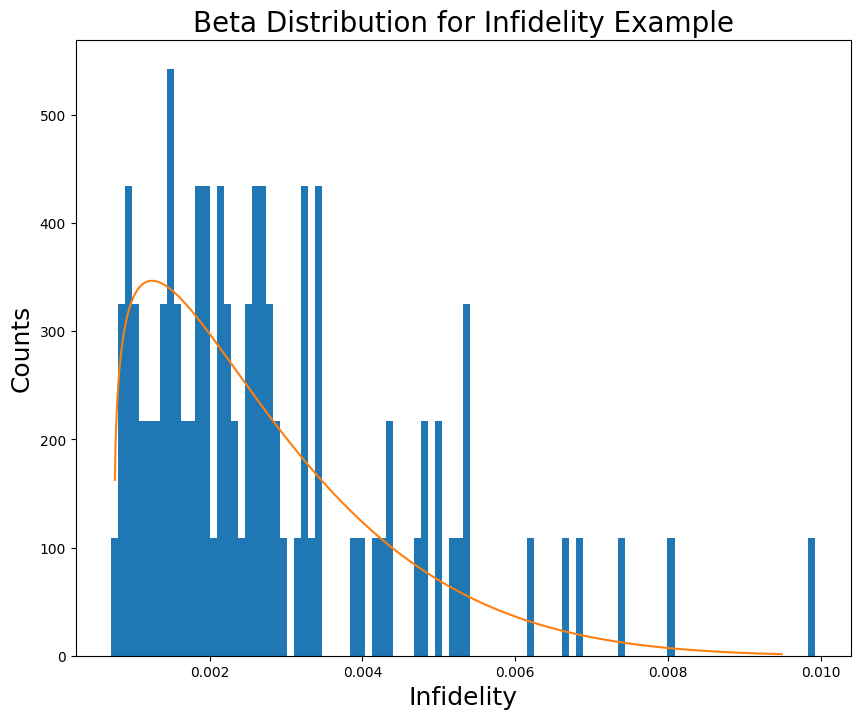

In [6]:
#If you want to perform a beta distribution on some of this infdelity data, use the following example code:
#a beta distribution is made thorugh 4 parameters: 2 shape parameters, a location, and a scale

infidelity_List = optimized_Infidelity_Nano #Update this to the list name you want to analyze

def Beta_Fit(x, a, b, loc, scale):
    return beta.pdf(x, a, b, loc=loc, scale=scale)

fig, ax =plt.subplots(1,1,figsize=(10,8))
y, bins, _ = ax.hist(infidelity_List, bins=100, density=True)
mean_0 = np.mean(infidelity_List) #Normal mean if you want to compare

confidence = 0.95
num_Trials = 100
a = 2
b = 6


params_0 = np.array([a,b,bins[0],(bins[-1]-bins[0])])
bounds = (np.array([1.1, 1.001, 0, 0]), np.array([np.inf, np.inf, np.inf, np.inf]))
parameters_Opt, covariance = curve_fit(Beta_Fit, bins[0:-1]+0.5*(bins[1]-bins[0]), y,p0=params_0, bounds=bounds, maxfev = 1000000)
a = parameters_Opt[0]
b = parameters_Opt[1]
loc = parameters_Opt[2]
scale = parameters_Opt[3]
print(a,b)
mean = beta.stats(a, b, loc=loc, scale=scale, moments = 'm')
lower, upper = beta.interval(confidence, a, b, loc = loc, scale = scale)
x = np.linspace(beta.ppf(0.001, a, b, loc=loc, scale = scale), beta.ppf(0.999, a, b, loc = loc, scale = scale), 1000)
ax.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale),label="a = 1.5")
ax.set_xlabel("Infidelity", fontsize = 18)
ax.set_ylabel("Counts", fontsize = 18)
ax.set_title("Beta Distribution for Infidelity Example", fontsize = 20)

print("Mean infdelity is:"+ str(mean))
print(lower,upper)

In [7]:
#np.save("Imp_Low_Deph_Nano_No_Deph_CNOT.npy", imperfect_Infidelity_Nano)
#np.save("Opt_Low_Deph_Nano_No_Deph_CNOT.npy", optimized_Infidelity_Nano)
np.save("Opt_Low_Deph_Nano_No_Deph_Beta_CNOT.npy", mean)

In [23]:
#Running a CZ Simulation with output state infidelity
#This is an example with my state-of-the-art QD parameters (no dephasing, no spectral diffusion, 95% directionality, 98% coupling, normal nanophotonic imperfections)
#When running this, it will default back to jit from njit since we can't use Jacob's mpu function in nopython mode
#Uses post-selected output states
#Includes Z and X basis as expected outputs to ensure it trains CZ correctly
basis_States = basis(2, 6)
Target, CZ_2_Photon, CZ_Vectors = find_CZ()

#Z basis expected outputs
Expected_Output_00 = np.dot(CZ_2_Photon, CZ_Vectors[0])
Expected_Output_01 = np.dot(CZ_2_Photon, CZ_Vectors[1])
Expected_Output_10 = np.dot(CZ_2_Photon, CZ_Vectors[2])
Expected_Output_11 = np.dot(CZ_2_Photon, CZ_Vectors[3])

#Computational Basis state indices
index_00 = basis_States.index([0, 1, 0, 1, 0, 0])
index_01 = basis_States.index([0, 1, 0, 0, 1, 0])
index_10 = basis_States.index([0, 0, 1, 1, 0, 0])
index_11 = basis_States.index([0, 0, 1, 0, 1, 0])

#X basis entries
CZ_Vectors.append((1/2)*(CZ_Vectors[0]+CZ_Vectors[1]+CZ_Vectors[2]+CZ_Vectors[3]))
CZ_Vectors.append((1/2)*(CZ_Vectors[0]-CZ_Vectors[1]+CZ_Vectors[2]+CZ_Vectors[3]))
CZ_Vectors.append((1/2)*(CZ_Vectors[0]+CZ_Vectors[1]-CZ_Vectors[2]+CZ_Vectors[3]))
CZ_Vectors.append((1/2)*(CZ_Vectors[0]-CZ_Vectors[1]-CZ_Vectors[2]+CZ_Vectors[3]))

#X basis expected outputs
Expected_Output_PP = np.dot(CZ_2_Photon, CZ_Vectors[4])
Expected_Output_PM = np.dot(CZ_2_Photon, CZ_Vectors[5])
Expected_Output_MP = np.dot(CZ_2_Photon, CZ_Vectors[6])
Expected_Output_MM = np.dot(CZ_2_Photon, CZ_Vectors[7])


index_List = [index_00, index_01, index_10,index_11]
Expected_Output_00_4x4 = [Expected_Output_00[index_00], Expected_Output_00[index_01], Expected_Output_00[index_10], Expected_Output_00[index_11]]
Expected_Output_01_4x4 = [Expected_Output_01[index_00], Expected_Output_01[index_01], Expected_Output_01[index_10], Expected_Output_01[index_11]]
Expected_Output_10_4x4 = [Expected_Output_10[index_00], Expected_Output_10[index_01], Expected_Output_10[index_10], Expected_Output_10[index_11]]
Expected_Output_11_4x4 = [Expected_Output_11[index_00], Expected_Output_11[index_01], Expected_Output_11[index_10], Expected_Output_11[index_11]]
Expected_Output_PP_4x4 = [Expected_Output_PP[index_00], Expected_Output_PP[index_01], Expected_Output_PP[index_10], Expected_Output_PP[index_11]]
Expected_Output_PM_4x4 = [Expected_Output_PM[index_00], Expected_Output_PM[index_01], Expected_Output_PM[index_10], Expected_Output_PM[index_11]]
Expected_Output_MP_4x4 = [Expected_Output_MP[index_00], Expected_Output_MP[index_01], Expected_Output_MP[index_10], Expected_Output_MP[index_11]]
Expected_Output_MM_4x4 = [Expected_Output_MM[index_00], Expected_Output_MM[index_01], Expected_Output_MM[index_10], Expected_Output_MM[index_11]]

#Combine expected outputs into a list
Expected_Outputs = [Expected_Output_00_4x4, Expected_Output_01_4x4, Expected_Output_10_4x4, Expected_Output_11_4x4, Expected_Output_PP_4x4, Expected_Output_PM_4x4, Expected_Output_MP_4x4, Expected_Output_MM_4x4]

list_Of_Imperfect_Infidelity = []
list_Of_Optimized_Infidelity = []
list_Of_Imperfect_U_Founds = []
list_Of_Optimized_U_Founds = []

Array_Of_Infidelities_00_Imperfect = []
Array_Of_Infidelities_01_Imperfect = []
Array_Of_Infidelities_10_Imperfect = []
Array_Of_Infidelities_11_Imperfect = []

Array_Of_Infidelities_00_Optimized = []
Array_Of_Infidelities_01_Optimized = []
Array_Of_Infidelities_10_Optimized = []
Array_Of_Infidelities_11_Optimized = []



test_Length = 20 #Usually set this to 100 and average over them all
tolerance = 1e-9

#Define QD parameters
gamma_Tot = 1
gamma_Loss_Value = 0.02
gamma_L_Value = 0.025*(gamma_Tot - gamma_Loss_Value)
gamma_R_Value = 0.975*(gamma_Tot - gamma_Loss_Value)
directionality = (gamma_R_Value - gamma_L_Value)/(gamma_L_Value+gamma_R_Value)
Spectral_Diffusion_Value = 0.0
gamma_Deph_Value = 0
print("Directionalty is: " + str(directionality))

for i in range(test_Length):
    print("Test Number: " + str(i))
    #Run the simulation with output states (set output state fidelity = True to ensure it runs that case)
    #Since there's no dephasing or SD, just run 2 monte carlo samples per entry
    #Running this with the chosen nanophotonic parameters as listed
    solved_Imperfect = MZM_Optimizer(U_Target = Target, N = 6, phi_QD_Num = 1, WG_Loss = 0.045, BS_Error = 0.04, phase_Error = 0, gamma_L = gamma_L_Value, gamma_R = gamma_R_Value, gamma_Loss = gamma_Loss_Value, gamma_Deph = gamma_Deph_Value, spectral_Diffusion = Spectral_Diffusion_Value, monte_Carlo_Samples= 2, opt_Tolerance = tolerance, expected_Outputs= Expected_Outputs, vector_inputs= CZ_Vectors, index_List= index_List, output_State_Fid= True)
    solved_Imperfect.solve_Imperfect_Quantum_DPrime_All_Imperfections()
    list_Of_Imperfect_Infidelity.append(solved_Imperfect.imperfect_Infidelity)
    list_Of_Imperfect_U_Founds.append(solved_Imperfect.imperfect_U_Founds)
    list_Of_Optimized_Infidelity.append(solved_Imperfect.optimized_Infidelity)
    list_Of_Optimized_U_Founds.append(solved_Imperfect.optimized_U_Founds)
    

Directionalty is: 0.9500000000000001
Test Number: 0
Test Number: 1
Test Number: 2
Test Number: 3
Test Number: 4
Test Number: 5
Test Number: 6
Test Number: 7
Test Number: 8
Test Number: 9
Test Number: 10
Test Number: 11
Test Number: 12
Test Number: 13
Test Number: 14
Test Number: 15
Test Number: 16
Test Number: 17
Test Number: 18
Test Number: 19


1.1000000000000003 3.151341086962586
Mean infdelity is:0.002558061570856275
0.0003814632784874575 0.006484833823709898


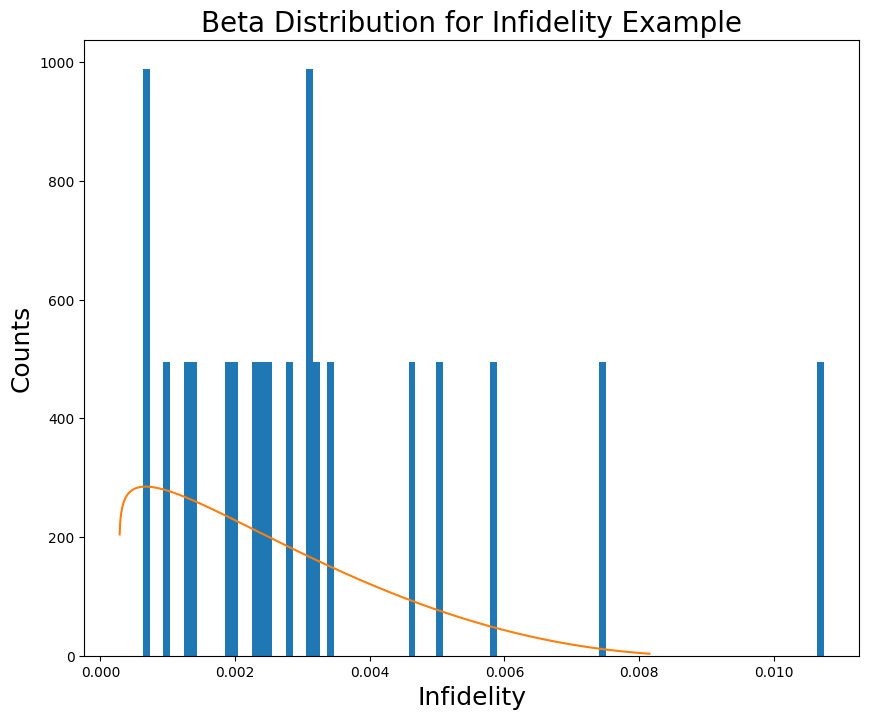

In [24]:
#If you want to perform a beta distribution on some of this infdelity data, use the following example code:
#a beta distribution is made thorugh 4 parameters: 2 shape parameters, a location, and a scale

infidelity_List = list_Of_Optimized_Infidelity #Update this to the list name you want to analyze

def Beta_Fit(x, a, b, loc, scale):
    return beta.pdf(x, a, b, loc=loc, scale=scale)

fig, ax =plt.subplots(1,1,figsize=(10,8))
y, bins, _ = ax.hist(infidelity_List, bins=100, density=True)
mean_0 = np.mean(infidelity_List) #Normal mean if you want to compare

confidence = 0.95
num_Trials = 100
a = 2
b = 6


params_0 = np.array([a,b,bins[0],(bins[-1]-bins[0])])
bounds = (np.array([1.1, 1.001, 0, 0]), np.array([np.inf, np.inf, np.inf, np.inf]))
parameters_Opt, covariance = curve_fit(Beta_Fit, bins[0:-1]+0.5*(bins[1]-bins[0]), y,p0=params_0, bounds=bounds, maxfev = 1000000)
a = parameters_Opt[0]
b = parameters_Opt[1]
loc = parameters_Opt[2]
scale = parameters_Opt[3]
print(a,b)
mean = beta.stats(a, b, loc=loc, scale=scale, moments = 'm')
lower, upper = beta.interval(confidence, a, b, loc = loc, scale = scale)
x = np.linspace(beta.ppf(0.001, a, b, loc=loc, scale = scale), beta.ppf(0.999, a, b, loc = loc, scale = scale), 1000)
ax.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale),label="a = 1.5")
ax.set_xlabel("Infidelity", fontsize = 18)
ax.set_ylabel("Counts", fontsize = 18)
ax.set_title("Beta Distribution for Infidelity Example", fontsize = 20)

print("Mean infdelity is:"+ str(mean))
print(lower,upper)
